# Домашнее задание №4.
Формулируем задачу в терминах ML

**Суть проекта:** cоздать самообучающуюся систему для выявления аномальных транзакций с применением графовых нейронных сетей в сети блокчейн. Основная задача — повысить точность и оперативность обнаружения финансового мошенничества

**Работа основана на датасете Elliptic++:** 

> https://github.com/git-disl/EllipticPlusPlus

> Youssef Elmougy and Ling Liu. 2023. Demystifying Fraudulent Transactions and Illicit Nodes in the Bitcoin Network for Financial Forensics. In Proceedings of the 29th ACM SIGKDD Conference on Knowledge Discovery and Data Mining (KDD ’23), August 6–10, 2023, Long Beach, CA, USA. ACM, New York, NY, USA, 12 pages. https://doi.org/10.1145/3580305.3599803

**Описание данных:** 

**Транзакции (transactions):**

- txs_features.csv – 203 769 строк, по 183 исходных признака (включая “временной шаг”, 93 локальных признака и 72 агрегированных) плюс 17 дополнительных, рассчитанных в расширении Elliptic++ (например, суммарный BTC_in/BTC_out, число входящих/исходящих транзакций, число адресов, размер транзакции, комиссии) 

- txs_classes.csv – метка каждого узла-транзакции: 1 = illicit, 2 = licit, 3 = unknown

- txs_edgelist.csv – ориентированные рёбра «транзакция → транзакция», задающие поток средств

Данные использовались из сети блокчейн, [пример данных](https://www.blockchain.com/explorer/transactions/btc/699cf63c7eaf93d91e38629e2d152f535fa77eaaa39b4d3dba1d17ea51818c45): 

![alt text](../images/blockchain.PNG)

**Акторы (wallet addresses):**

- wallets_features.csv – 822 942 адреса, по 56 признаков: статистика отправленных/полученных BTC, комиссии, временные интервалы между операциями, число взаимодействий с другими адресами и т. д.

- wallets_classes.csv – метка каждого адреса (illicit/licit/unknown) на основе его связей с помеченными транзакциями

- AddrAddr_edgelist.csv – рёбра «адрес → адрес» через общие транзакции

- AddrTx_edgelist.csv – рёбра «адрес → транзакция»

- TxAddr_edgelist.csv – рёбра «транзакция → адрес»

**Этапы выполнения задания:**

1. Загрузку и очистка данных 

2. Анализ данных 

3. Выбор 1-2 простых модели и 1 усложнённой (оптимизация гиперпараметров/AutoML/мультимодальность) 

4. Оценка метрик качества (не менее 2), оценка совокупной метрики качества, анализ результатов 

В ходе выполнения проекта будут оцениваться транзакции, после чего на их основе можно будет помечать кошельки как законные или незаконные

> изначальную метрику лучше получить на изначальном датасете а потом добавления и так далее сравнивать

> train test val разбить

##  1. Загрузим библиотеки

In [4]:
import os
import pandas as pd
import torch
import arviz as az
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
from IPython.display import display, Markdown
from sklearn.impute import KNNImputer
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import seaborn as sns
pd.set_option('display.max_columns', 500)

##  2. Загрузка и очистка данных

### 2.1 Загрузка и очистка данных транзакций

In [5]:
df_features = pd.read_csv('data/elliptic-bitcoin/transactions/txs_features.csv') # 203 769 строк, по 183 исходных признака (включая “временной шаг”, 93 локальных признака и 72 агрегированных) плюс 17 дополнительных, рассчитанных в расширении Elliptic++ (например, суммарный BTC_in/BTC_out, число входящих/исходящих транзакций, число адресов, размер транзакции, комиссии)
df_classes = pd.read_csv('data/elliptic-bitcoin/transactions/txs_classes.csv') # метка каждого узла-транзакции: 1 = illicit, 2 = licit, 3 = unknown.
df_edgelist = pd.read_csv('data/elliptic-bitcoin/transactions/txs_edgelist.csv') # ориентированные рёбра «транзакция → транзакция», задающие поток средств.

In [6]:
display(Markdown("Транзакции характеристики:"))
display(df_features.head(1))

display(Markdown("Транзакции связи:"))
display(df_edgelist.head(1))

display(Markdown("Транзакции классы:"))
display(df_classes.head(1))


Транзакции характеристики:

txId  Time step  Local_feature_1  Local_feature_2  Local_feature_3  \
0  3321          1        -0.169615        -0.184668        -1.201369   

   Local_feature_4  Local_feature_5  Local_feature_6  Local_feature_7  \
0         -0.12197        -0.043875        -0.113002        -0.061584   

   Local_feature_8  Local_feature_9  Local_feature_10  Local_feature_11  \
0        -0.160199        -0.166062         -0.049707         -0.162507   

   Local_feature_12  Local_feature_13  Local_feature_14  Local_feature_15  \
0         -0.028741         -0.035391         -0.042955         -0.013282   

   Local_feature_16  Local_feature_17  Local_feature_18  Local_feature_19  \
0         -0.042183          -0.16877         -0.171416         -0.172277   

   Local_feature_20  Local_feature_21  Local_feature_22  Local_feature_23  \
0         -1.373657          -1.37146         -0.139663         -0.148869   

   Local_feature_24  Local_feature_25  Local_feature_26  Local_feature_27  \
0         -0.080147         -0.155604         -0.010763         -0.012107   

   Local_feature_28  Local_feature_29  Local_feature_30  Local_feature_31  \
0         -0.139665         -0.148864         -0.080147         -0.155604   

   Local_feature_32  Local_feature_33  Local_feature_34  Local_feature_35  \
0         -0.010669         -0.012005         -0.024668         -0.031272   

   Local_feature_36  Local_feature_37  Local_feature_38  Local_feature_39  \
0         -0.023045         -0.026214          0.001428          0.001483   

   Local_feature_40  Local_feature_41  Local_feature_42  Local_feature_43  \
0         -0.226298         -0.238504         -0.075256         -0.234053   

   Local_feature_44  Local_feature_45  Local_feature_46  Local_feature_47  \
0          0.037468          0.043444         -0.226681         -0.242726   

   Local_feature_48  Local_feature_49  Local_feature_50  Local_feature_51  \
0         -0.097895         -0.235378          0.036577          0.042345   

   Local_feature_52  Local_feature_53  Local_feature_54  Local_feature_55  \
0           1.83078          1.378639         -0.232553           1.68641   

   Local_feature_56  Local_feature_57  Local_feature_58  Local_feature_59  \
0          0.048767          0.052956         -0.038877         -0.172804   

   Local_feature_60  Local_feature_61  Local_feature_62  Local_feature_63  \
0         -0.163071         -0.160801         -1.316342         -1.315388   

   Local_feature_64  Local_feature_65  Local_feature_66  Local_feature_67  \
0         -0.038872         -0.172793          -0.16306         -0.160794   

   Local_feature_68  Local_feature_69  Local_feature_70  Local_feature_71  \
0         -1.316333         -1.315375         -0.017032         -0.030026   

   Local_feature_72  Local_feature_73  Local_feature_74  Local_feature_75  \
0          -0.01764         -0.015071          2.146899          2.148396   

   Local_feature_76  Local_feature_77  Local_feature_78  Local_feature_79  \
0         -0.093535         -0.263634          -0.24997         -0.262749   

   Local_feature_80  Local_feature_81  Local_feature_82  Local_feature_83  \
0          1.133527          1.135947         -0.057425         -0.261929   

   Local_feature_84  Local_feature_85  Local_feature_86  Local_feature_87  \
0         -0.254785         -0.258624           1.12559          1.128038   

   Local_feature_88  Local_feature_89  Local_feature_90  Local_feature_91  \
0         -0.087322          0.780884          1.079939          0.722695   

   Local_feature_92  Local_feature_93  Aggregate_feature_1  \
0          1.135523          1.135279            -0.168245   

   Aggregate_feature_2  Aggregate_feature_3  Aggregate_feature_4  \
0            -0.200866            -0.116817            -0.190577   

   Aggregate_feature_5  Aggregate_feature_6  Aggregate_feature_7  \
0            -0.014659            -0.018849            -1.457761   

   Aggregate_feature_8  Aggregate_feature_9  Aggregate_feat

Транзакции связи:

txId1    txId2
0  230425980  5530458

Транзакции классы:

txId  class
0  3321      3

In [7]:
print(f"Транзакции характеристики: {df_features.shape}")
print(f"Транзакции классы: {df_classes.shape}")
print(f"Транзакции связи: {df_edgelist.shape}")

print('Количество пропущенных значений в транзакциях:', df_features.isna().values.sum(), round(df_features.isna().values.sum() / len(df_features) * 100, 2), '%')
print('Количество пропущенных значений в классах транзакций:', df_classes.isna().values.sum(), round(df_classes.isna().values.sum() / len(df_classes) * 100, 2), '%')
print('Количество пропущенных значений в рёбрах транзакций:', df_edgelist.isna().values.sum(), round(df_edgelist.isna().values.sum() / len(df_edgelist) * 100, 2), '%')  

Транзакции характеристики: (203769, 184)
Транзакции классы: (203769, 2)
Транзакции связи: (234355, 2)
Количество пропущенных значений в транзакциях: 16405 8.05 %
Количество пропущенных значений в классах транзакций: 0 0.0 %
Количество пропущенных значений в рёбрах транзакций: 0 0.0 %


In [8]:
missing_tx = df_features.isnull().sum()
missing_tx = missing_tx[missing_tx > 0]
print(f"Общее количество пропущенных значений в транзакциях: {df_features.isna().sum().sum()}")
print(f"Количество признаков с пропущенными значениями: {len(missing_tx)}")
if len(missing_tx) > 0:
    print("\nПризнаки с пропущенными значениями:")
    print(missing_tx)

Общее количество пропущенных значений в транзакциях: 16405
Количество признаков с пропущенными значениями: 17

Признаки с пропущенными значениями:
in_txs_degree           965
out_txs_degree          965
total_BTC               965
fees                    965
size                    965
num_input_addresses     965
num_output_addresses    965
in_BTC_min              965
in_BTC_max              965
in_BTC_mean             965
in_BTC_median           965
in_BTC_total            965
out_BTC_min             965
out_BTC_max             965
out_BTC_mean            965
out_BTC_median          965
out_BTC_total           965
dtype: int64


Как можно заметить пропущенные значения в колонках с характеристиками транзакций, что говорит о том, что вероятно не удалось спарсить эти данные из сети блокчейн, посмотрим далее можно ли это исправить заполнив их

### 2.2 Загрузка и очистка данных кошельков

In [9]:
df_AddrTx_edgelist = pd.read_csv('data/elliptic-bitcoin/actors/AddrTx_edgelist.csv') # рёбра «адрес → транзакция»
df_TxAddr_edgelist = pd.read_csv('data/elliptic-bitcoin/actors/TxAddr_edgelist.csv') # рёбра «транзакция → адрес»
df_wallets_classes = pd.read_csv('data/elliptic-bitcoin/actors/wallets_classes.csv') # метка каждого адреса (illicit/licit/unknown) на основе его связей с помеченными транзакциями.
df_wallets_features = pd.read_csv('data/elliptic-bitcoin/actors/wallets_features.csv') # 822 942 адреса, по 56 признаков: статистика отправленных/полученных BTC, комиссии, временные интервалы между операциями, число взаимодействий с другими адресами и т. д. 

In [10]:
display(Markdown("Связи адрес-транзакция:"))
display(df_AddrTx_edgelist.head(1))

display(Markdown("Связи транзакция-адрес:"))
display(df_TxAddr_edgelist.head(1))

display(Markdown("Кошельки (классы):"))
display(df_wallets_classes.head(1))

display(Markdown("Кошельки (характеристики):"))
display(df_wallets_features.head(1))


Связи адрес-транзакция:

input_address       txId
0  14YRXHHof4BY1TVxN5FqYPcEdpmXiYT78a  230325127

Связи транзакция-адрес:

txId                      output_address
0  230325127  1GASxu5nMntiRKdVtTVRvEbP965G51bhHH

Кошельки (классы):

address  class
0  111112TykSw72ztDN2WJger4cynzWYC5w      2

Кошельки (характеристики):

address  Time step  num_txs_as_sender  \
0  111112TykSw72ztDN2WJger4cynzWYC5w         25                0.0   

   num_txs_as receiver  first_block_appeared_in  last_block_appeared_in  \
0                  1.0                 439586.0                439586.0   

   lifetime_in_blocks  total_txs  first_sent_block  first_received_block  \
0                 0.0        1.0               0.0              439586.0   

   num_timesteps_appeared_in  btc_transacted_total  btc_transacted_min  \
0                        1.0              0.010628            0.010628   

   btc_transacted_max  btc_transacted_mean  btc_transacted_median  \
0            0.010628             0.010628               0.010628   

   btc_sent_total  btc_sent_min  btc_sent_max  btc_sent_mean  btc_sent_median  \
0             0.0           0.0           0.0            0.0              0.0   

   btc_received_total  btc_received_min  btc_received_max  btc_received_mean  \
0            0.010628          0.010628          0.010628           0.010628   

   btc_received_median  fees_total  fees_min  fees_max  fees_mean  \
0             0.010628    0.007042  0.007042  0.007042   0.007042   

   fees_median  fees_as_share_total  fees_as_share_min  fees_as_share_max  \
0     0.007042             0.000012           0.000012           0.000012   

   fees_as_share_mean  fees_as_share_median  blocks_btwn_txs_total  \
0            0.000012              0.000012                    0.0   

   blocks_btwn_txs_min  blocks_btwn_txs_max  blocks_btwn_txs_mean  \
0                  0.0                  0.0                   0.0   

   blocks_btwn_txs_median  blocks_btwn_input_txs_total  \
0                     0.0                          0.0   

   blocks_btwn_input_txs_min  blocks_btwn_input_txs_max  \
0                        0.0                        0.0   

   blocks_btwn_input_txs_mean  blocks_btwn_input_txs_median  \
0                         0.0                           0.0   

   blocks_btwn_output_txs_total  blocks_btwn_output_txs_min  \
0                           0.0                         0.0   

   blocks_btwn_output_txs_max  blocks_btwn_output_txs_mean  \
0                         0.0                          0.0   

   blocks_btwn_output_txs_median  num_addr_transacted_multiple  \
0                            0.0                           0.0   

   transacted_w_address_total  transacted_w_address_min  \
0                        24.0                       1.0   

   transacted_w_address_max  transacted_w_address_mean  \
0                       1.0                        1.0   

   transacted_w_address_median  
0                          1.0

In [11]:
print(f"Связи адрес-транзакция: {df_AddrTx_edgelist.shape}")
print(f"Связи транзакция-адрес: {df_TxAddr_edgelist.shape}")
print(f"Кошельки (классы): {df_wallets_classes.shape}")
print(f"Кошельки (характеристики): {df_wallets_features.shape}")

print('Количество пропущенных значений в рёбрах «адрес → транзакция»:', df_AddrTx_edgelist.isna().values.sum(), round(df_AddrTx_edgelist.isna().values.sum() / len(df_AddrTx_edgelist) * 100, 2), '%')
print('Количество пропущенных значений в рёбрах «транзакция → адрес»:', df_TxAddr_edgelist.isna().values.sum(), round(df_TxAddr_edgelist.isna().values.sum() / len(df_TxAddr_edgelist) * 100, 2), '%')  
print('Количество пропущенных значений в классах транзакций:', df_wallets_classes.isna().values.sum(), round(df_wallets_classes.isna().values.sum() / len(df_wallets_classes) * 100, 2), '%')  
print('Количество пропущенных значений в кошельках:', df_wallets_features.isna().values.sum(), round(df_wallets_features.isna().values.sum() / len(df_wallets_features) * 100, 2), '%')  

Связи адрес-транзакция: (477117, 2)
Связи транзакция-адрес: (837124, 2)
Кошельки (классы): (822942, 2)
Кошельки (характеристики): (1268260, 57)
Количество пропущенных значений в рёбрах «адрес → транзакция»: 0 0.0 %
Количество пропущенных значений в рёбрах «транзакция → адрес»: 0 0.0 %
Количество пропущенных значений в классах транзакций: 0 0.0 %
Количество пропущенных значений в кошельках: 0 0.0 %


### 2.3 Преобразую данные в единые датасеты (по возможности) для удобства и переименую классы

In [12]:
# Объединяю транзакции и классы
df_transactions = df_features.merge(df_classes, on='txId')

# Объединяю кошельки и классы
df_wallets = df_wallets_features.merge(df_wallets_classes, on='address')

# Переименовываю классы
label_map = {1: 'illicit', 2: 'licit', 3: 'unknown'}
df_transactions['class_map'] = df_transactions['class'].map(label_map)
df_wallets['class_map'] = df_wallets['class'].map(label_map)


In [13]:
counts = df_transactions.groupby(['Time step', 'class_map']).size().unstack(fill_value=0)
print("Таблица количества транзакций по time_step и классам:")
print(counts.head(10))

Таблица количества транзакций по time_step и классам:
class_map  illicit  licit  unknown
Time step                         
1               17   2130     5733
2               18   1099     3427
3               11   1268     5342
4               30   1410     4253
5                8   1874     4921
6                5    480     3843
7              102   1101     4845
8               67   1098     3292
9              248    530     4218
10              18    954     5755


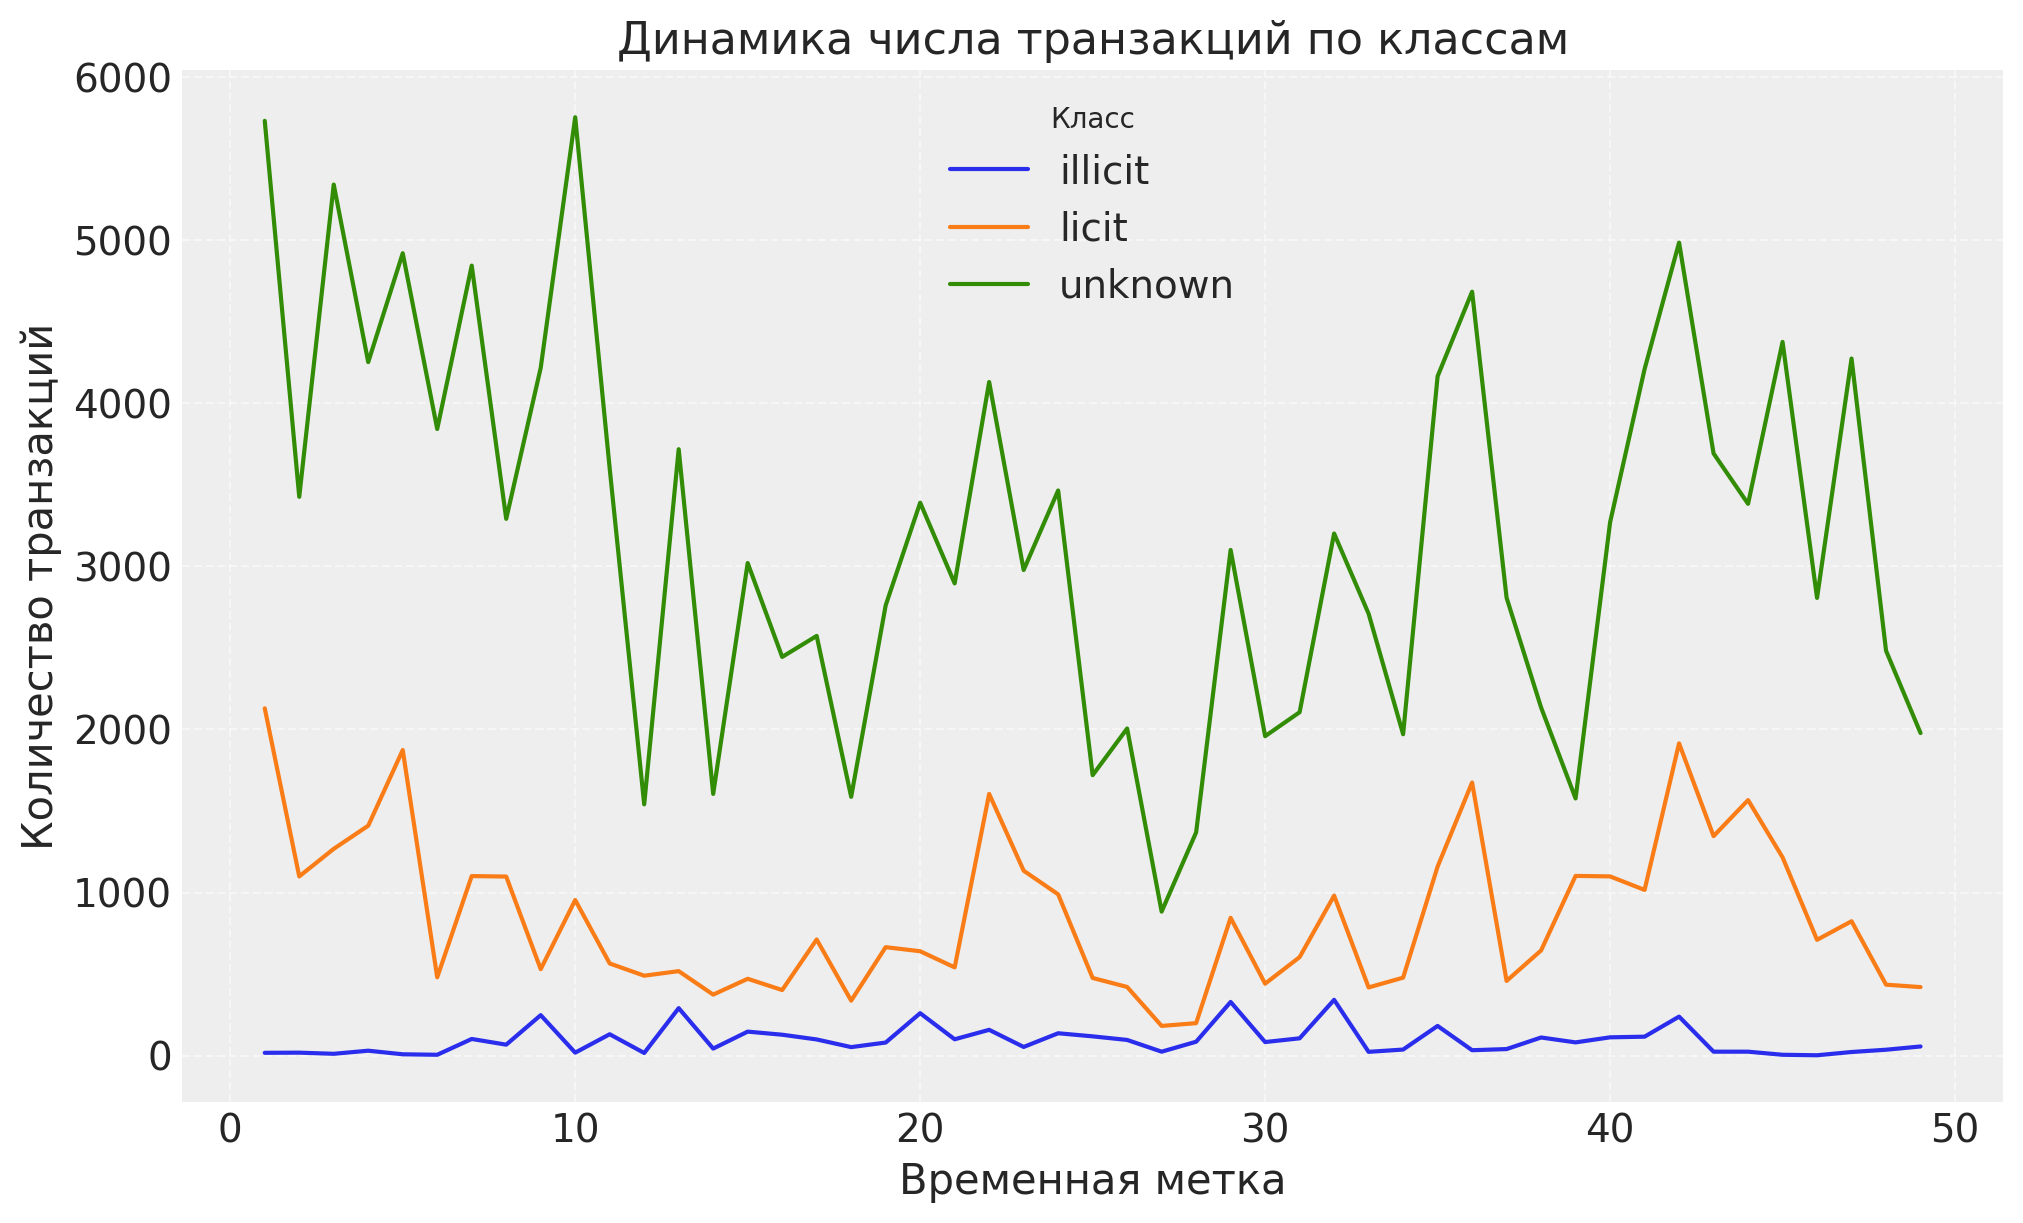

In [14]:
counts = df_transactions.groupby(['Time step', 'class_map']).size().unstack(fill_value=0)

plt.figure(figsize=(10, 6))
for lbl in counts.columns:
    plt.plot(counts.index, counts[lbl], label=lbl)
plt.xlabel('Временная метка')
plt.ylabel('Количество транзакций')
plt.title('Динамика числа транзакций по классам')
plt.legend(title='Класс')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [15]:
counts = df_wallets.groupby(['Time step', 'class_map']).size().unstack(fill_value=0)
print("Таблица количества кошельков по time_step и классам:")
print(counts.head(10))

Таблица количества кошельков по time_step и классам:
class_map  illicit  licit  unknown
Time step                         
1               96  24547    26465
2               99  16292    15878
3               58   4835    26213
4              266   8647    31035
5               54  10465    24621
6               17   1957    17029
7              463   7902    23357
8              267  16229    17631
9              960   3894    23819
10             120   8454    38271


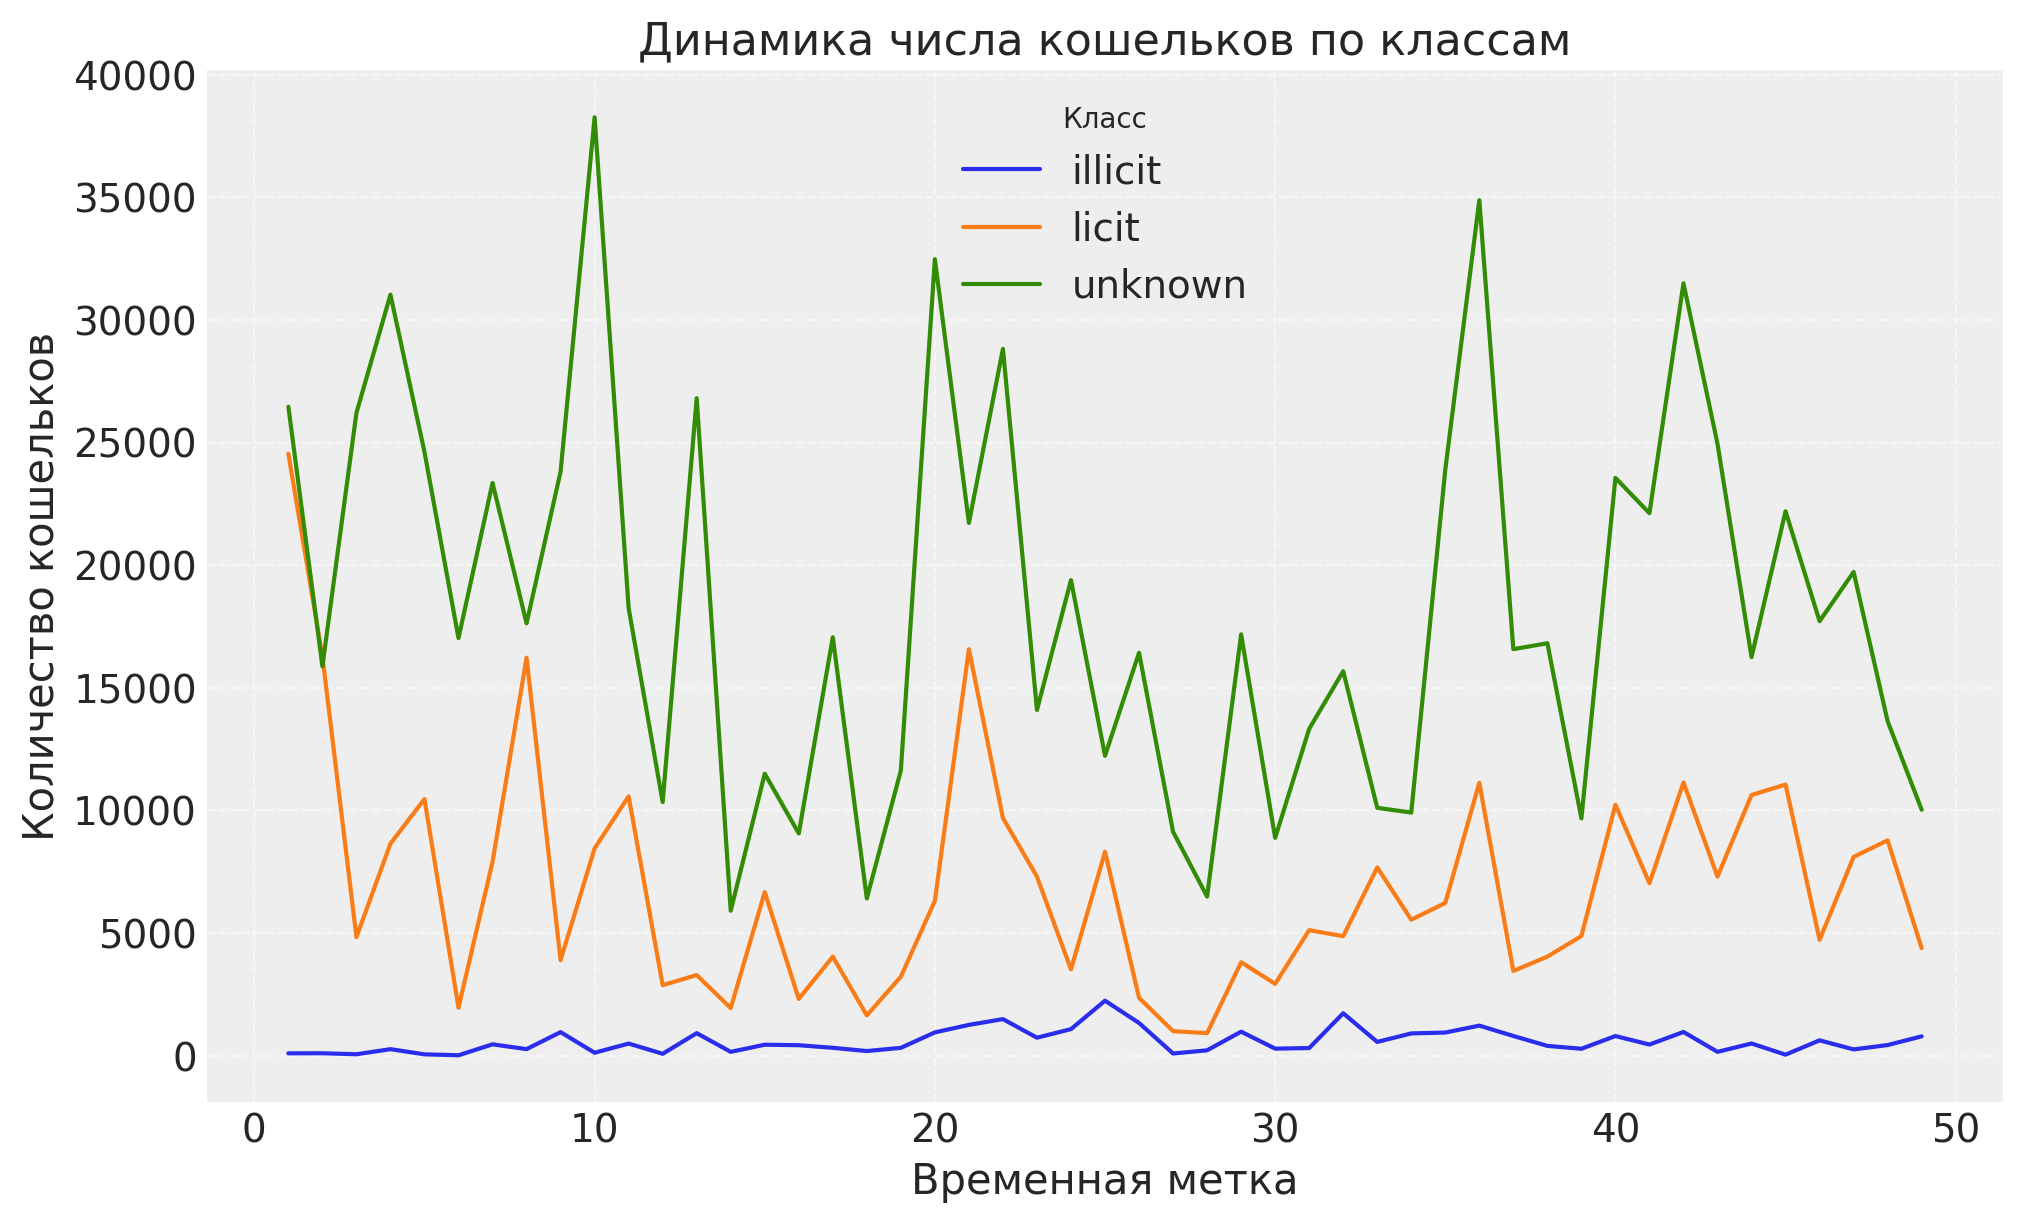

In [16]:
counts = df_wallets.groupby(['Time step', 'class_map']).size().unstack(fill_value=0)

plt.figure(figsize=(10, 6))
for lbl in counts.columns:
    plt.plot(counts.index, counts[lbl], label=lbl)
plt.xlabel('Временная метка')
plt.ylabel('Количество кошельков')
plt.title('Динамика числа кошельков по классам')
plt.legend(title='Класс')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

## 3. Анализ данных

##### Разбор примера взаимодействия датасетов: 

In [17]:
df_edgelist[df_edgelist['txId2'] == 3321]

txId1  txId2
1310  196542151   3321

In [18]:
df_transactions[df_transactions['txId'] == 3321]

txId  Time step  Local_feature_1  Local_feature_2  Local_feature_3  \
0  3321          1        -0.169615        -0.184668        -1.201369   

   Local_feature_4  Local_feature_5  Local_feature_6  Local_feature_7  \
0         -0.12197        -0.043875        -0.113002        -0.061584   

   Local_feature_8  Local_feature_9  Local_feature_10  Local_feature_11  \
0        -0.160199        -0.166062         -0.049707         -0.162507   

   Local_feature_12  Local_feature_13  Local_feature_14  Local_feature_15  \
0         -0.028741         -0.035391         -0.042955         -0.013282   

   Local_feature_16  Local_feature_17  Local_feature_18  Local_feature_19  \
0         -0.042183          -0.16877         -0.171416         -0.172277   

   Local_feature_20  Local_feature_21  Local_feature_22  Local_feature_23  \
0         -1.373657          -1.37146         -0.139663         -0.148869   

   Local_feature_24  Local_feature_25  Local_feature_26  Local_feature_27  \
0         -0.080147         -0.155604         -0.010763         -0.012107   

   Local_feature_28  Local_feature_29  Local_feature_30  Local_feature_31  \
0         -0.139665         -0.148864         -0.080147         -0.155604   

   Local_feature_32  Local_feature_33  Local_feature_34  Local_feature_35  \
0         -0.010669         -0.012005         -0.024668         -0.031272   

   Local_feature_36  Local_feature_37  Local_feature_38  Local_feature_39  \
0         -0.023045         -0.026214          0.001428          0.001483   

   Local_feature_40  Local_feature_41  Local_feature_42  Local_feature_43  \
0         -0.226298         -0.238504         -0.075256         -0.234053   

   Local_feature_44  Local_feature_45  Local_feature_46  Local_feature_47  \
0          0.037468          0.043444         -0.226681         -0.242726   

   Local_feature_48  Local_feature_49  Local_feature_50  Local_feature_51  \
0         -0.097895         -0.235378          0.036577          0.042345   

   Local_feature_52  Local_feature_53  Local_feature_54  Local_feature_55  \
0           1.83078          1.378639         -0.232553           1.68641   

   Local_feature_56  Local_feature_57  Local_feature_58  Local_feature_59  \
0          0.048767          0.052956         -0.038877         -0.172804   

   Local_feature_60  Local_feature_61  Local_feature_62  Local_feature_63  \
0         -0.163071         -0.160801         -1.316342         -1.315388   

   Local_feature_64  Local_feature_65  Local_feature_66  Local_feature_67  \
0         -0.038872         -0.172793          -0.16306         -0.160794   

   Local_feature_68  Local_feature_69  Local_feature_70  Local_feature_71  \
0         -1.316333         -1.315375         -0.017032         -0.030026   

   Local_feature_72  Local_feature_73  Local_feature_74  Local_feature_75  \
0          -0.01764         -0.015071          2.146899          2.148396   

   Local_feature_76  Local_feature_77  Local_feature_78  Local_feature_79  \
0         -0.093535         -0.263634          -0.24997         -0.262749   

   Local_feature_80  Local_feature_81  Local_feature_82  Local_feature_83  \
0          1.133527          1.135947         -0.057425         -0.261929   

   Local_feature_84  Local_feature_85  Local_feature_86  Local_feature_87  \
0         -0.254785         -0.258624           1.12559          1.128038   

   Local_feature_88  Local_feature_89  Local_feature_90  Local_feature_91  \
0         -0.087322          0.780884          1.079939          0.722695   

   Local_feature_92  Local_feature_93  Aggregate_feature_1  \
0          1.135523          1.135279            -0.168245   

   Aggregate_feature_2  Aggregate_feature_3  Aggregate_feature_4  \
0            -0.200866            -0.116817            -0.190577   

   Aggregate_feature_5  Aggregate_feature_6  Aggregate_feature_7  \
0            -0.014659            -0.018849            -1.457761   

   Aggregate_feature_8  Aggregate_feature_9  Aggregate_feat

In [19]:
df_transactions[df_transactions['txId'] == 196542151]

txId  Time step  Local_feature_1  Local_feature_2  Local_feature_3  \
2739  196542151          1        -0.168603        -0.184668        -1.201369   

      Local_feature_4  Local_feature_5  Local_feature_6  Local_feature_7  \
2739         -0.12197        -0.043875        -0.113002        -0.061584   

      Local_feature_8  Local_feature_9  Local_feature_10  Local_feature_11  \
2739        -0.159164        -0.165041         -0.049707         -0.161473   

      Local_feature_12  Local_feature_13  Local_feature_14  Local_feature_15  \
2739         -0.028741         -0.035391         -0.042955         -0.013282   

      Local_feature_16  Local_feature_17  Local_feature_18  Local_feature_19  \
2739         -0.042785         -0.167687         -0.170122         -0.171079   

      Local_feature_20  Local_feature_21  Local_feature_22  Local_feature_23  \
2739          0.887058          0.884557         -0.139663         -0.148869   

      Local_feature_24  Local_feature_25  Local_feature_26  Local_feature_27  \
2739         -0.080147         -0.155604         -0.010763         -0.012107   

      Local_feature_28  Local_feature_29  Local_feature_30  Local_feature_31  \
2739         -0.139665         -0.148864         -0.080147         -0.155604   

      Local_feature_32  Local_feature_33  Local_feature_34  Local_feature_35  \
2739         -0.010669         -0.012005         -0.024668         -0.031272   

      Local_feature_36  Local_feature_37  Local_feature_38  Local_feature_39  \
2739         -0.023045         -0.026214          0.001428          0.001483   

      Local_feature_40  Local_feature_41  Local_feature_42  Local_feature_43  \
2739         -0.226298         -0.238504         -0.075256         -0.234053   

      Local_feature_44  Local_feature_45  Local_feature_46  Local_feature_47  \
2739          0.037468          0.043444         -0.226681         -0.242726   

      Local_feature_48  Local_feature_49  Local_feature_50  Local_feature_51  \
2739         -0.097895         -0.235378          0.036577          0.042345   

      Local_feature_52  Local_feature_53  Local_feature_54  Local_feature_55  \
2739           1.83078          1.378639         -0.232553           1.68641   

      Local_feature_56  Local_feature_57  Local_feature_58  Local_feature_59  \
2739          0.048767          0.052956         -0.039149         -0.172855   

      Local_feature_60  Local_feature_61  Local_feature_62  Local_feature_63  \
2739         -0.163083         -0.160893          0.923473          0.923011   

      Local_feature_64  Local_feature_65  Local_feature_66  Local_feature_67  \
2739         -0.039145         -0.172844         -0.163072         -0.160886   

      Local_feature_68  Local_feature_69  Local_feature_70  Local_feature_71  \
2739          0.923516           0.92311         -0.017032         -0.030026   

      Local_feature_72  Local_feature_73  Local_feature_74  Local_feature_75  \
2739          -0.01764         -0.015071          2.146899          2.148396   

      Local_feature_76  Local_feature_77  Local_feature_78  Local_feature_79  \
2739         -0.095403         -0.263634          -0.24976         -0.262955   

      Local_feature_80  Local_feature_81  Local_feature_82  Local_feature_83  \
2739          1.133527          1.135947         -0.059013         -0.261929   

      Local_feature_84  Local_feature_85  Local_feature_86  Local_feature_87  \
2739          -0.25466         -0.258748           1.12559          1.128038   

      Local_feature_88  Local_feature_89  Local_feature_90  Local_feature_91  \
2739         -0.113308          0.780884          1.091473          0.714188   

      Local_feature_92  Local_feature_93  Aggregate_feature_1  \
2739          1.135523          1.135279            -0.156864   

      Aggregate_feature_2  Aggregate_feature_3  Aggregate_feature_4  \
2739            -0.191931            -0.116817             -0.17944   

      Aggregate_feature_5  Aggregate_feature

In [20]:
df_wallets[df_wallets['address'] == '18TnVVsNqViRGTNzCjk5dnW4VNxpehywXB']

address  Time step  num_txs_as_sender  \
309095  18TnVVsNqViRGTNzCjk5dnW4VNxpehywXB          1                2.0   
309096  18TnVVsNqViRGTNzCjk5dnW4VNxpehywXB          1                2.0   
309097  18TnVVsNqViRGTNzCjk5dnW4VNxpehywXB          1                2.0   
309098  18TnVVsNqViRGTNzCjk5dnW4VNxpehywXB          4                2.0   

        num_txs_as receiver  first_block_appeared_in  last_block_appeared_in  \
309095                  2.0                 391202.0                397257.0   
309096                  2.0                 391202.0                397257.0   
309097                  2.0                 391202.0                397257.0   
309098                  2.0                 391202.0                397257.0   

        lifetime_in_blocks  total_txs  first_sent_block  first_received_block  \
309095              6055.0        4.0          391211.0              391202.0   
309096              6055.0        4.0          391211.0              391202.0   
309097              6055.0        4.0          391211.0              391202.0   
309098              6055.0        4.0          391211.0              391202.0   

        num_timesteps_appeared_in  btc_transacted_total  btc_transacted_min  \
309095                        2.0              2.041012            0.160404   
309096                        2.0              2.041012            0.160404   
309097                        2.0              2.041012            0.160404   
309098                        2.0              2.041012            0.160404   

        btc_transacted_max  btc_transacted_mean  btc_transacted_median  \
309095            0.818958             0.510253               0.530825   
309096            0.818958             0.510253               0.530825   
309097            0.818958             0.510253               0.530825   
309098            0.818958             0.510253               0.530825   

        btc_sent_total  btc_sent_min  btc_sent_max  btc_sent_mean  \
309095        0.527578           0.0      0.367174       0.131894   
309096        0.527578           0.0      0.367174       0.131894   
309097        0.527578           0.0      0.367174       0.131894   
309098        0.527578           0.0      0.367174       0.131894   

        btc_sent_median  btc_received_total  btc_received_min  \
309095         0.080202            1.513434               0.0   
309096         0.080202            1.513434               0.0   
309097         0.080202            1.513434               0.0   
309098         0.080202            1.513434               0.0   

        btc_received_max  btc_received_mean  btc_received_median  fees_total  \
309095          0.818958           0.378359             0.347238    0.001802   
309096          0.818958           0.378359             0.347238    0.001802   
309097          0.818958           0.378359             0.347238    0.001802   
309098          0.818958           0.378359             0.347238    0.001802   

        fees_min  fees_max  fees_mean  fees_median  fees_as_share_total  \
309095    0.0001  0.001502    0.00045       0.0001             0.000224   
309096    0.0001  0.001502    0.00045       0.0001             0.000224   
309097    0.0001  0.001502    0.00045       0.0001             0.000224   
309098    0.0001  0.001502    0.00045       0.0001             0.000224   

        fees_as_share_min  fees_as_share_max  fees_as_share_mean  \
309095           0.000004             0.0001            0.000056   
309096           0.000004             0.0001            0.000056   
309097           0.000004             0.0001            0.000056   
309098           0.000004             0.0001            0.000056   

        fees_as_share_median  blocks_btwn_txs_total  blocks_btwn_txs_min  \
309095               0.00006                 6055.0                  0.0   
309096               0.00006                 6055.0                  0.0   
309097               0.00006                 6055.0           

In [21]:
df_AddrTx_edgelist[df_AddrTx_edgelist['txId'] == 196542151]

input_address       txId
19940  18TnVVsNqViRGTNzCjk5dnW4VNxpehywXB  196542151

In [22]:
df_AddrTx_edgelist[df_AddrTx_edgelist['txId'] == 3321]

input_address  txId
19941  18TnVVsNqViRGTNzCjk5dnW4VNxpehywXB  3321

In [23]:
df_TxAddr_edgelist[df_TxAddr_edgelist['txId'] == 3321]

txId                      output_address
28938  3321  18TnVVsNqViRGTNzCjk5dnW4VNxpehywXB
28939  3321  1EhgvhK2NDuobSTynVFp8MTJeYtVrWnjUf

##### Эта же транзакция [в сети блокчейн](https://www.blockchain.com/explorer/transactions/btc/f4ffa6a22dcc1b24645b24227eaf04b2dc6ba9ce49578465f7c274767d175e52):

![alt text](../images/example.PNG)

Как можно заметить основные характетеристики представленные в данных совпадают и можно четко атрибуцировать эти данные к конкретной транзакции

### 3.1 Анализ транзакций. Табличное представление

Поскольку в изначальных данных присутствуют зашифрованные фичи от компании Elliptic и в продакшене их не будет возможности использовать, то попробую заполнить пропуски на основе них и после чего очищу от них данные

In [24]:
numeric_cols = df_transactions.select_dtypes(include='number').columns
local_agg_features = [col for col in numeric_cols if col.startswith('Local') or col.startswith('Aggregate')]
other_numeric = [col for col in numeric_cols if not (col.startswith('Local') or col.startswith('Aggregate'))]
df_transactions[local_agg_features]

Local_feature_1  Local_feature_2  Local_feature_3  Local_feature_4  \
0             -0.169615        -0.184668        -1.201369        -0.121970   
1             -0.137586        -0.184668        -1.201369        -0.121970   
2             -0.170103        -0.184668        -1.201369        -0.121970   
3             -0.114267        -0.184668        -1.201369         0.028105   
4              5.202107        -0.210553        -1.756361        -0.121970   
...                 ...              ...              ...              ...   
203764        -0.165622        -0.139563         1.018602        -0.121970   
203765        -0.167040        -0.139563         1.018602        -0.121970   
203766        -0.167040        -0.139563         1.018602        -0.121970   
203767        -0.172212        -0.139573         1.018602        -0.121970   
203768        -0.172212        -0.139573         1.018602        -0.121970   

        Local_feature_5  Local_feature_6  Local_feature_7  Local_feature_8  \
0             -0.043875        -0.113002        -0.061584        -0.160199   
1             -0.043875        -0.113002        -0.061584        -0.127429   
2             -0.043875        -0.113002        -0.061584        -0.160699   
3             -0.043875        -0.113002         0.547008        -0.161652   
4            260.090707        -0.113002        -0.061584         5.335864   
...                 ...              ...              ...              ...   
203764        -0.043875        -0.113002        -0.061584        -0.156113   
203765        -0.043875        -0.113002        -0.061584        -0.157564   
203766        -0.043875        -0.113002        -0.061584        -0.157564   
203767        -0.043875        -0.113002        -0.061584        -0.162856   
203768        -0.043875        -0.113002        -0.061584        -0.162856   

        Local_feature_9  Local_feature_10  Local_feature_11  Local_feature_12  \
0             -0.166062         -0.049707         -0.162507         -0.028741   
1             -0.133751         -0.049707         -0.129773         -0.028741   
2             -0.166555         -0.049707         -0.163006         -0.028741   
3             -0.118555          0.300047         -0.145947          2.017758   
4              5.252974         -0.049707          5.327423         -0.028741   
...                 ...               ...               ...               ...   
203764        -0.162033         -0.049707         -0.158425         -0.028741   
203765        -0.163463         -0.049707         -0.159874         -0.028741   
203766        -0.163463         -0.049707         -0.159874         -0.028741   
203767        -0.168681         -0.049707         -0.165160         -0.028741   
203768        -0.168681         -0.049707         -0.165160         -0.028741   

        Local_feature_13  Local_feature_14  Local_feature_15  \
0              -0.035391         -0.042955         -0.013282   
1              -0.035391         -0.042955         -0.013282   
2              -0.035391         -0.042955         -0.013282   
3               1.189967         -0.042955         -0.013282   
4              -0.035391        265.263236         -0.013282   
...                  ...               ...               ...   
203764         -0.035391         -0.042955         -0.013282   
203765         -0.035391         -0.042955         -0.013282   
203766         -0.035391         -0.042955         -0.013282   
203767         -0.035391         -0.042955         -0.013282   
203768         -0.035391         -0.042955         -0.013282   

        Local_feature_16  Local_feature_17  Local_feature_18  \
0              -0.042183         -0.168770         -0.171416   
1              -0.003952         -0.138560         -0.139821   
2              -0.036613         -0.169668         -0.172904   
3               0.054659         -0.118754         -0.121849   
4              -0.057401          0.096439         -0.167593   
...     

Замечу также, что классы для пропущенных значений размечены, что будет полезно в последующем исследовании

In [25]:
df_transactions[df_transactions['out_BTC_total'].isna()].class_map.value_counts().reset_index(name='quantity')

class_map  quantity
0     licit       519
1   unknown       446

Заполню пропуски на основе KNN

In [26]:
df_transactions_filled = df_transactions.copy()

num_cols = df_transactions_filled.select_dtypes(include=['float64', 'int64']).columns.tolist()

imputer = KNNImputer(n_neighbors=5, weights="distance", metric='nan_euclidean')

df_num = pd.DataFrame(imputer.fit_transform(df_transactions_filled[num_cols]),
                      columns=num_cols,
                      index=df_transactions_filled.index)

df_transactions_filled[num_cols] = df_num

Посмотрим на распределение классов после заполнения:

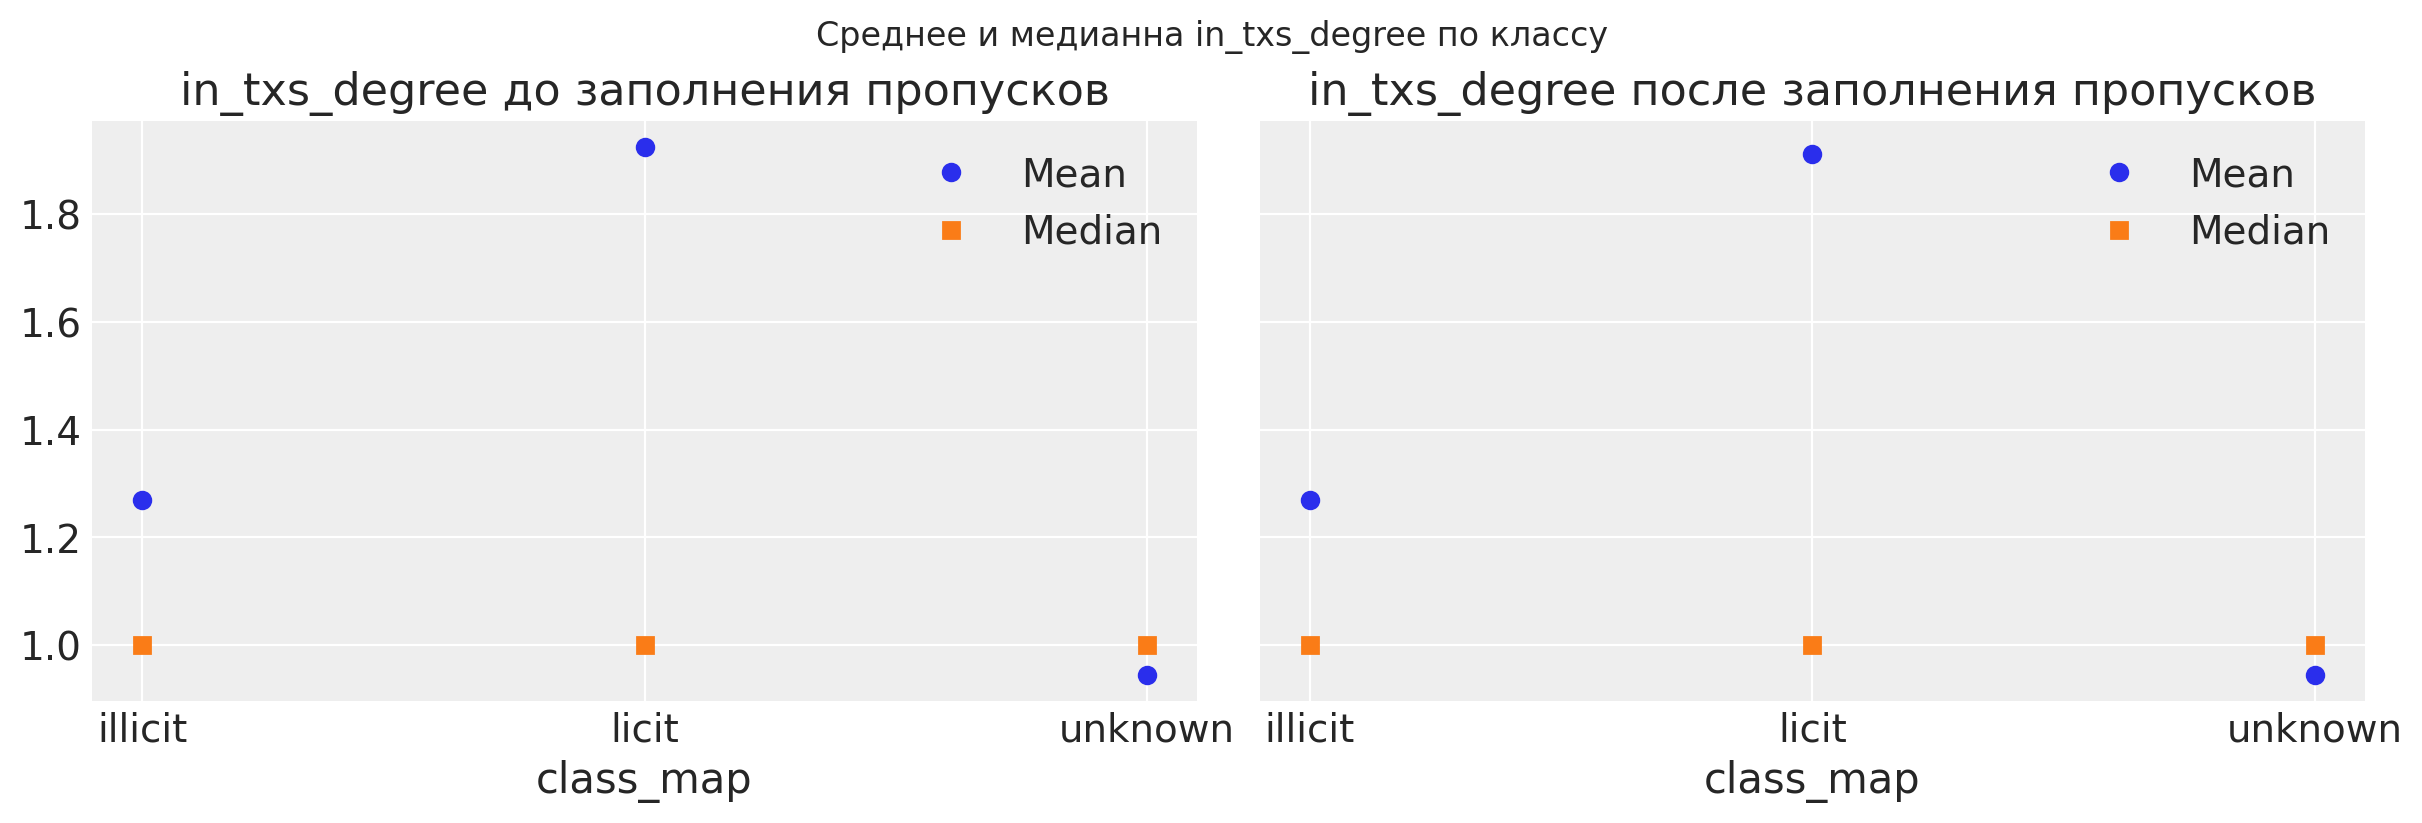

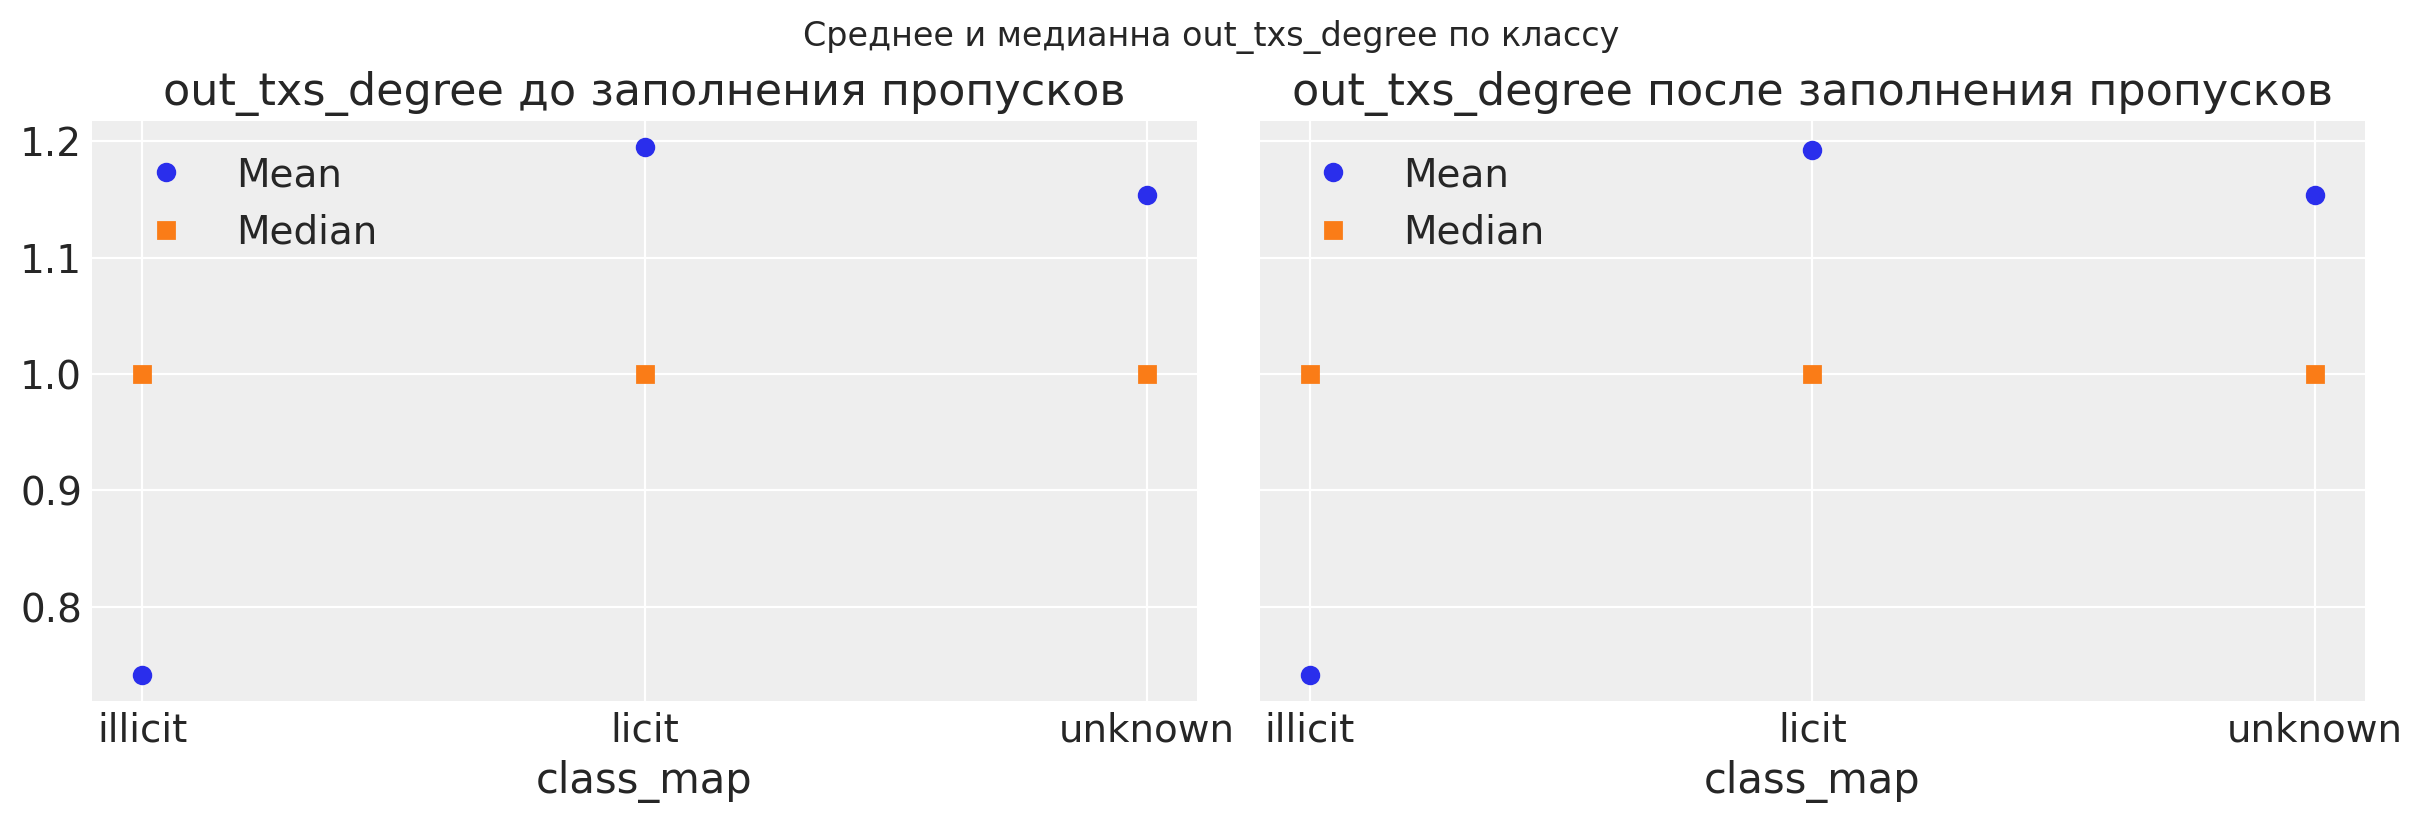

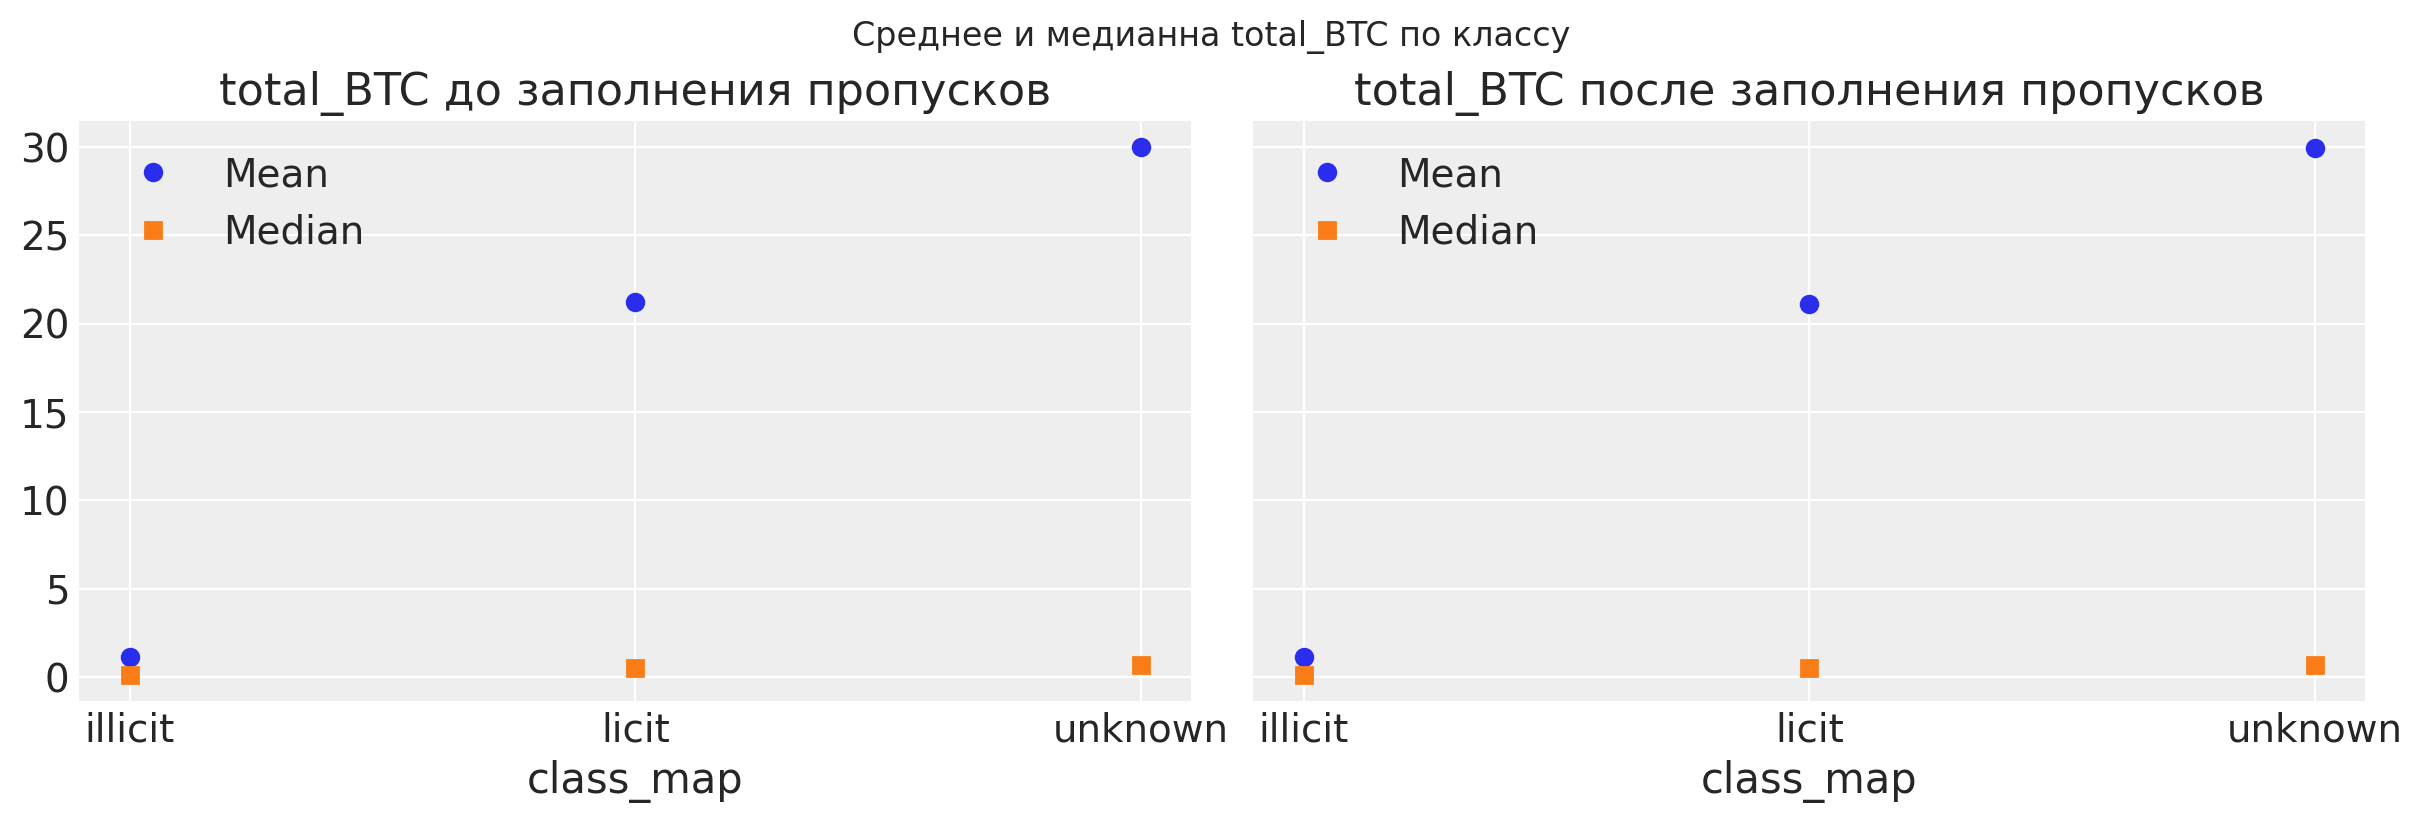

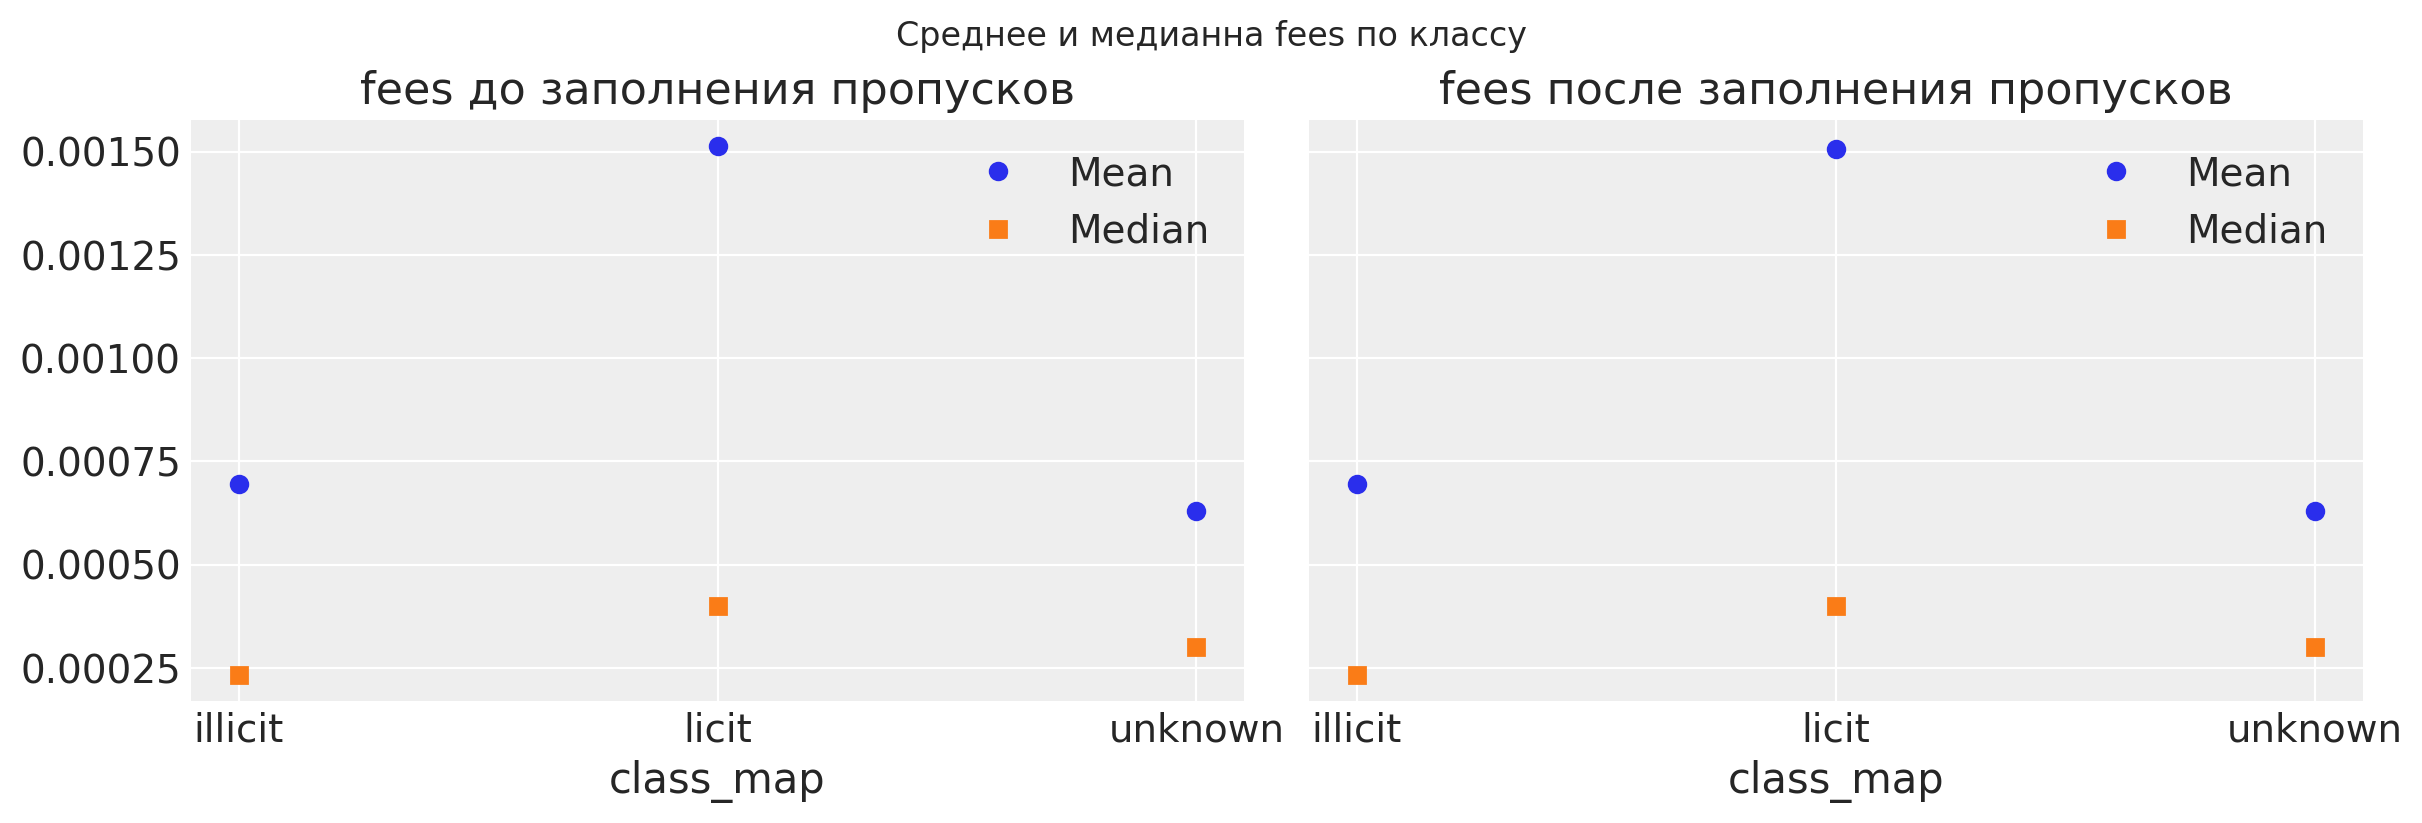

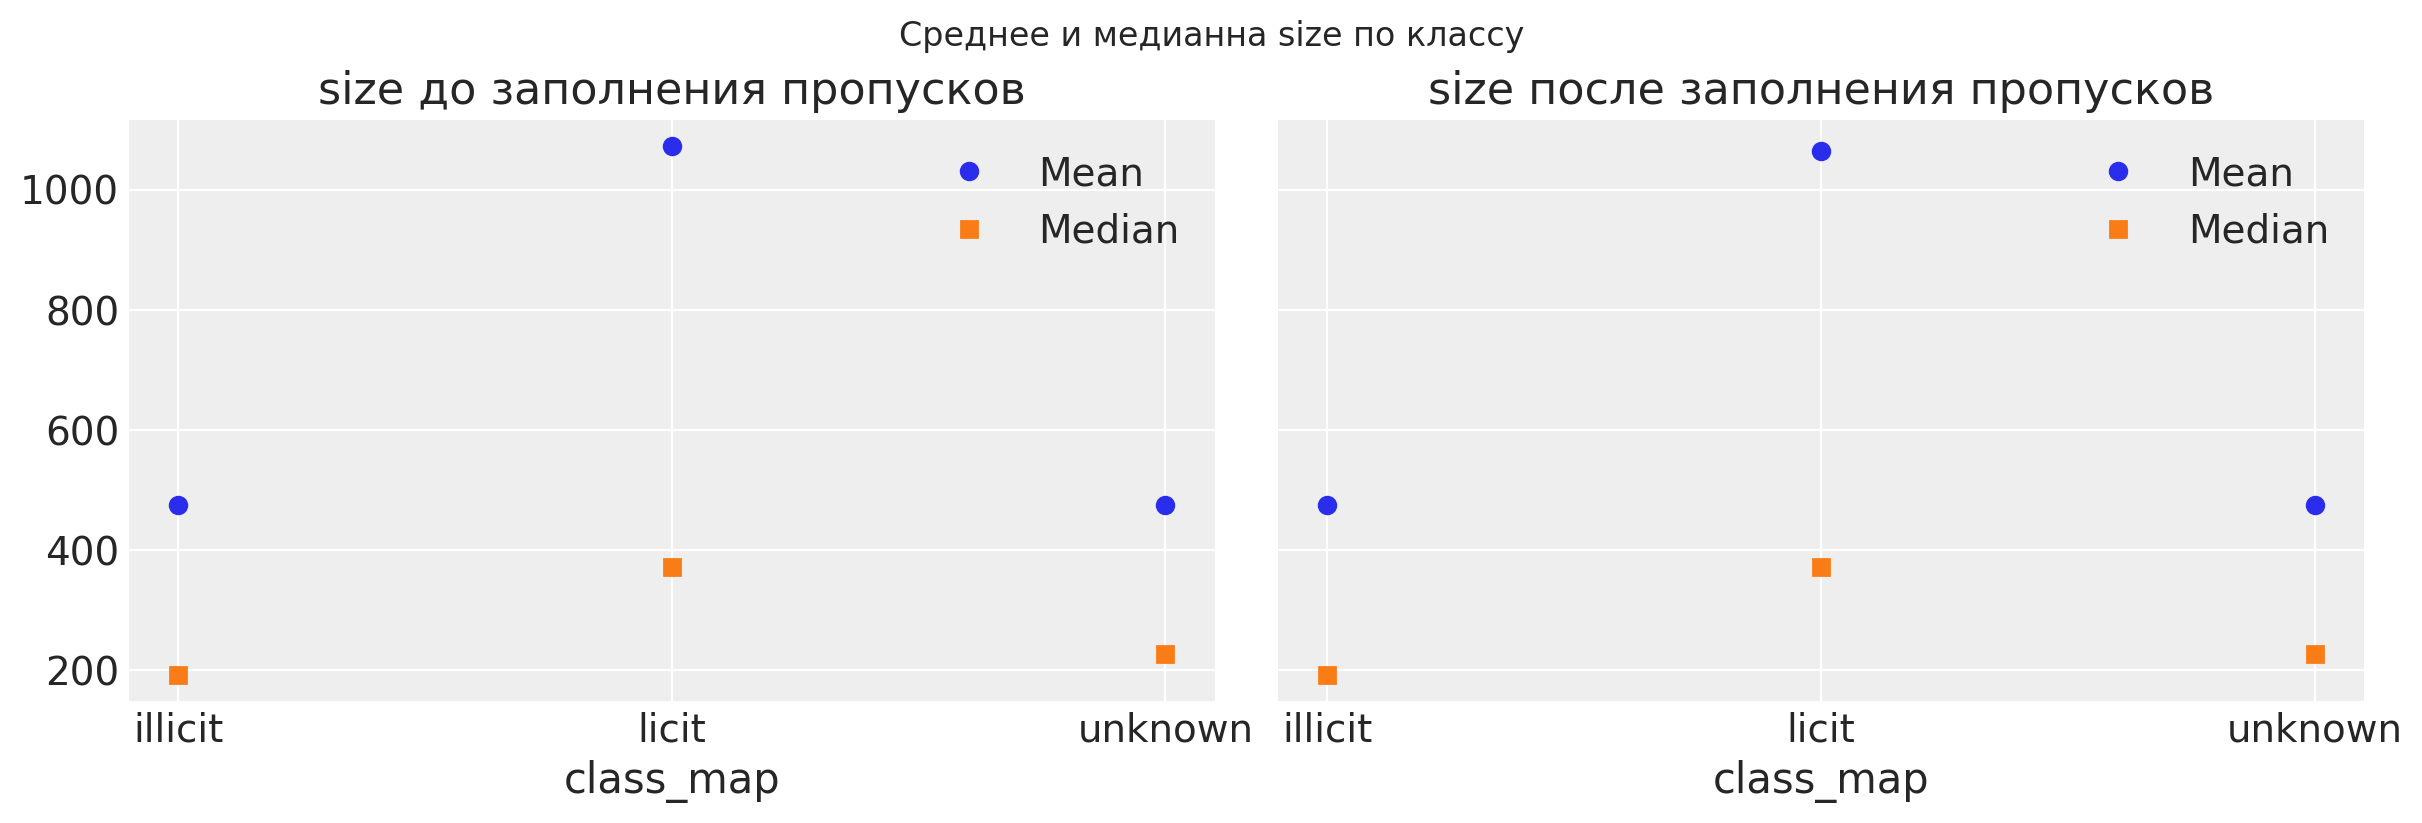

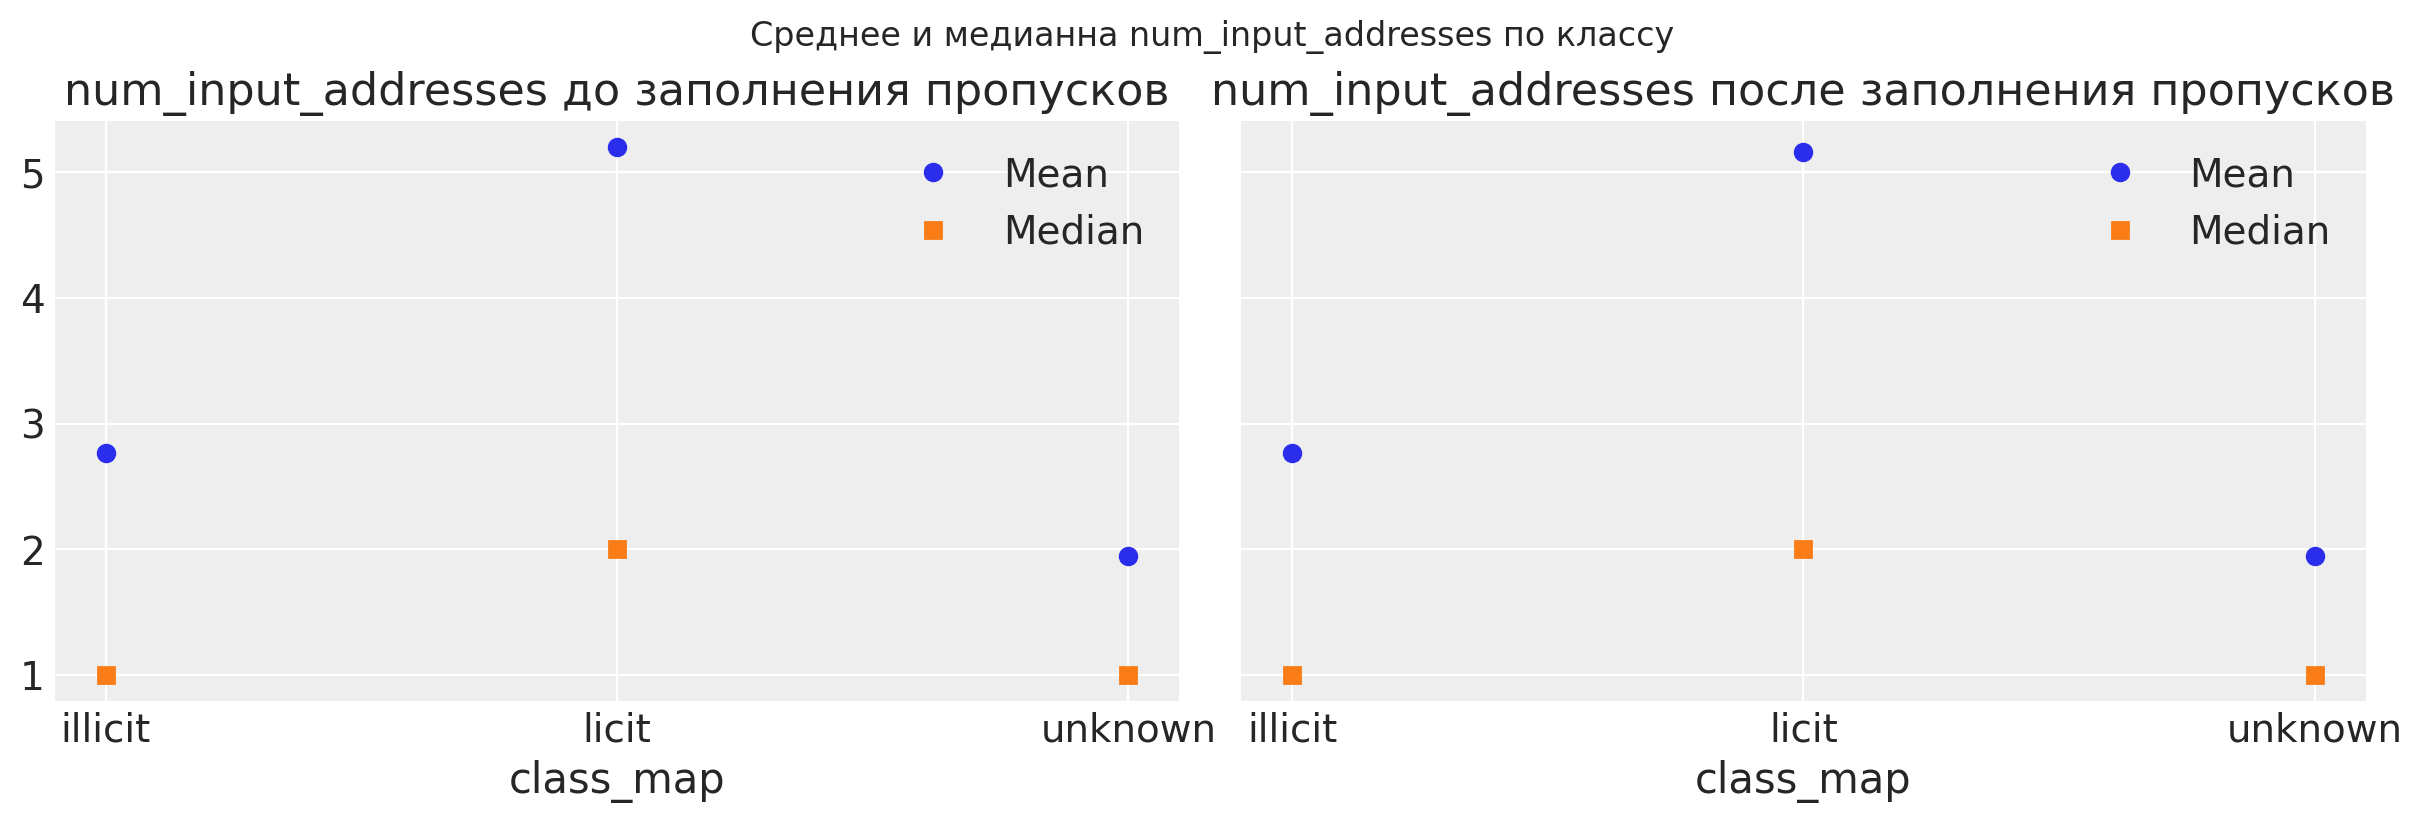

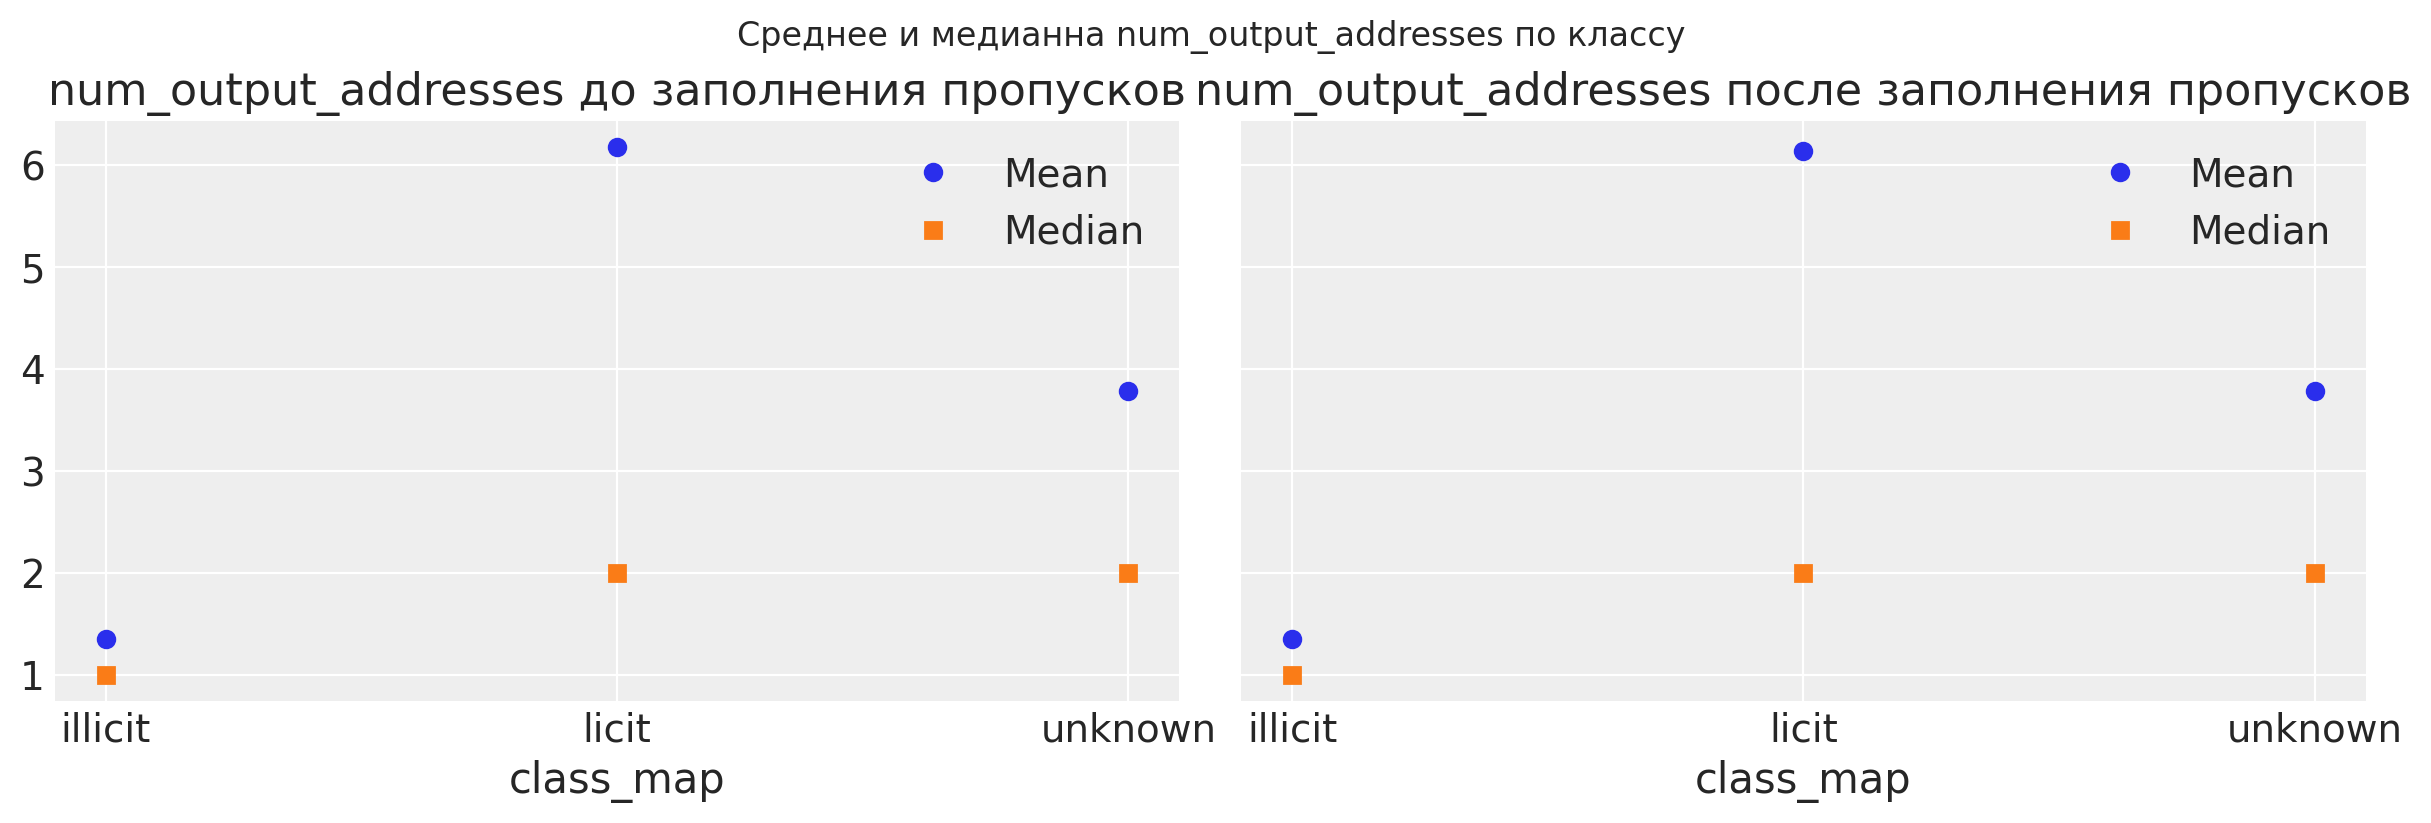

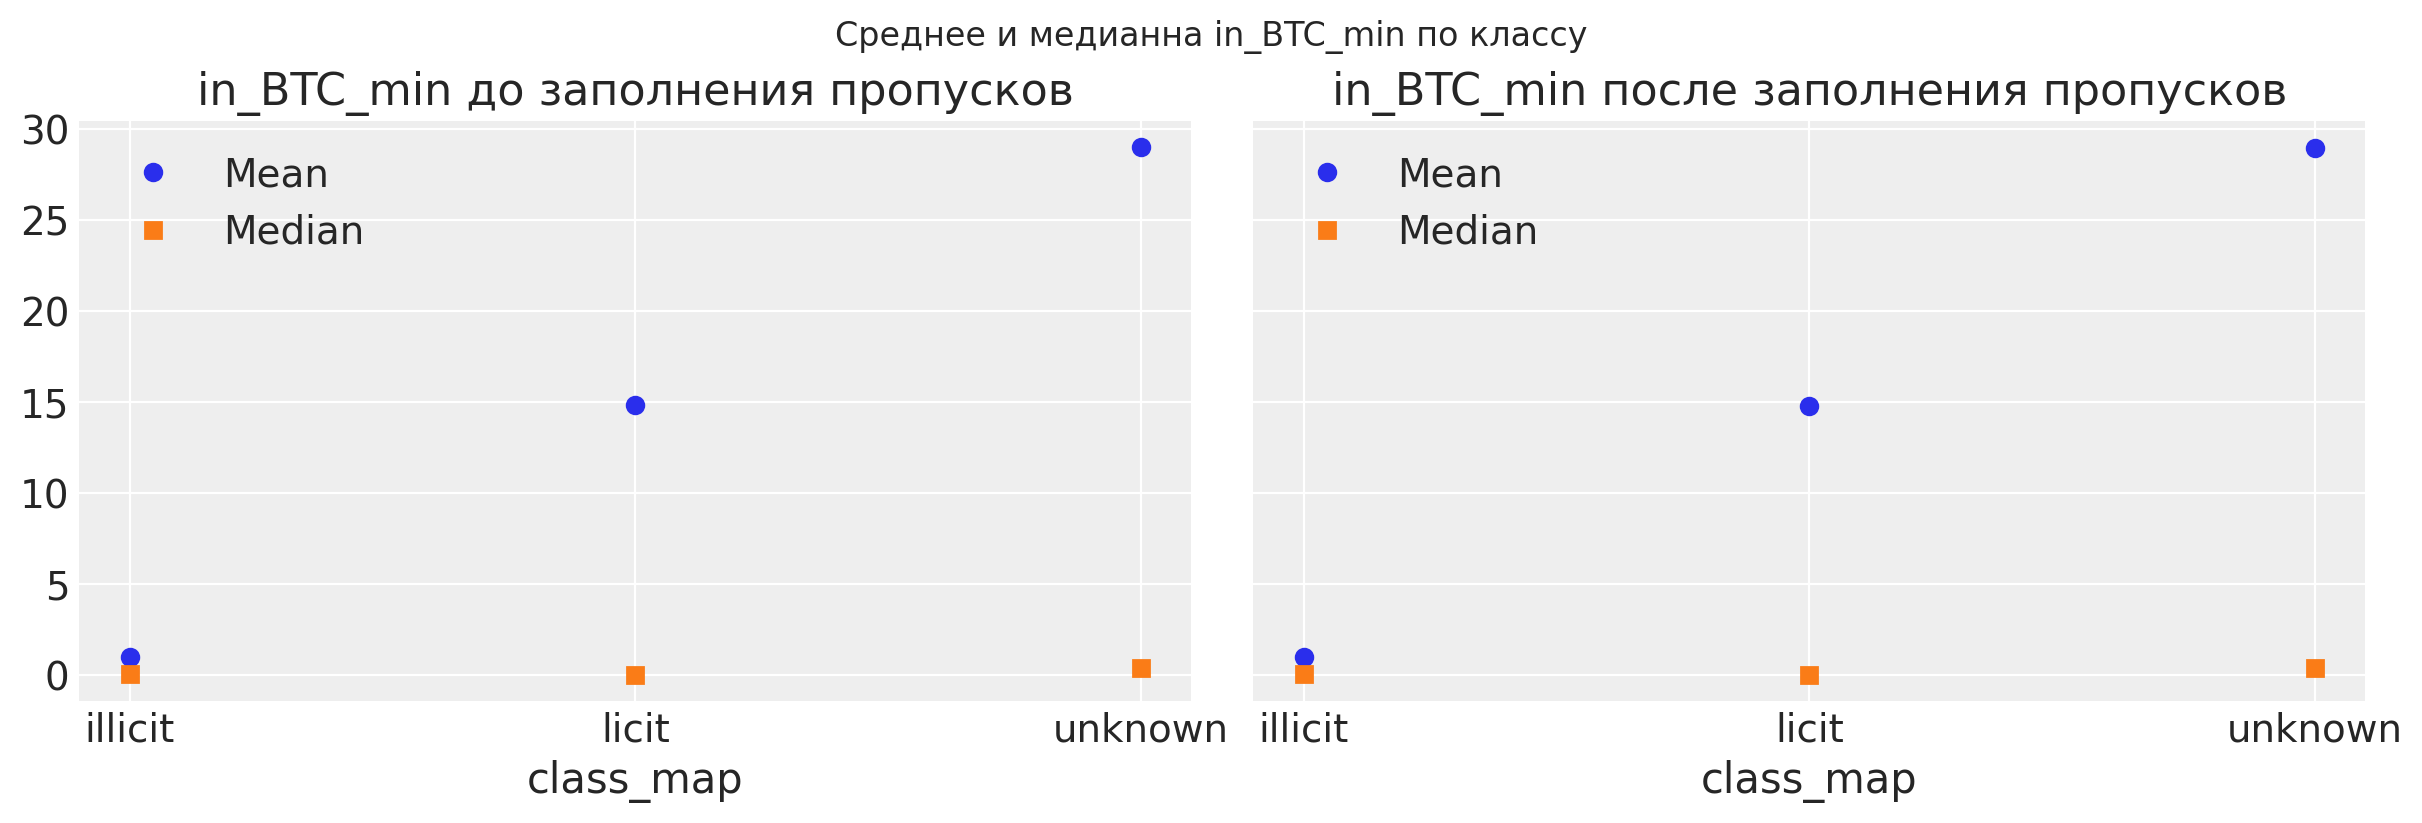

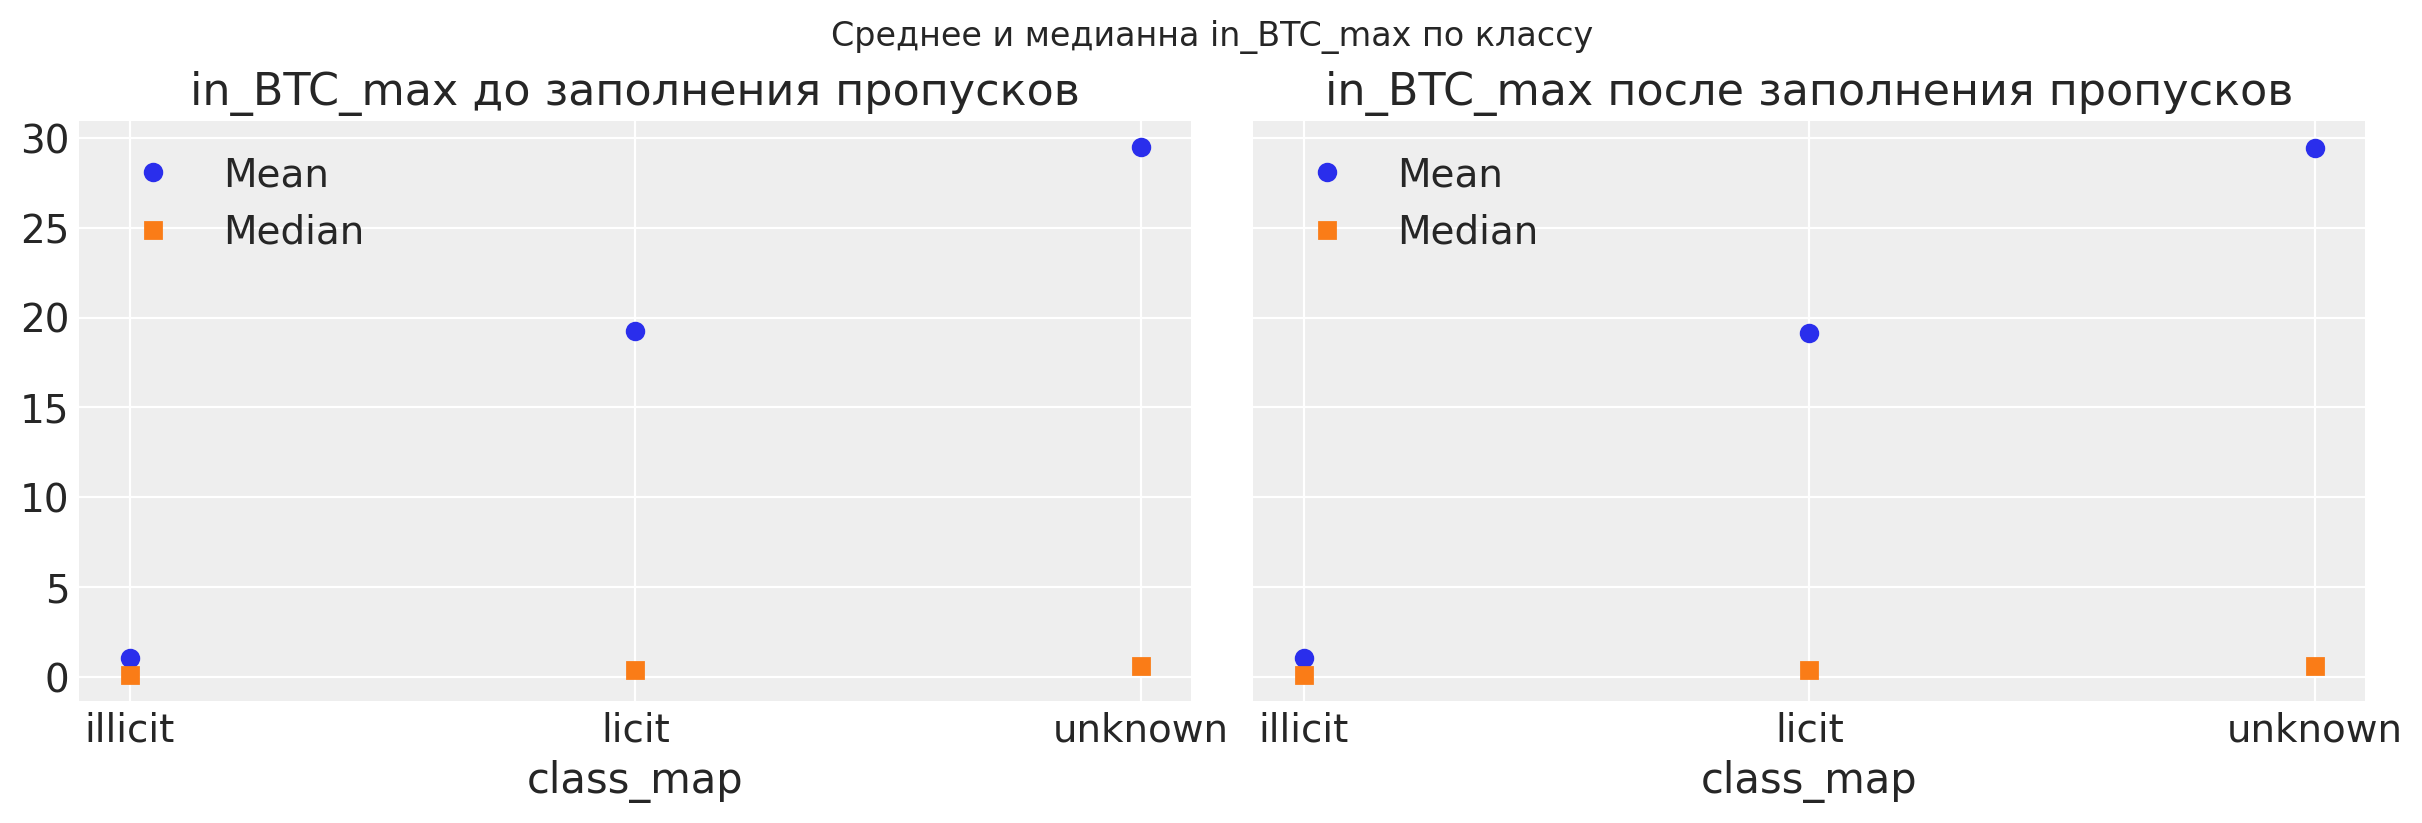

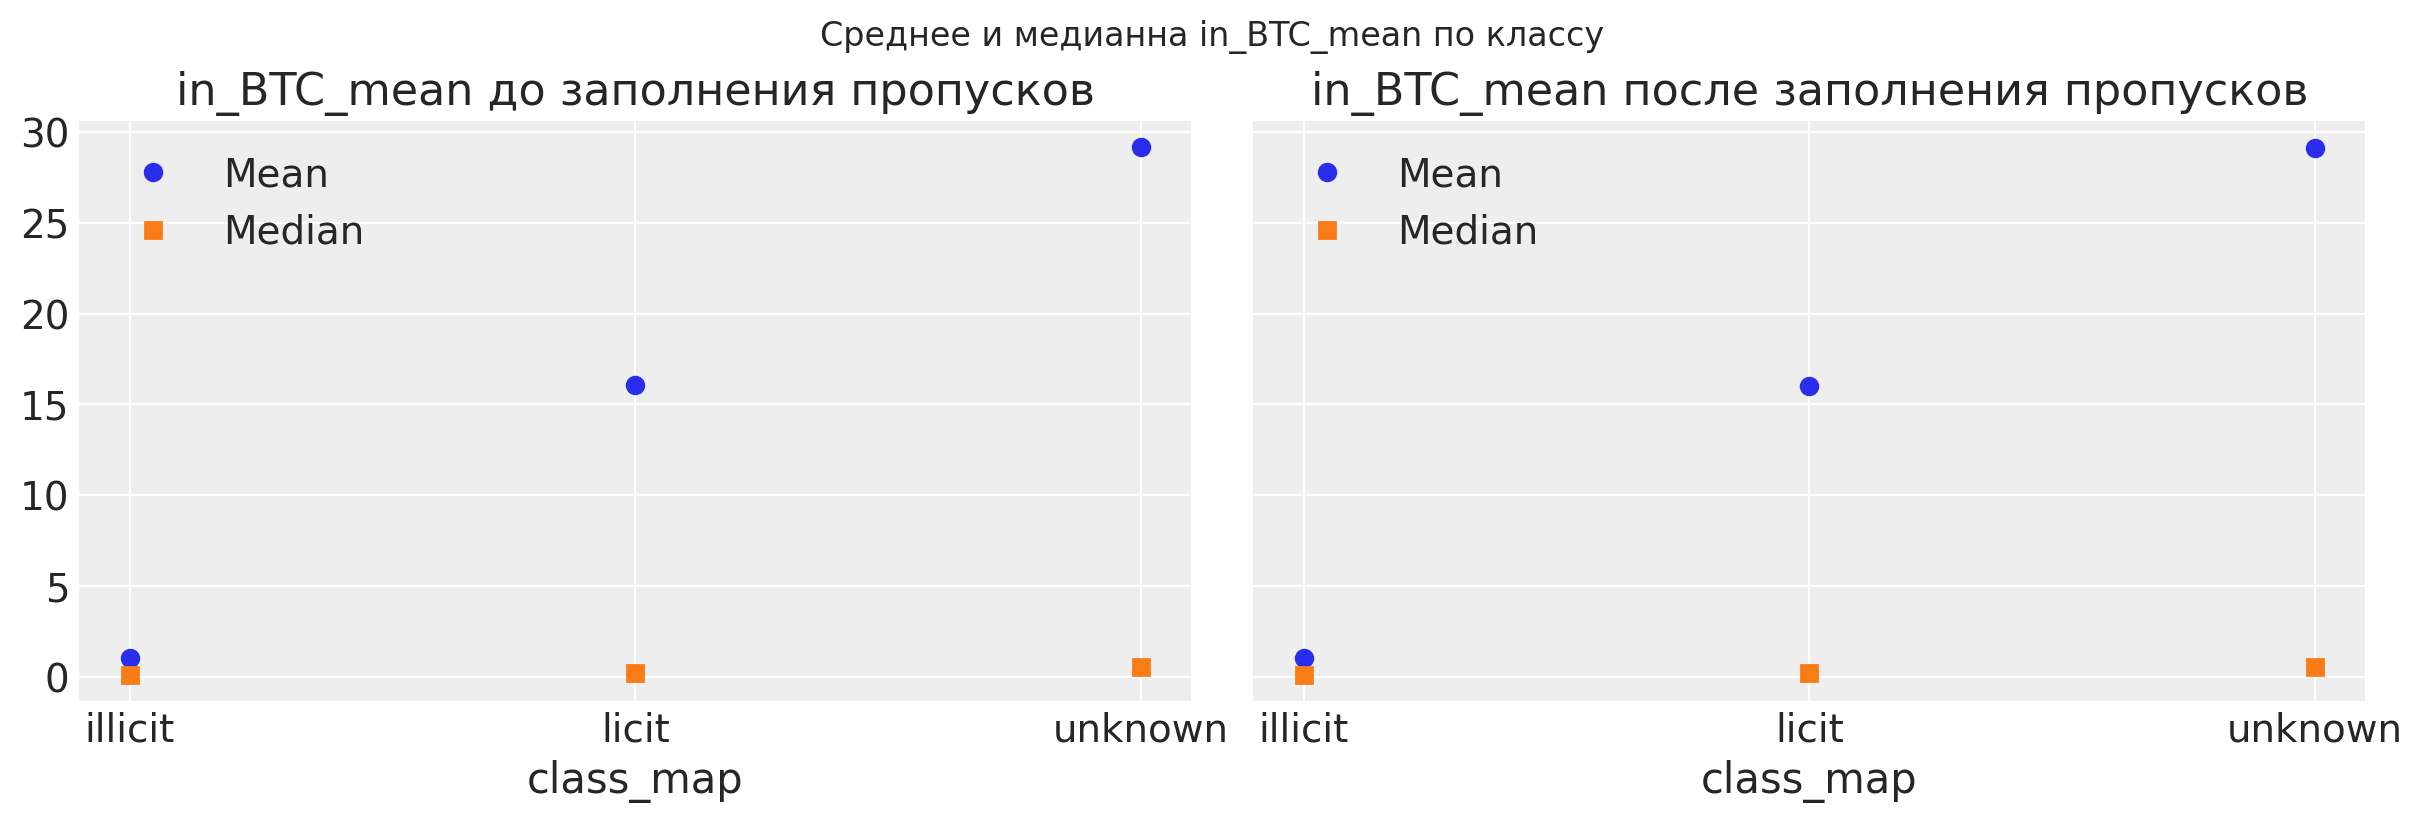

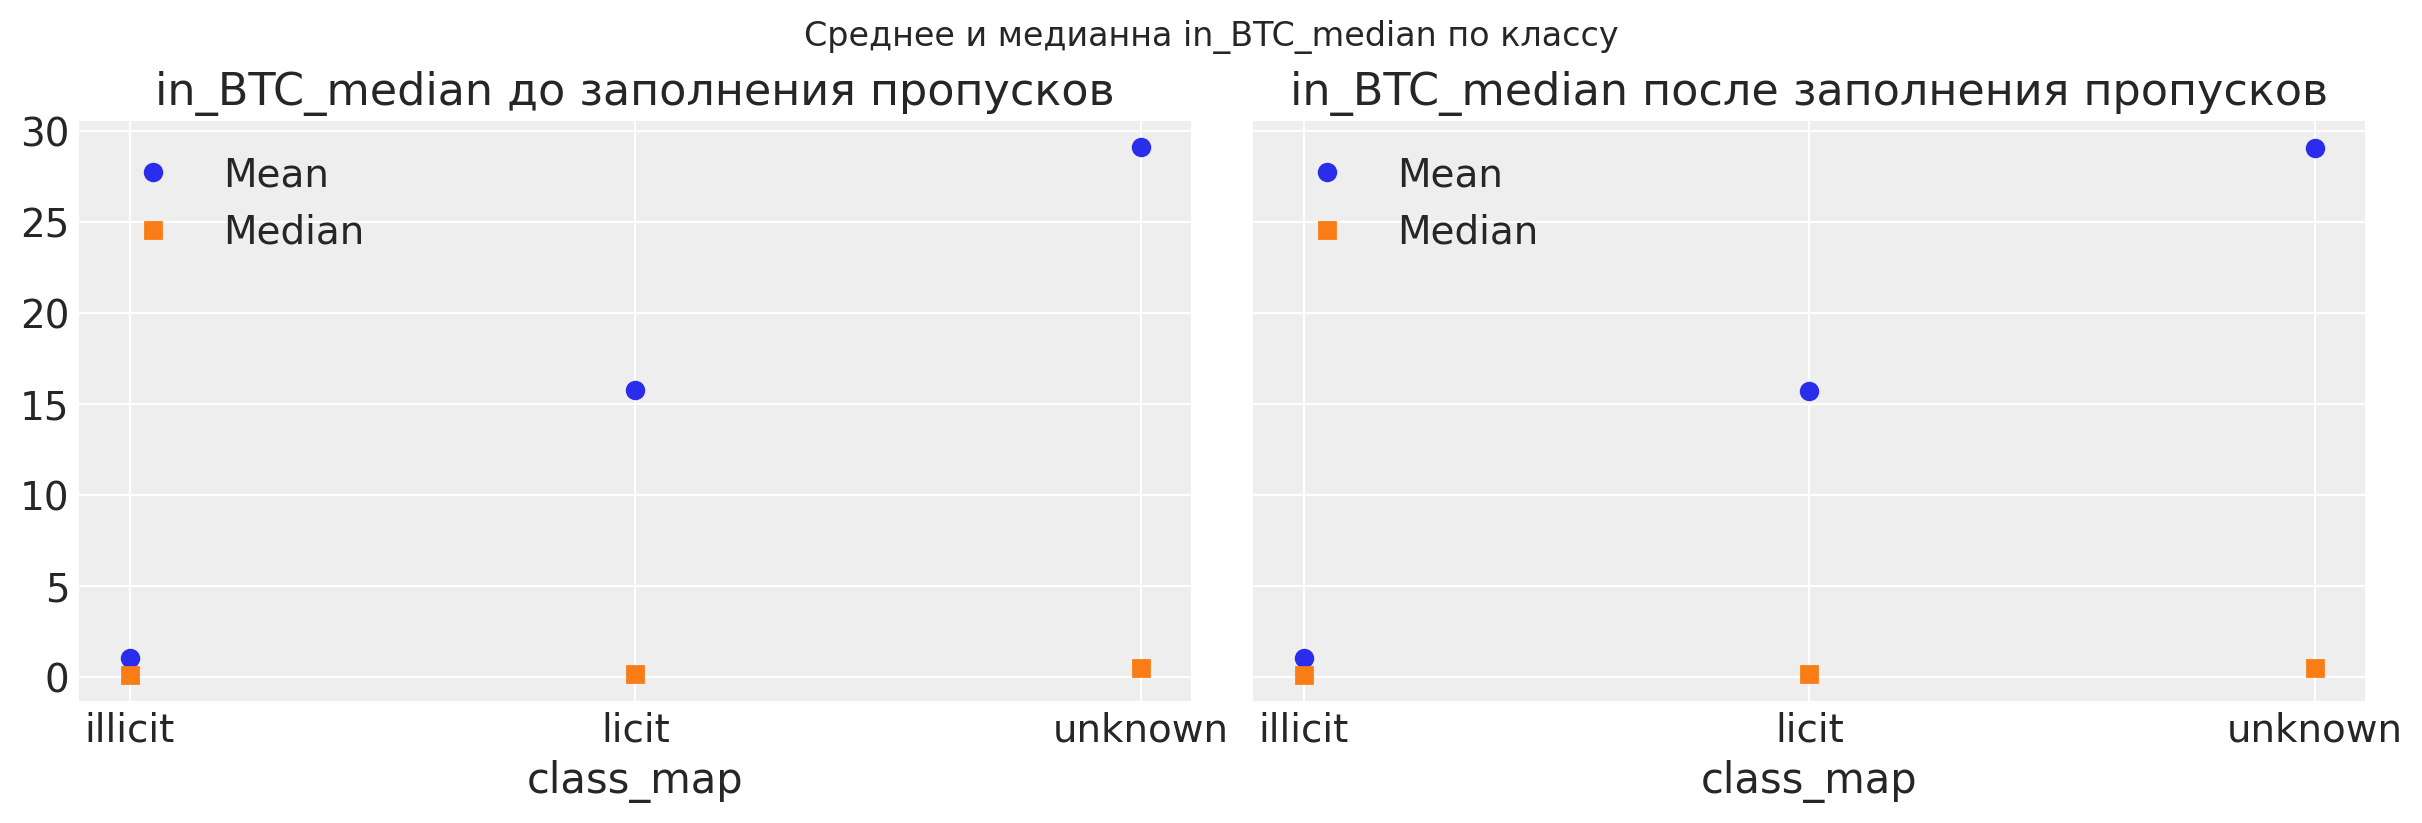

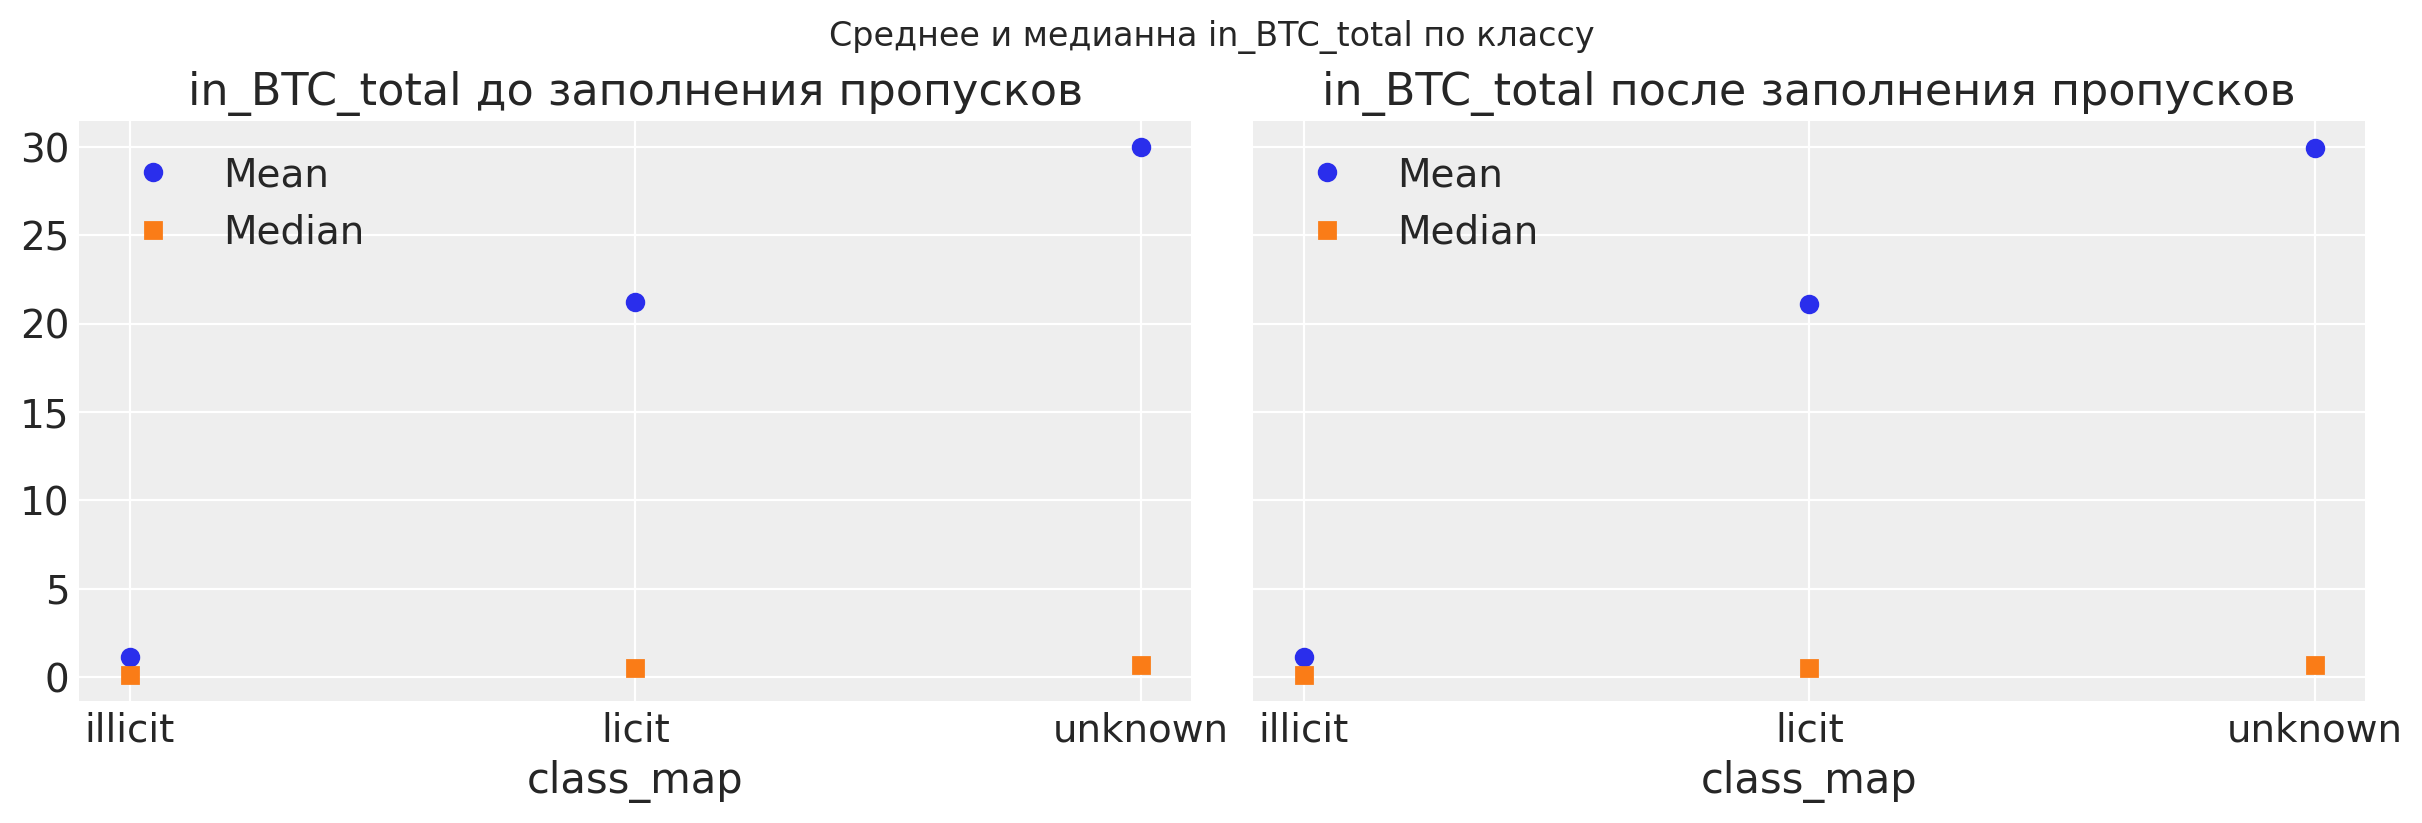

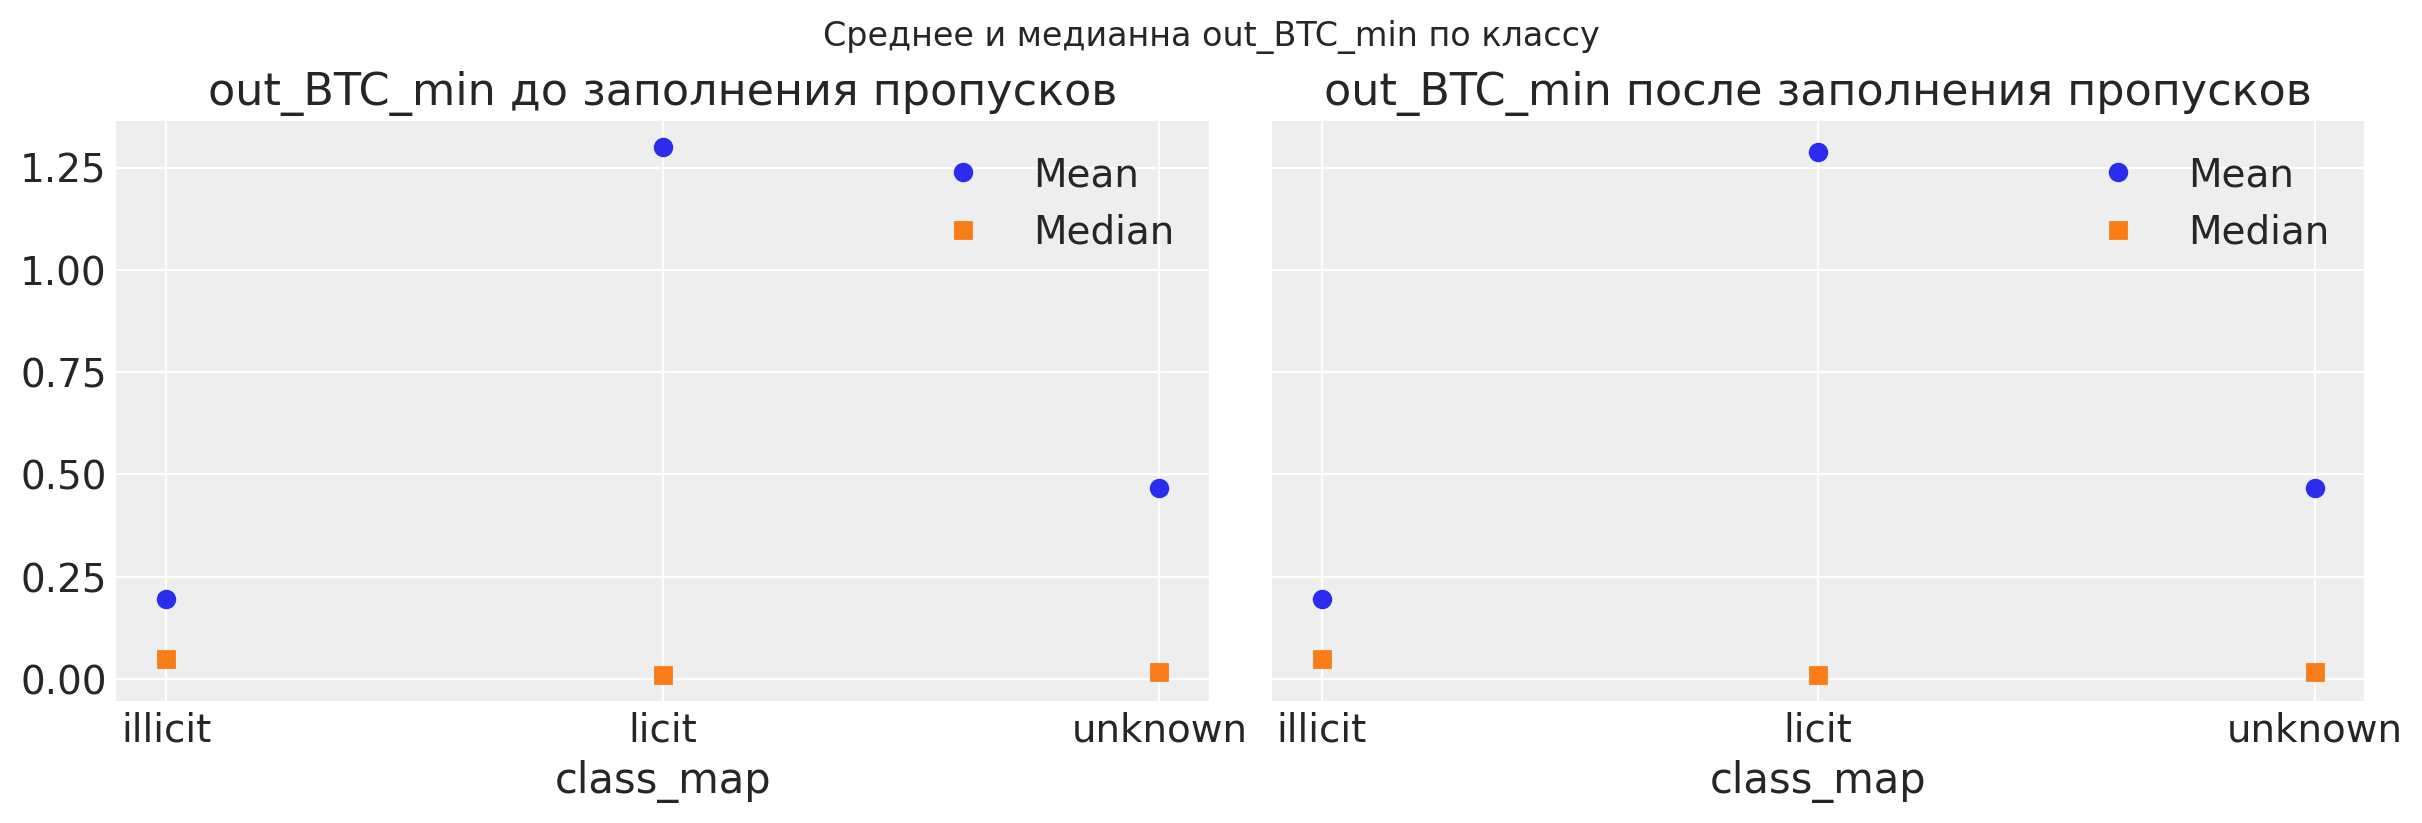

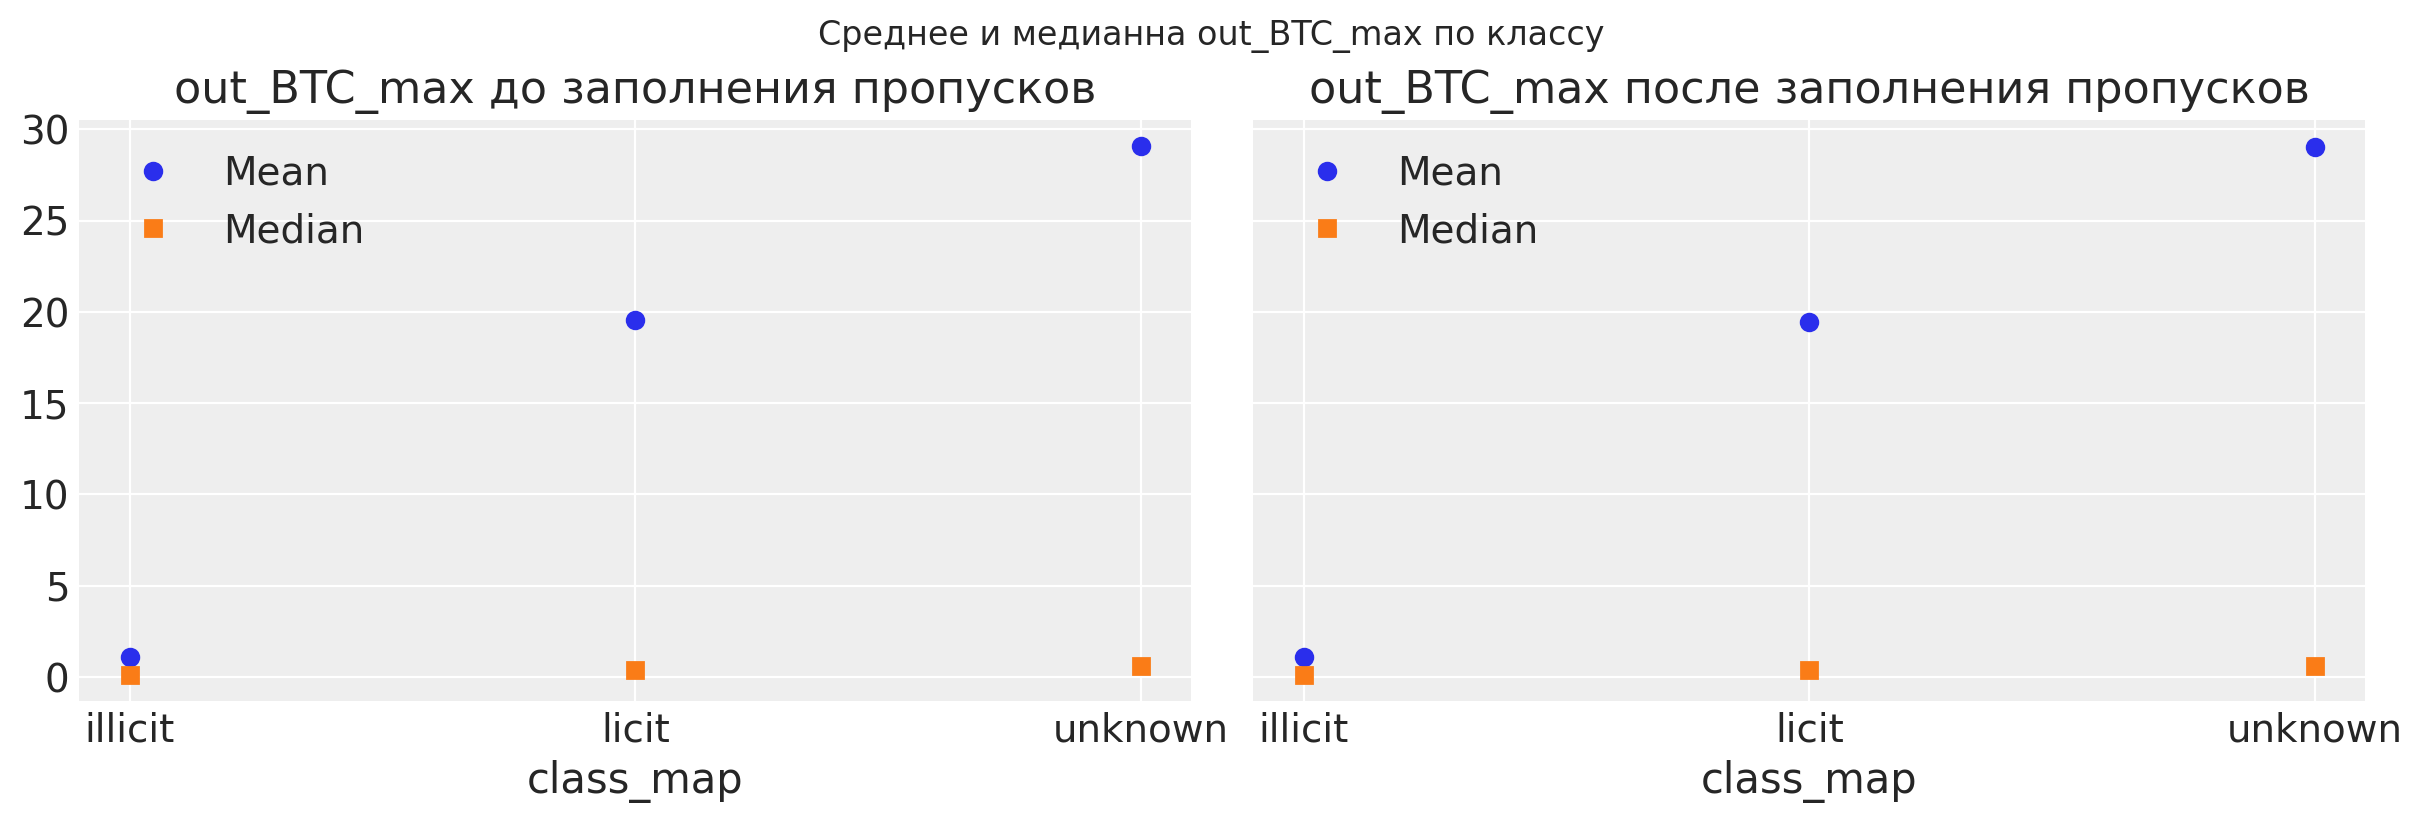

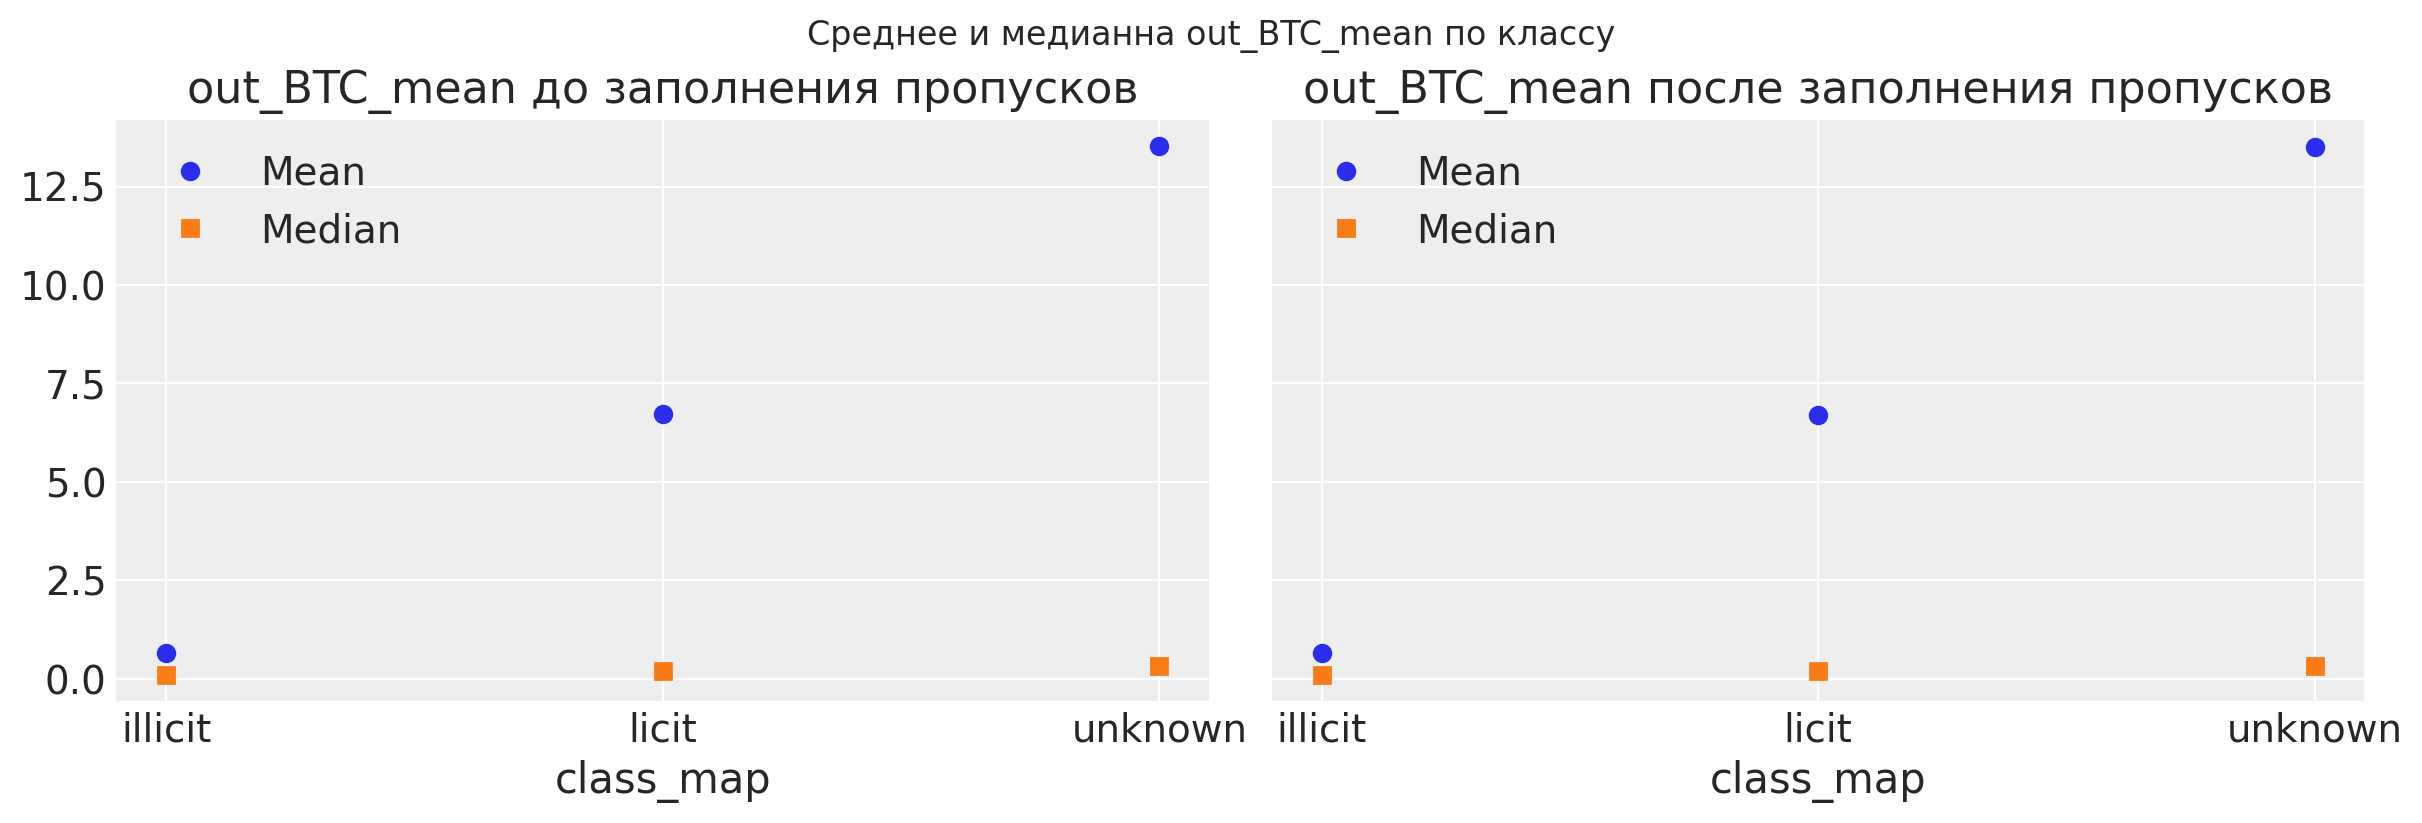

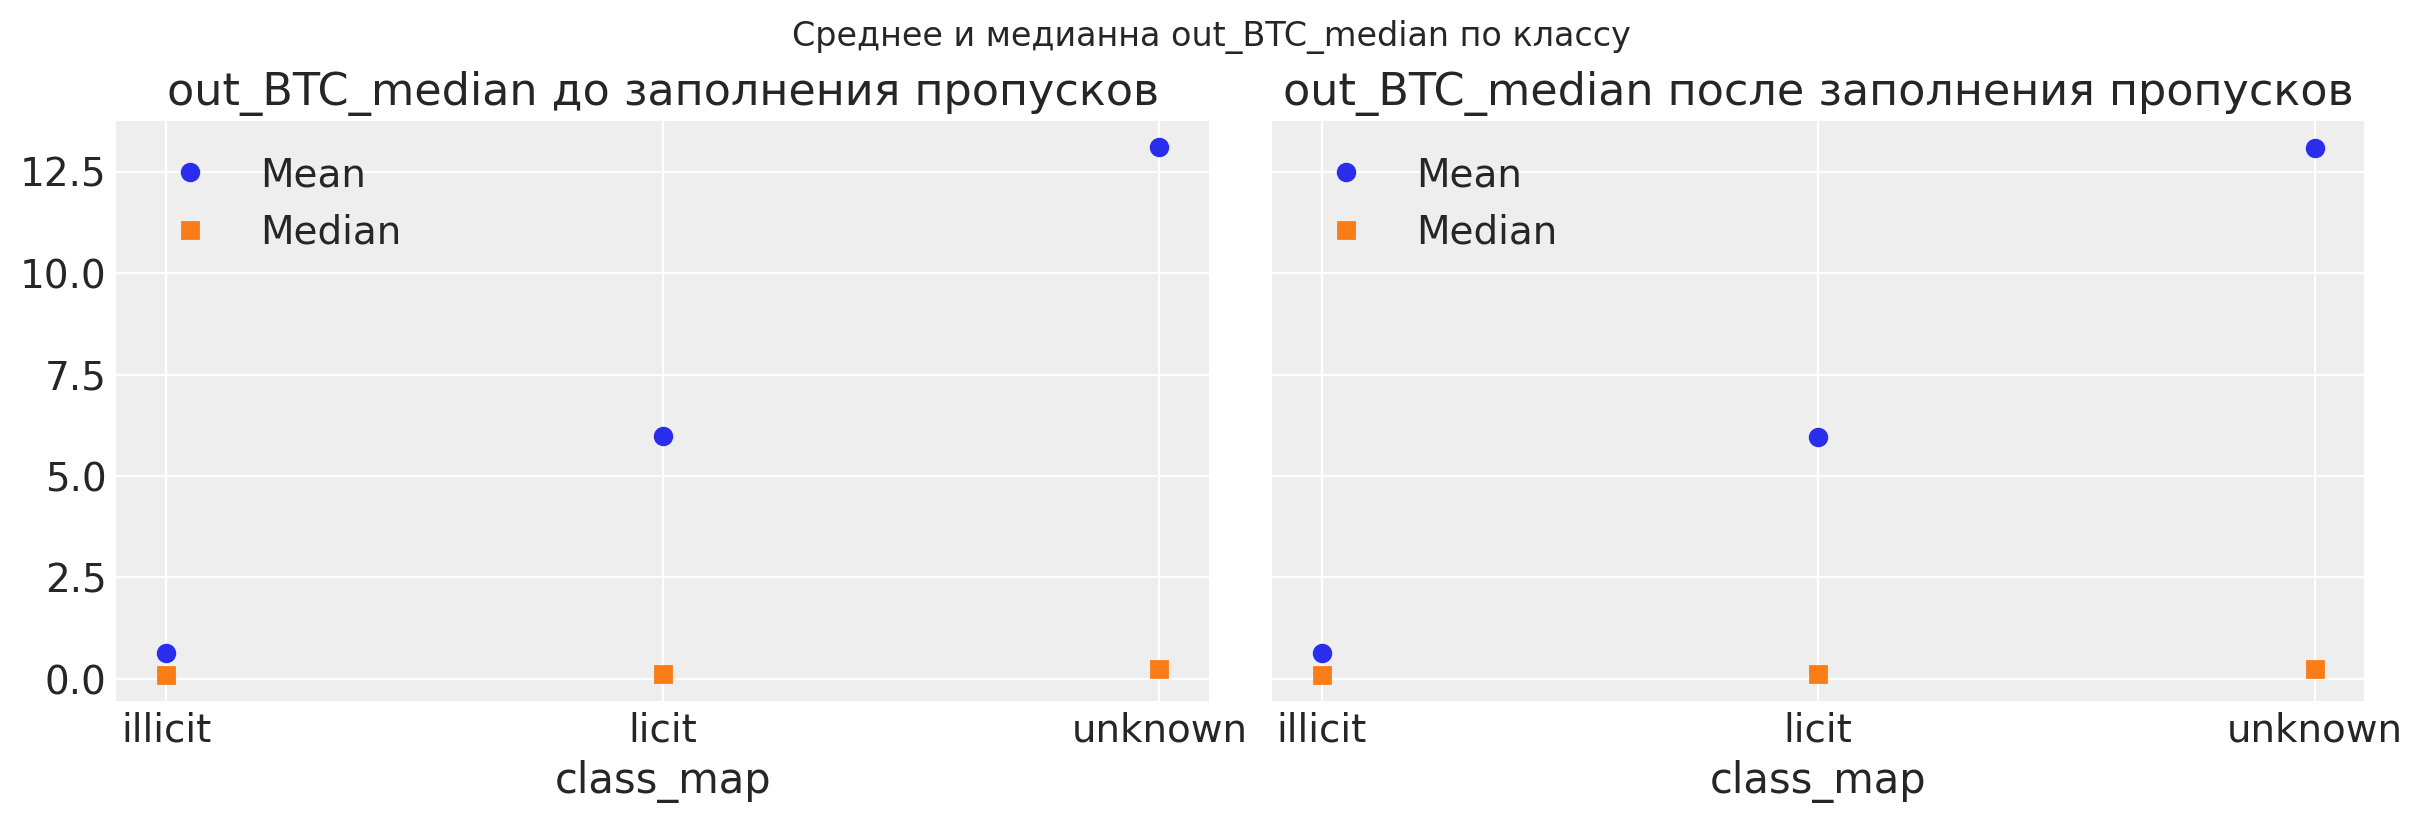

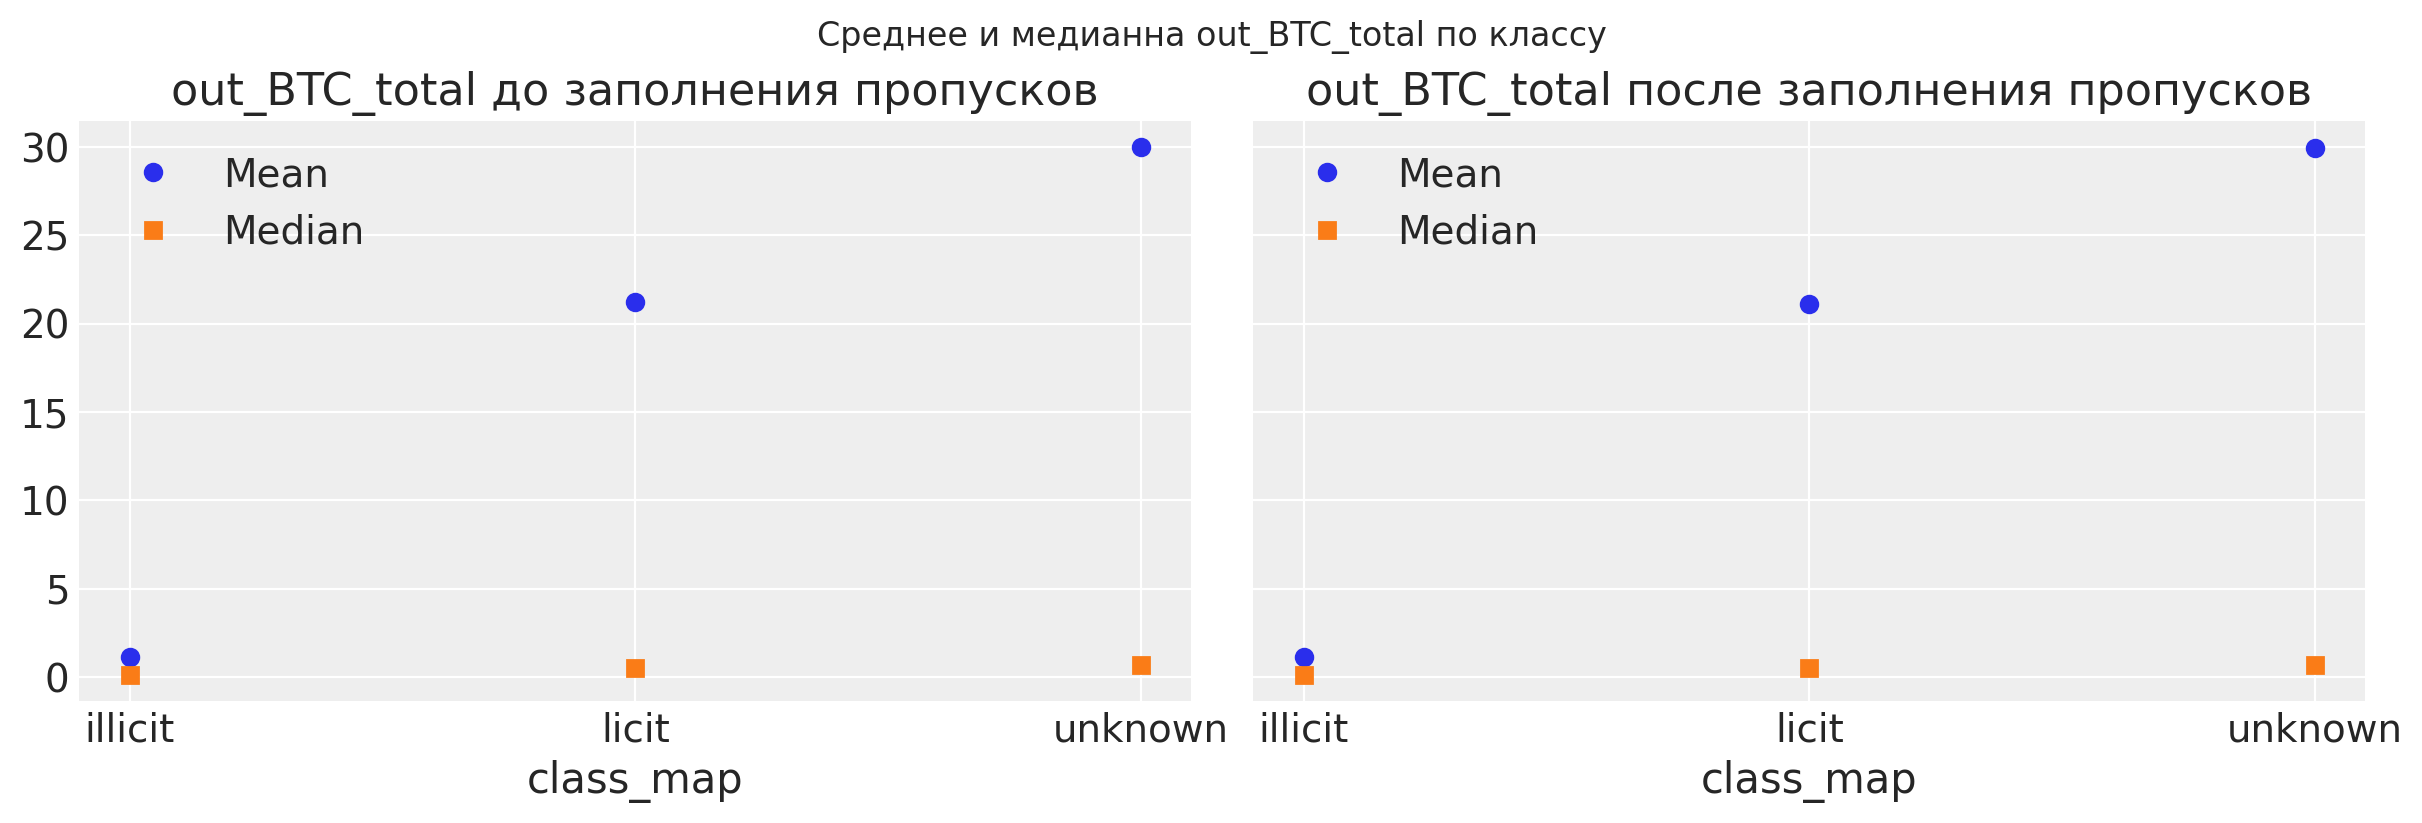

feature class_map  mean_pct_change  median_pct_change
0          in_txs_degree   illicit         0.000000           0.000000
1          in_txs_degree     licit        -0.614931           0.000000
2          in_txs_degree   unknown        -0.015284           0.000000
3         out_txs_degree   illicit         0.000000           0.000000
4         out_txs_degree     licit        -0.202606           0.000000
5         out_txs_degree   unknown         0.002475           0.000000
6              total_BTC   illicit         0.000000           0.000000
7              total_BTC     licit        -0.532292           1.648019
8              total_BTC   unknown        -0.156879           0.169953
9                   fees   illicit         0.000000           0.000000
10                  fees     licit        -0.340797           0.000000
11                  fees   unknown         0.044717           0.000000
12                  size   illicit         0.000000           0.000000
13                  size     licit        -0.719979           0.000000
14                  size   unknown         0.030609           0.000000
15   num_input_addresses   illicit         0.000000           0.000000
16   num_input_addresses     licit        -0.759481           0.000000
17   num_input_addresses   unknown         0.005597           0.000000
18  num_output_addresses   illicit         0.000000           0.000000
19  num_output_addresses     licit        -0.650518           0.000000
20  num_output_addresses   unknown         0.125849           0.000000
21            in_BTC_min   illicit         0.000000           0.000000
22            in_BTC_min     licit        -0.322052           6.808951
23            in_BTC_min   unknown        -0.166823           0.159120
24            in_BTC_max   illicit         0.000000           0.000000
25            in_BTC_max     licit        -0.481762           2.150021
26            in_BTC_max   unknown        -0.162307           0.282812
27           in_BTC_mean   illicit         0.000000           0.000000
28           in_BTC_mean     licit        -0.375308           2.758121
29           in_BTC_mean   unknown        -0.164924           0.152617
30         in_BTC_median   illicit         0.000000           0.000000
31         in_BTC_median     licit        -0.363709           2.680962
32         in_BTC_median   unknown        -0.164915           0.125527
33          in_BTC_total   illicit         0.000000           0.000000
34          in_BTC_total     licit        -0.532279           1.627136
35          in_BTC_total   unknown        -0.156875           0.131223
36           out_BTC_min   illicit         0.000000           0.000000
37           out_BTC_min     licit        -0.848387           0.730780
38           out_BTC_min   unknown        -0.001937           0.423426
39           out_BTC_max   illicit         0.000000           0.000000
40           out_BTC_max     licit        -0.515871           1.486486
41           out_BTC_max   unknown        -0.160892           0.141200
42          out_BTC_mean   illicit         0.000000           0.000000
43          out_BTC_mean     licit        -0.397038           1.554269
44          out_BTC_mean   unknown        -0.173512           0.042178
45        out_BTC_median   illicit         0.000000           0.000000
46        out_BTC_median     licit        -0.376112           1.492810
47        out_BTC_median   unknown        -0.183179          -0.023575
48         out_BTC_total   illicit         0.000000           0.000000
49         out_BTC_total     licit        -0.532292           1.648019
50         out_BTC_total   unknown        -0.156879           0.169953

In [27]:
results = []

for col in missing_tx.index:
    stats_before = df_transactions.groupby('class_map')[col].agg(['mean', 'median'])
    stats_after  = df_transactions_filled.groupby('class_map')[col].agg(['mean', 'median'])
    
    pct_change = ((stats_after - stats_before) / stats_before * 100).reset_index()
    pct_change['feature'] = col
    results.append(pct_change[['feature', 'class_map', 'mean', 'median']])

    classes = stats_before.index.astype(str)
    x = np.arange(len(classes))
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
    
    axes[0].plot(x, stats_before['mean'],   'o', label='Mean')
    axes[0].plot(x, stats_before['median'], 's', label='Median')
    axes[0].set_xticks(x); axes[0].set_xticklabels(classes)
    axes[0].set_title(f"{col} до заполнения пропусков"); axes[0].set_xlabel('class_map')
    axes[0].legend()
    
    axes[1].plot(x, stats_after['mean'],   'o', label='Mean')
    axes[1].plot(x, stats_after['median'], 's', label='Median')
    axes[1].set_xticks(x); axes[1].set_xticklabels(classes)
    axes[1].set_title(f"{col} после заполнения пропусков"); axes[1].set_xlabel('class_map')
    axes[1].legend()
    
    fig.subplots_adjust(top=0.85, wspace=0.3)
    plt.suptitle(f"Среднее и медианна {col} по классу")
    plt.show()

summary_df = pd.concat(results, ignore_index=True)
summary_df.rename(columns={'mean': 'mean_pct_change', 'median': 'median_pct_change'}, inplace=True)
summary_df


Как можно заметить распределение классов не сильно поменялось в среднем и по медиане. Рассмотрим подробнее распределения по каждой из фич по заполненным данным без дополнительных фич Elliptic

In [28]:
import seaborn as sns

In [29]:
df_transactions_filled_nf = df_transactions_filled.drop(columns=local_agg_features)

In [30]:
agg_cols = [
    col for col in df_transactions_filled_nf.columns
    if col not in ('txId', 'class_map', 'Time step', 'class')
]

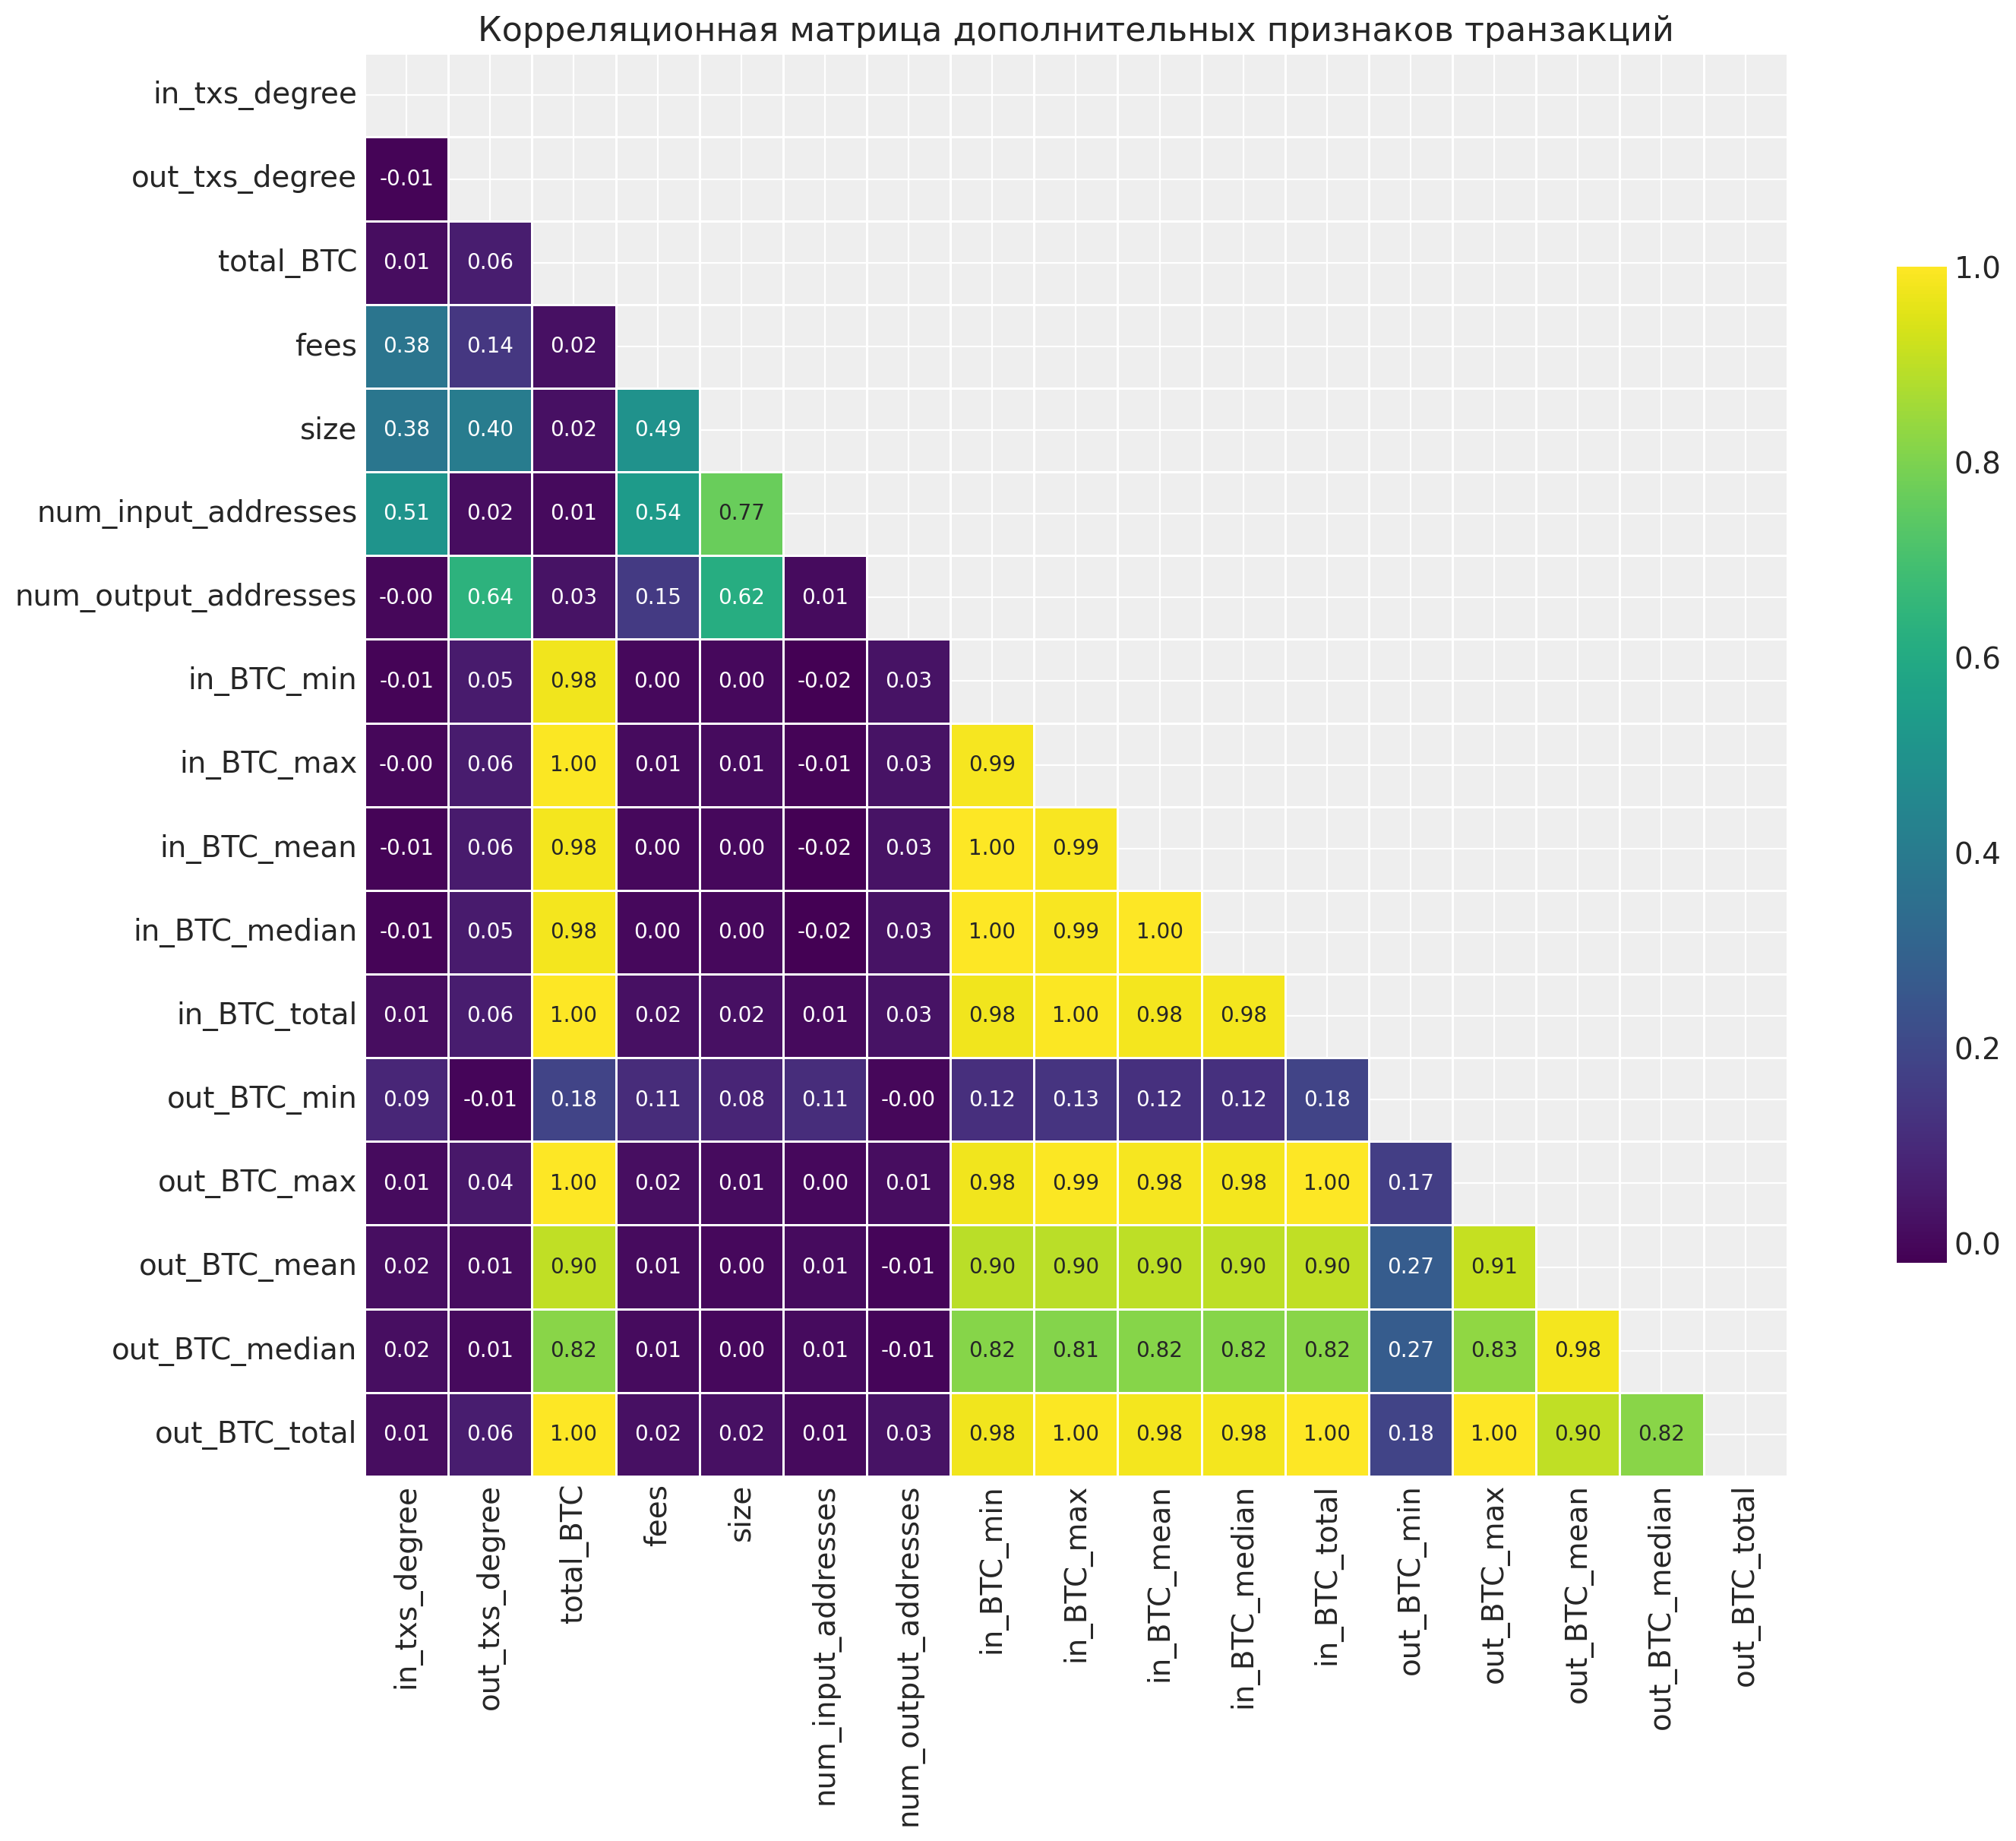

In [31]:
correlation_matrix = df_transactions_filled[agg_cols].corr()

fig, ax = plt.subplots(figsize=(16, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(
    correlation_matrix, mask=mask, cmap='viridis',
    annot=True, fmt='.2f', square=True, linewidths=.5,
    cbar_kws={"shrink": .7}, ax=ax
)
ax.set_title('Корреляционная матрица дополнительных признаков транзакций', fontsize=16)

fig.subplots_adjust(
    top=0.93,    
    bottom=0.05, 
    left=0.05,  
    right=0.95 
)

plt.show()


In [32]:
high_correlations = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            high_correlations.append((
                correlation_matrix.columns[i], 
                correlation_matrix.columns[j], 
                correlation_matrix.iloc[i, j]
            ))

print("Сильно коррелирующие признаки (|r| > 0.8):")
for feat1, feat2, corr in sorted(high_correlations, key=lambda x: abs(x[2]), reverse=True):
    print(f"{feat1} и {feat2}: {corr:.3f}")

Сильно коррелирующие признаки (|r| > 0.8):
total_BTC и out_BTC_total: 1.000
total_BTC и in_BTC_total: 1.000
in_BTC_total и out_BTC_total: 1.000
in_BTC_mean и in_BTC_median: 1.000
in_BTC_min и in_BTC_median: 0.999
in_BTC_min и in_BTC_mean: 0.999
total_BTC и out_BTC_max: 0.996
out_BTC_max и out_BTC_total: 0.996
in_BTC_total и out_BTC_max: 0.996
total_BTC и in_BTC_max: 0.995
in_BTC_max и out_BTC_total: 0.995
in_BTC_max и in_BTC_total: 0.995
in_BTC_max и out_BTC_max: 0.995
in_BTC_max и in_BTC_mean: 0.990
in_BTC_max и in_BTC_median: 0.989
in_BTC_min и in_BTC_max: 0.985
in_BTC_mean и out_BTC_max: 0.985
total_BTC и in_BTC_mean: 0.983
in_BTC_mean и out_BTC_total: 0.983
in_BTC_mean и in_BTC_total: 0.983
in_BTC_median и out_BTC_max: 0.983
total_BTC и in_BTC_median: 0.982
in_BTC_median и out_BTC_total: 0.982
in_BTC_median и in_BTC_total: 0.982
out_BTC_mean и out_BTC_median: 0.981
in_BTC_min и out_BTC_max: 0.980
total_BTC и in_BTC_min: 0.978
in_BTC_min и out_BTC_total: 0.978
in_BTC_min и in_BTC_to

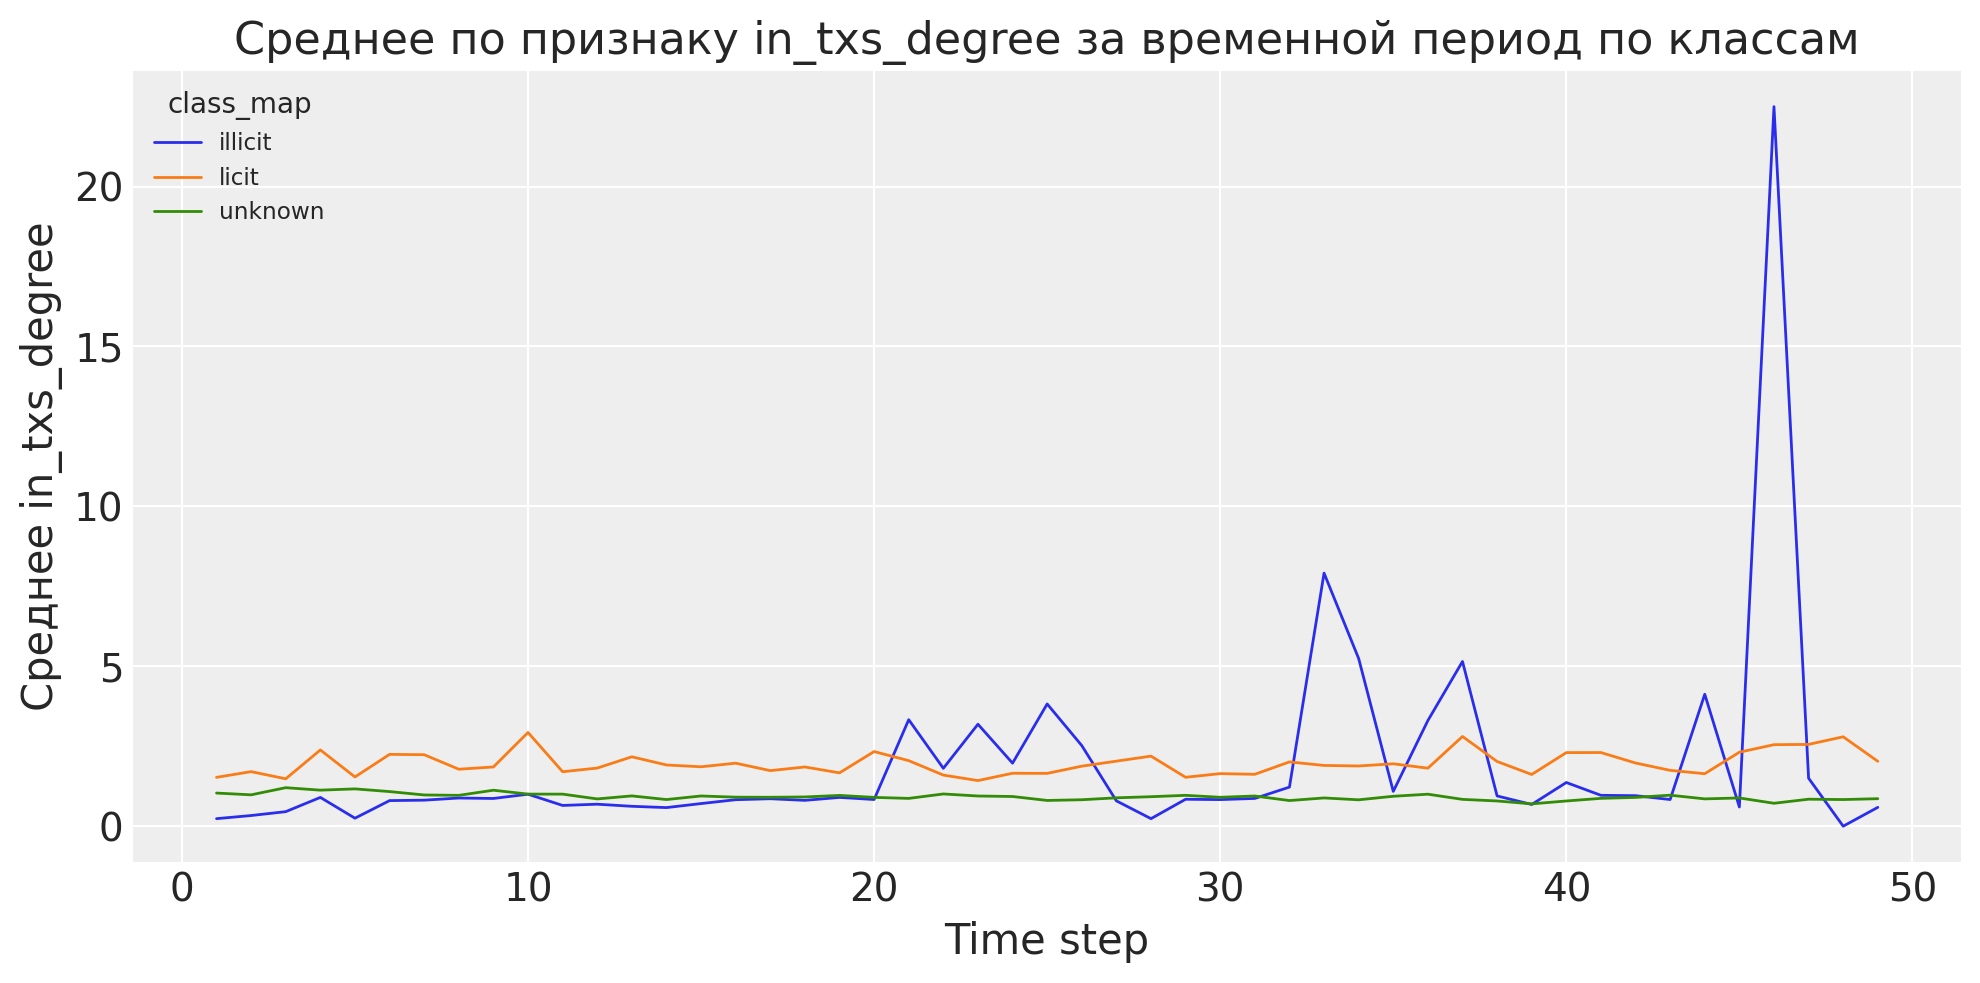

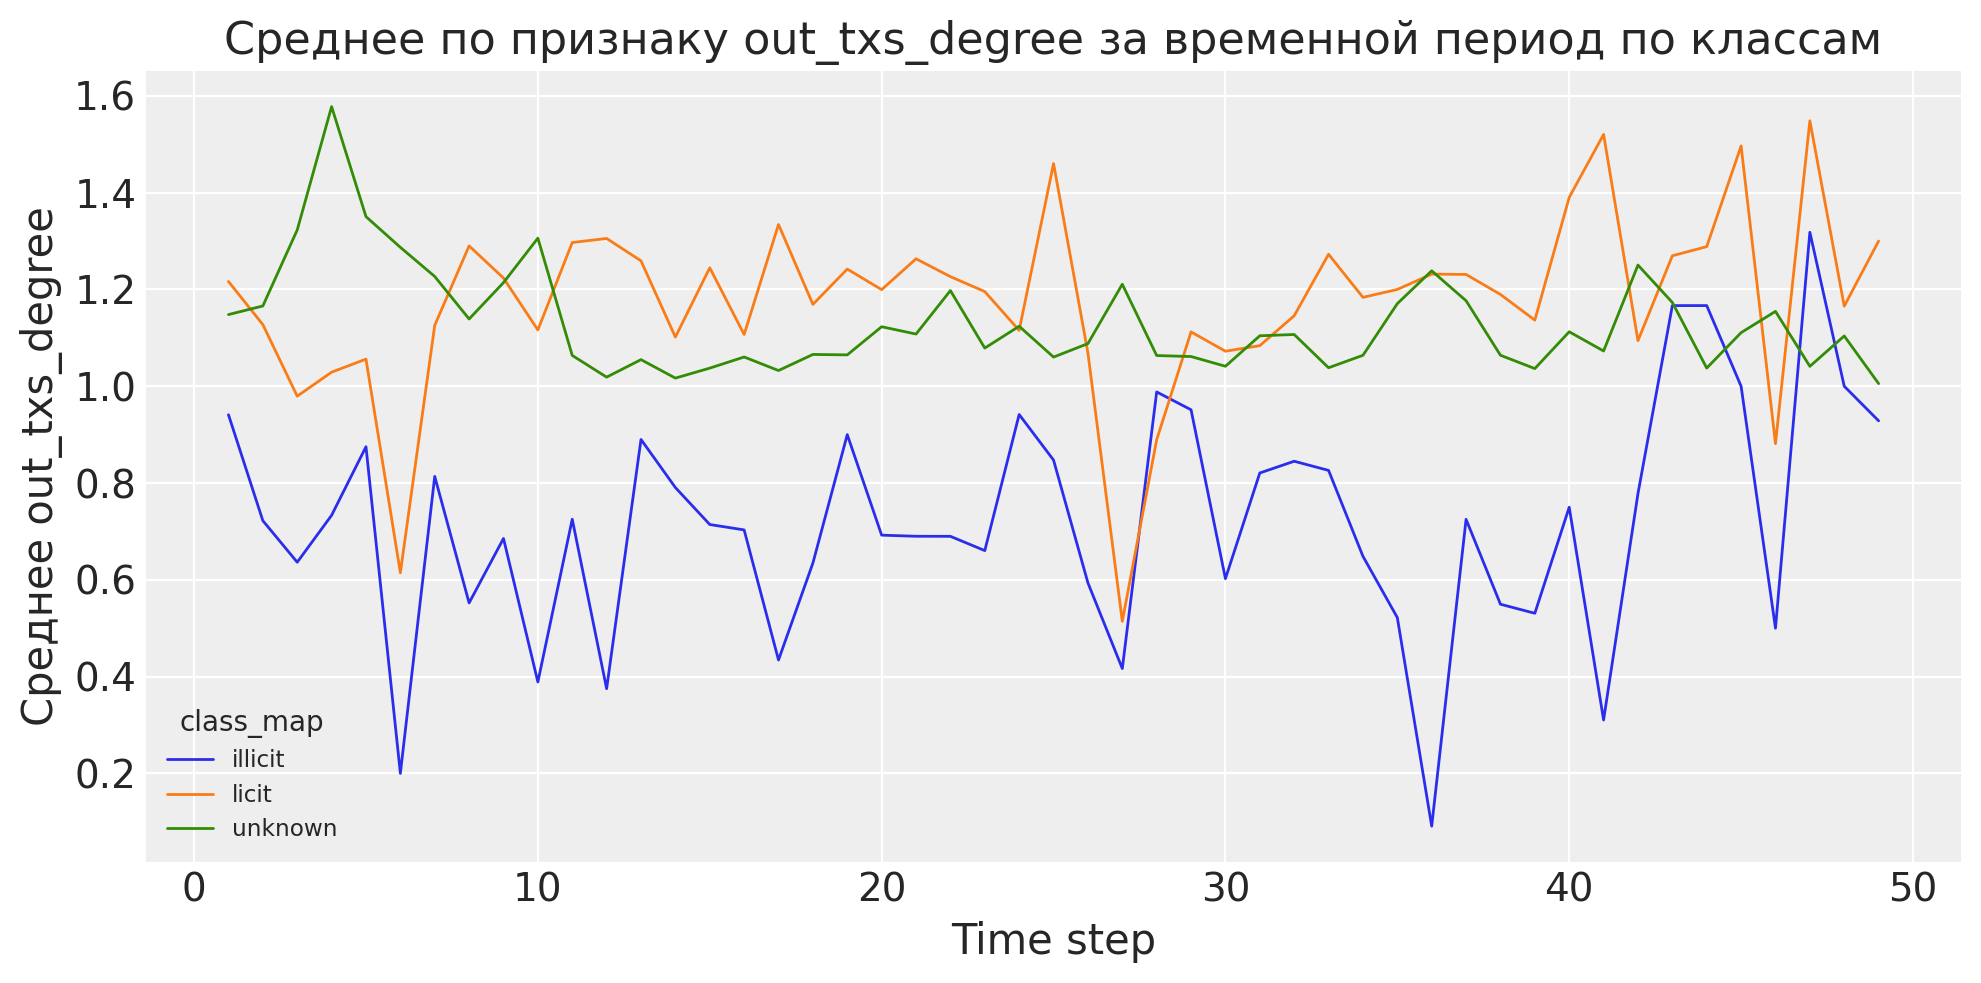

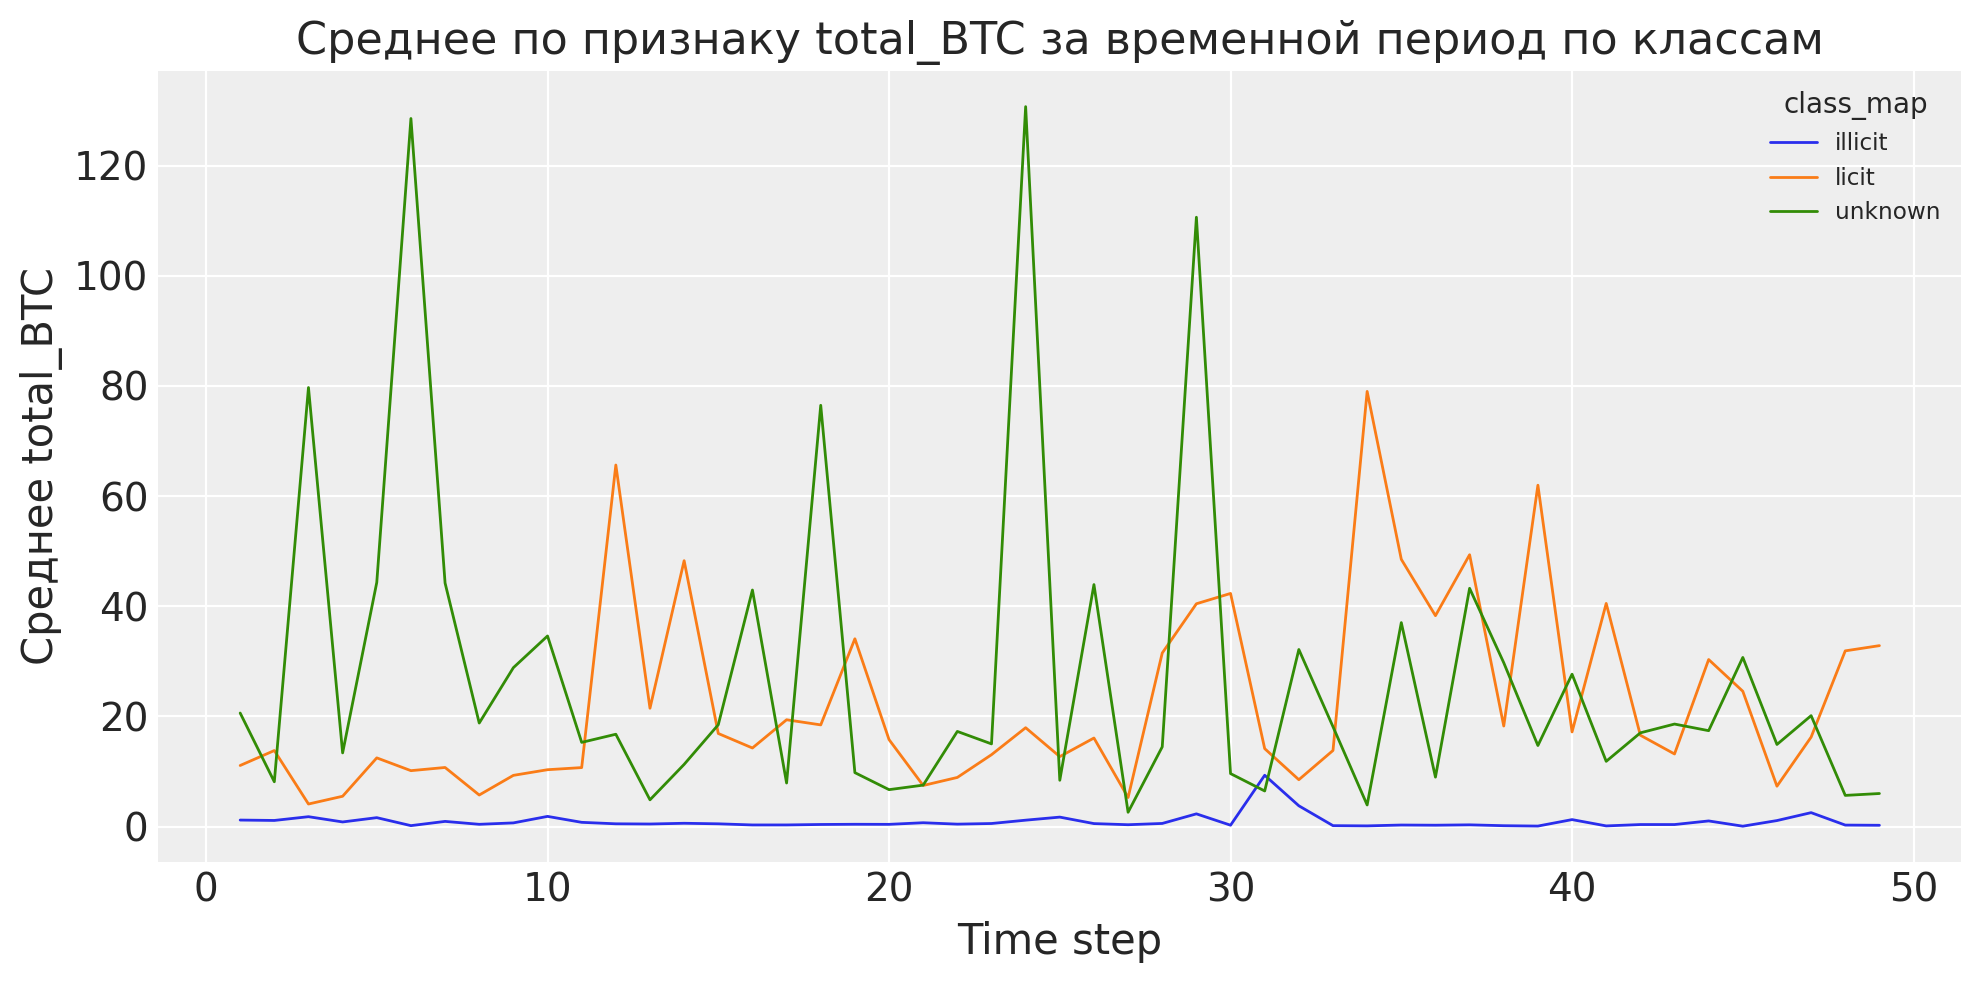

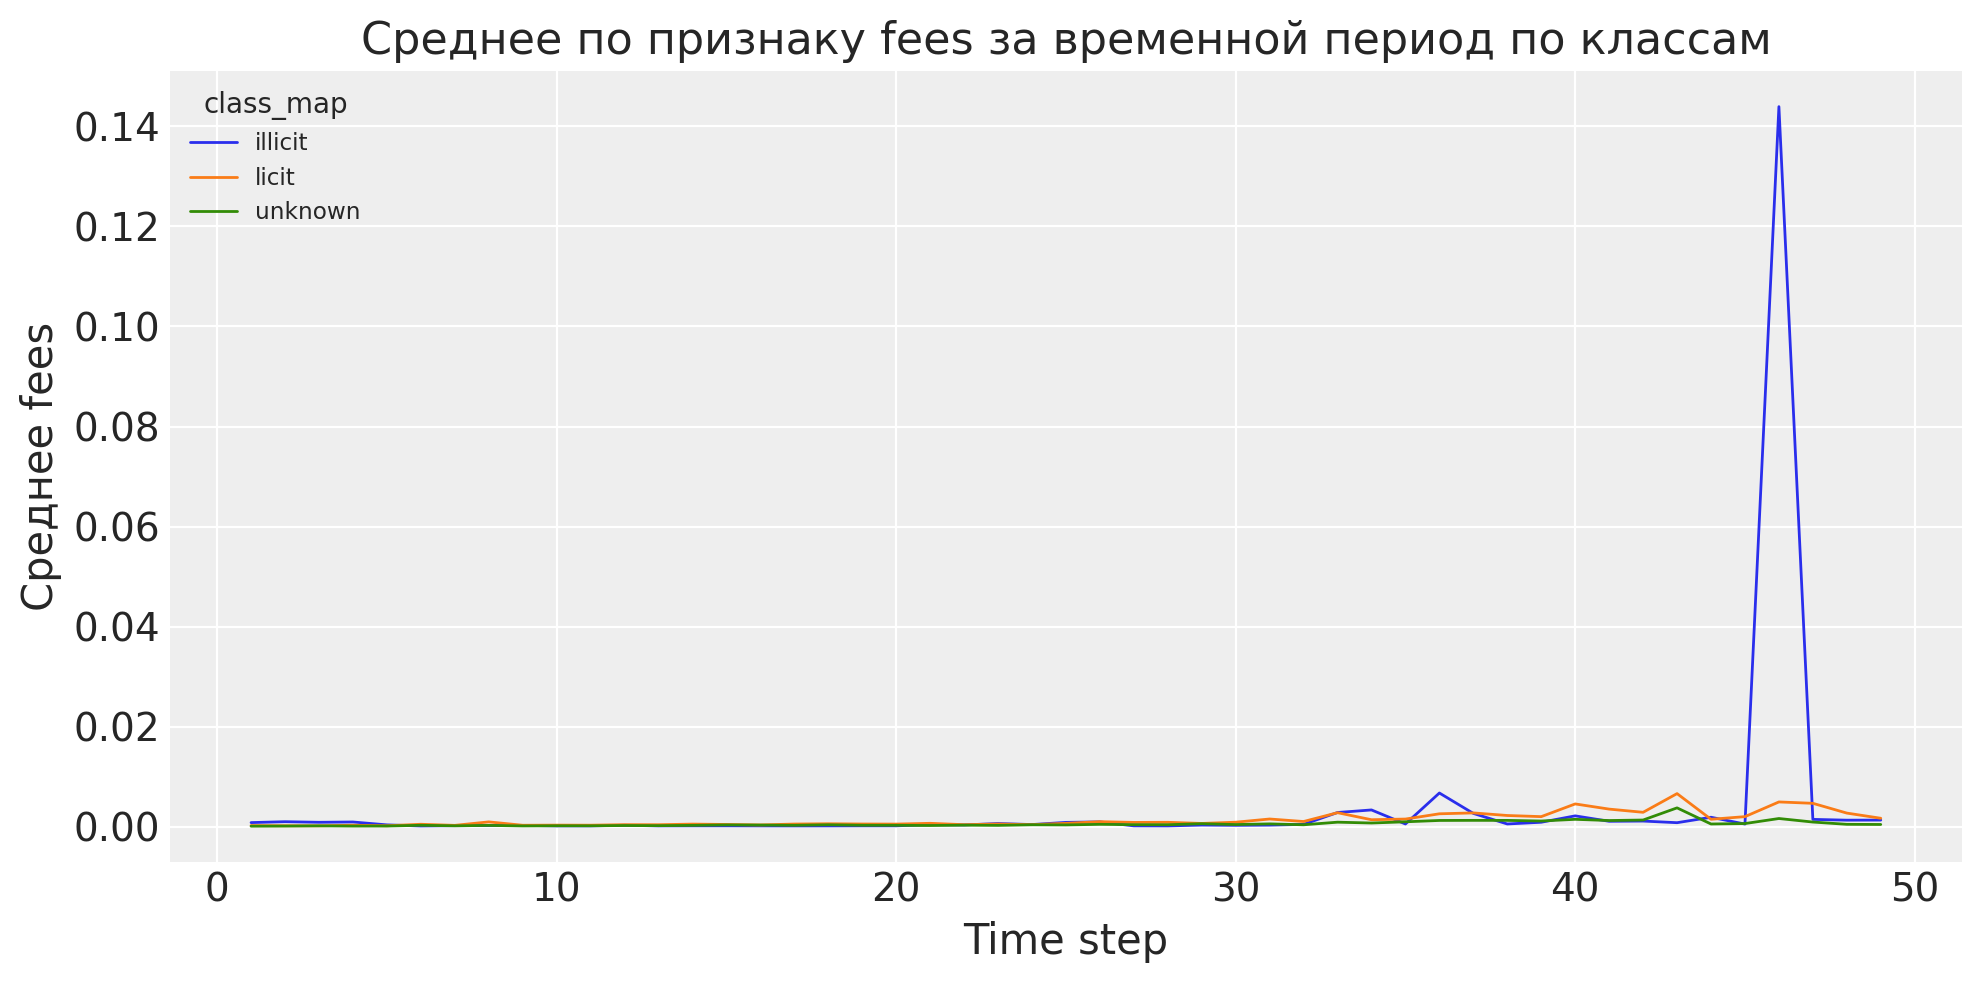

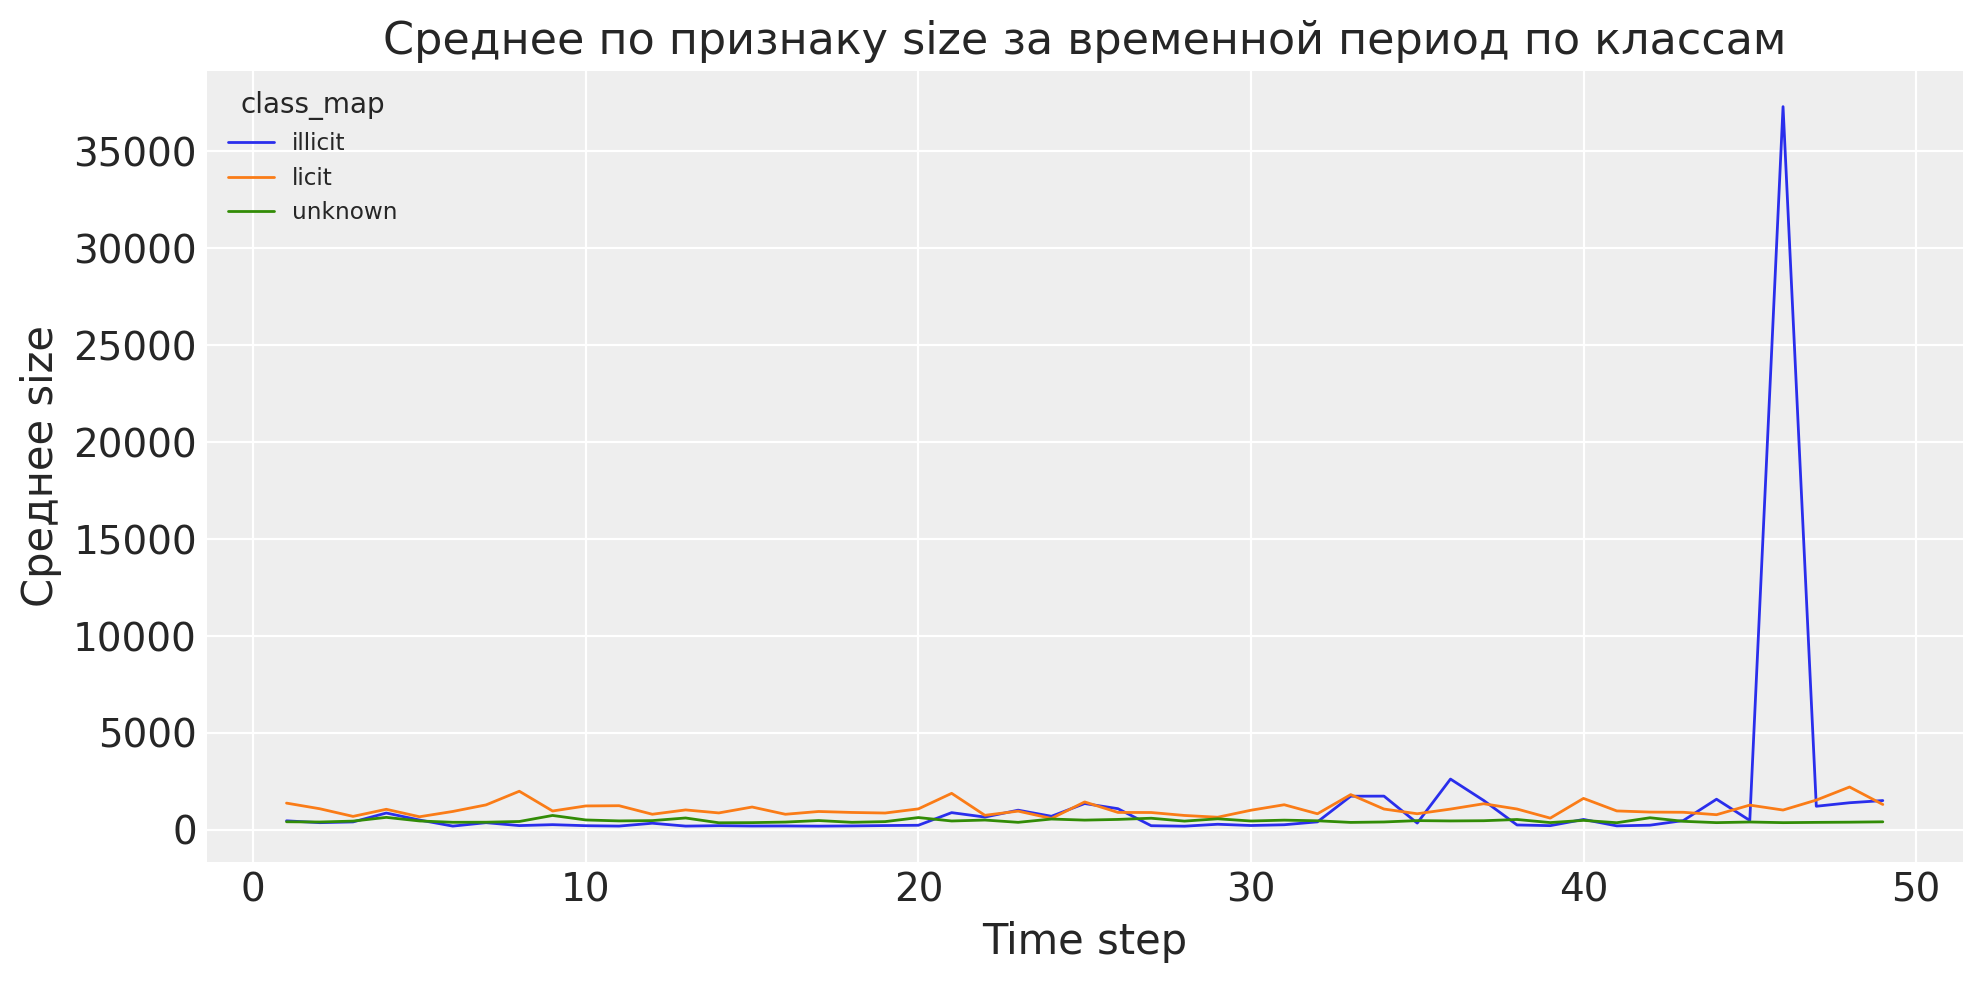

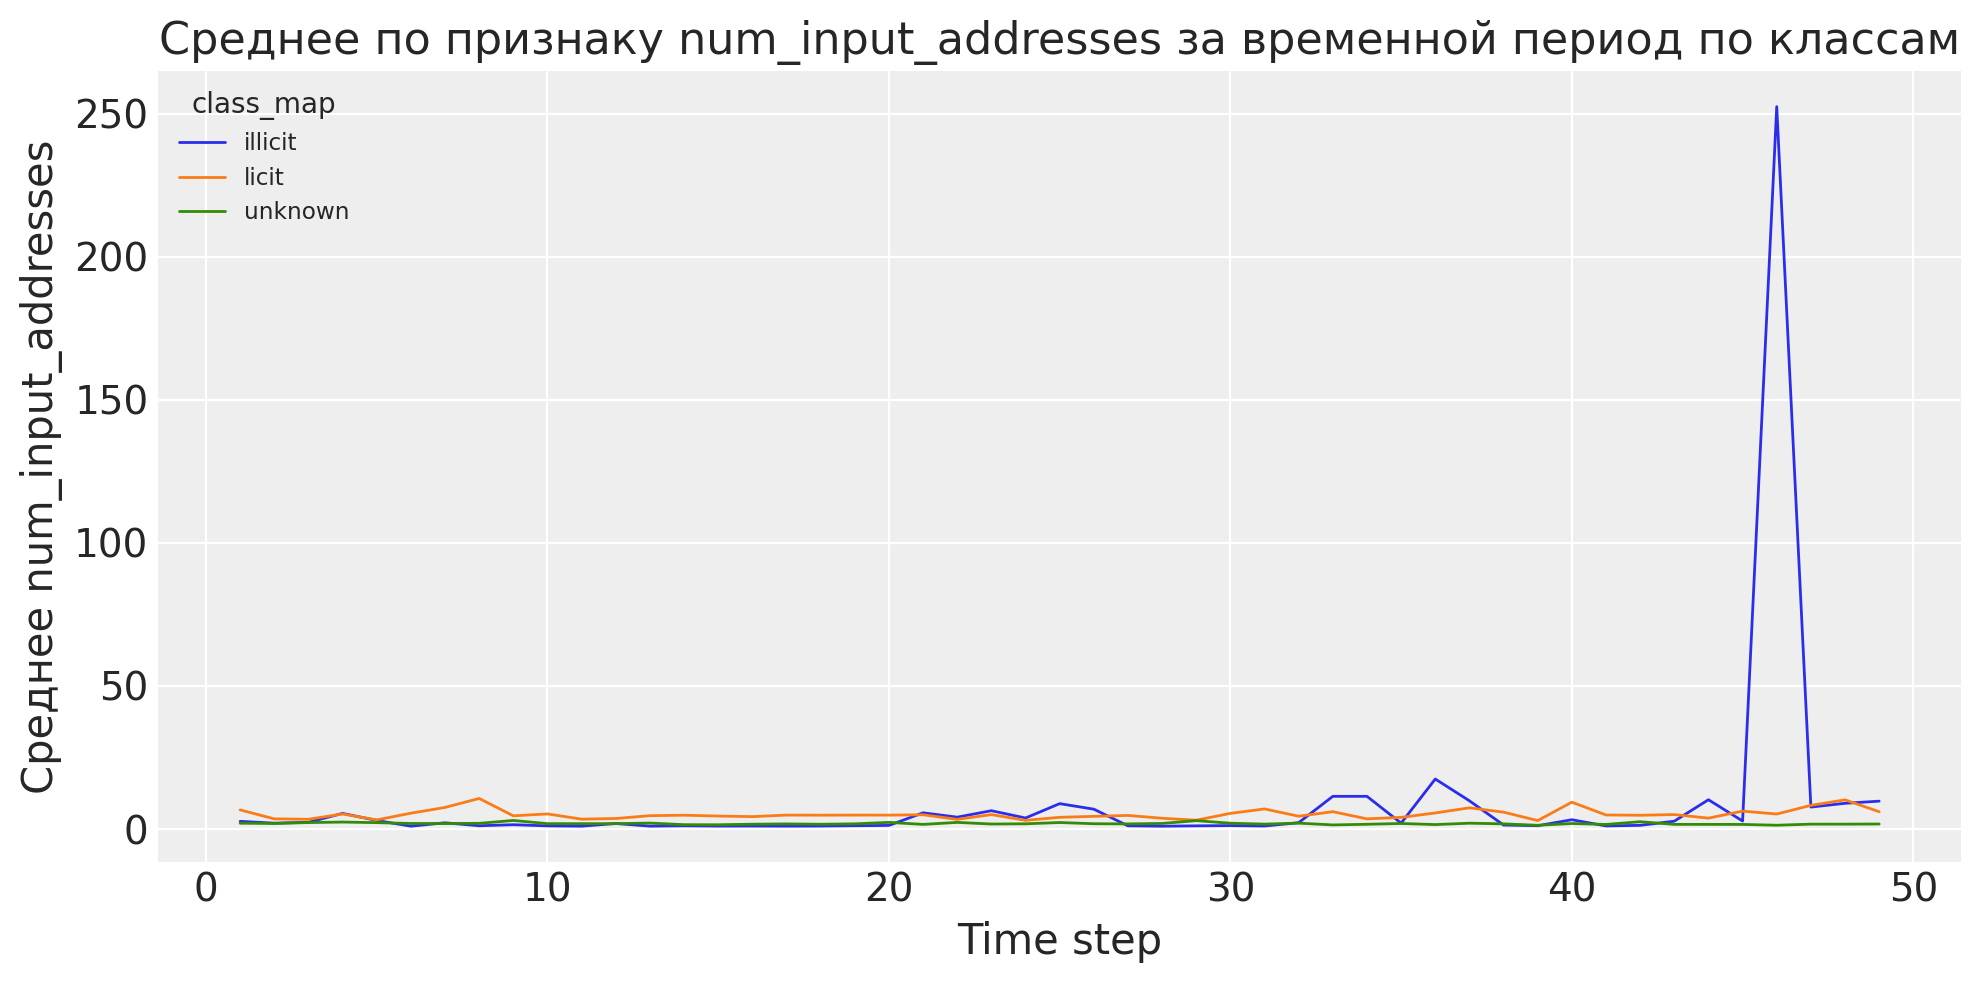

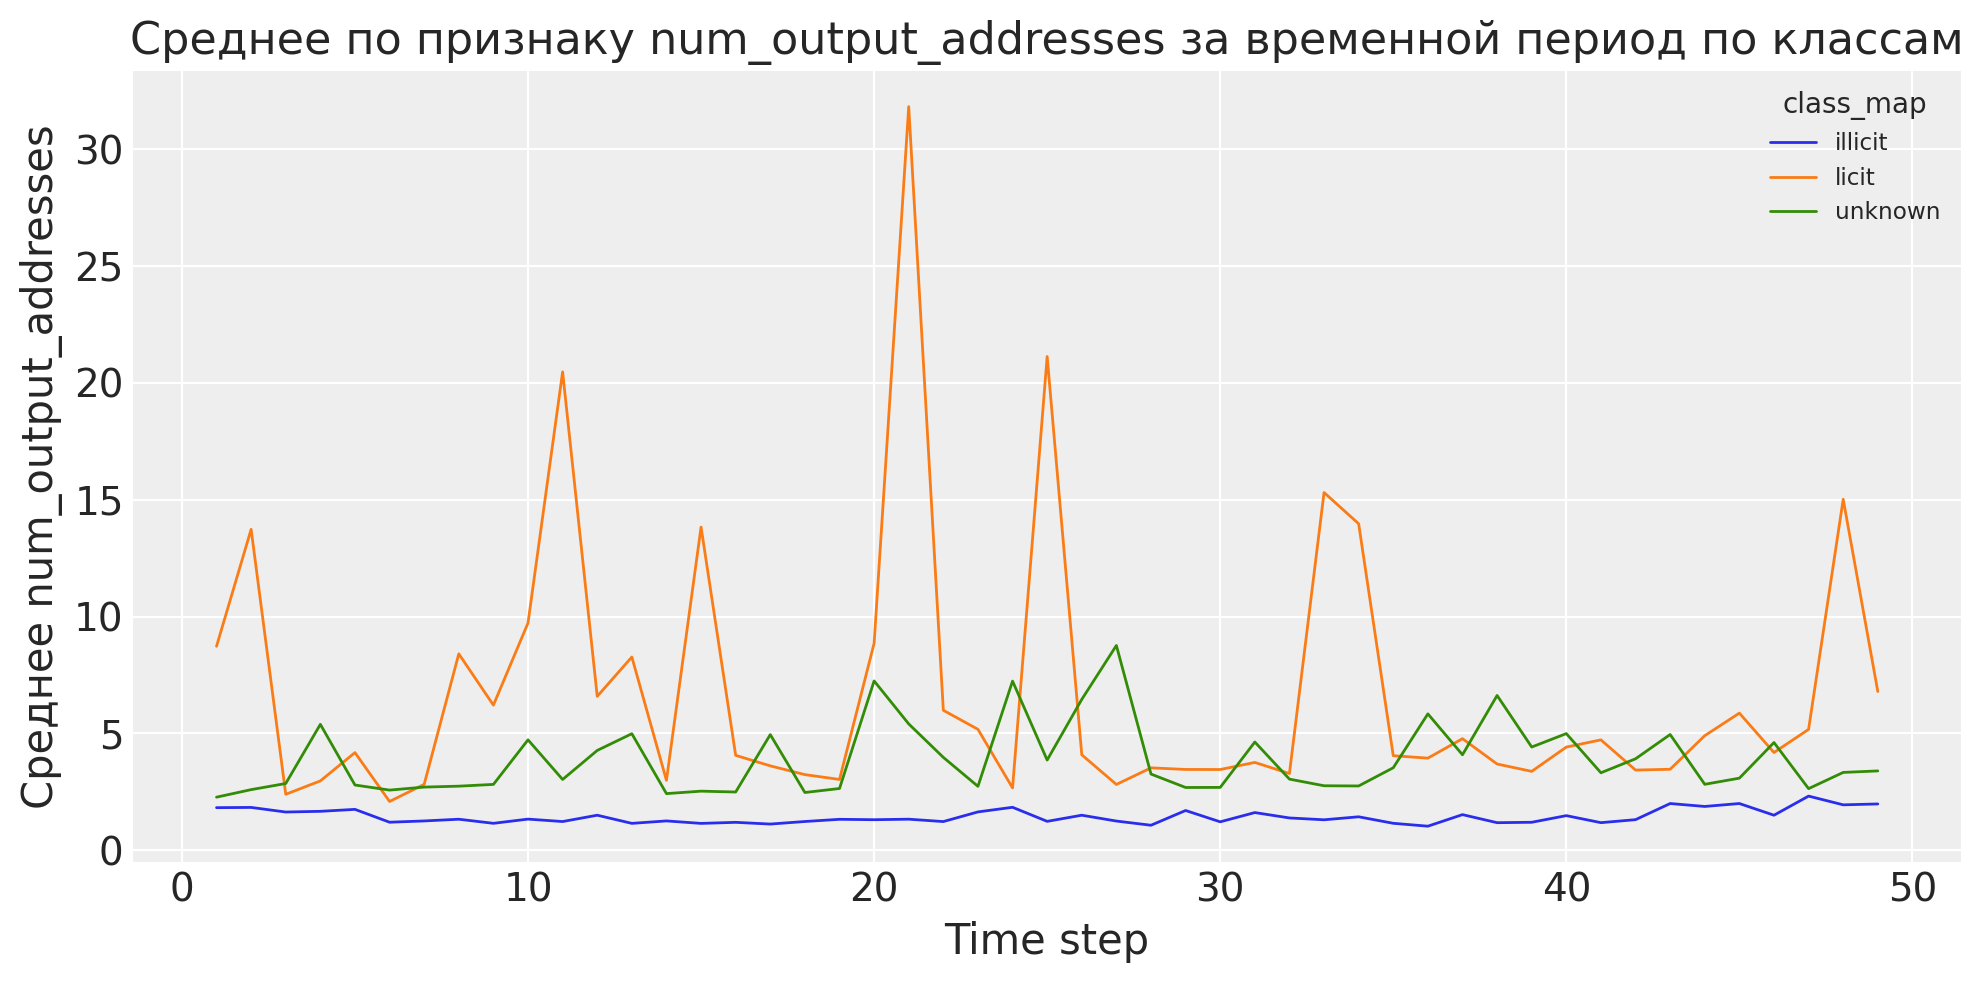

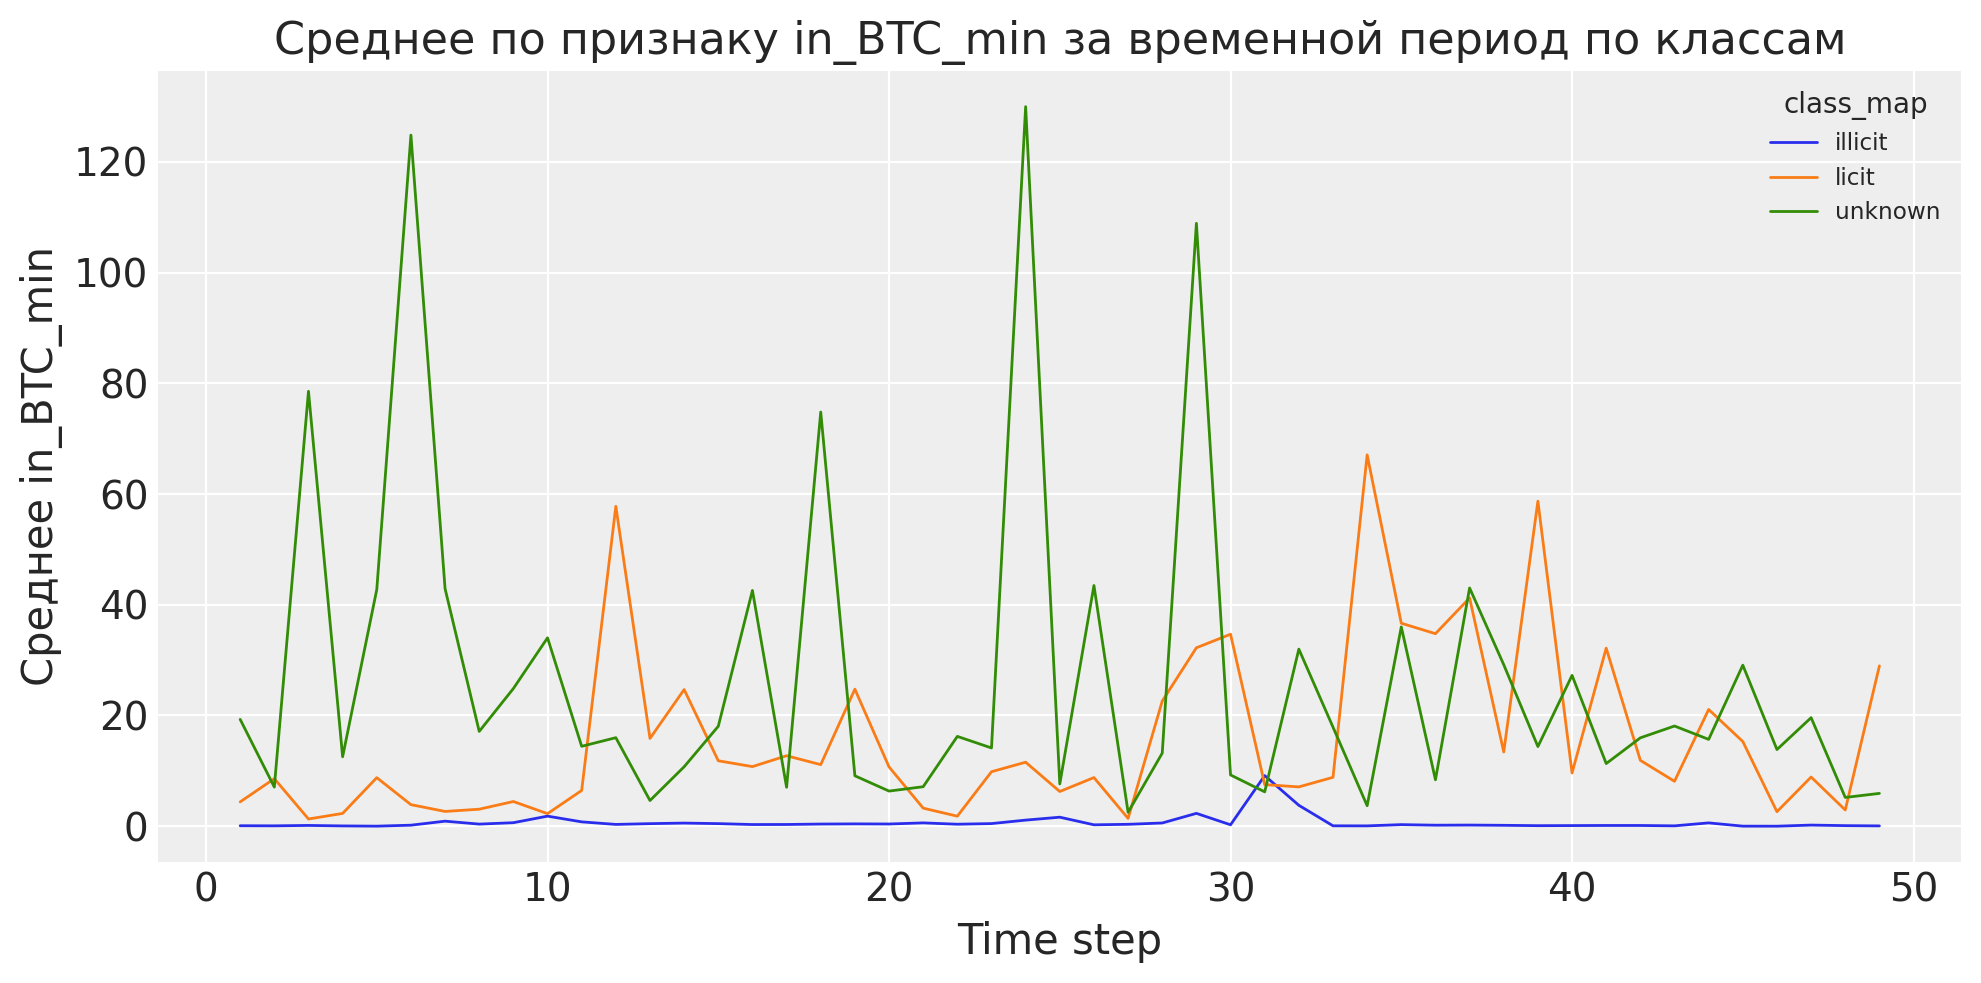

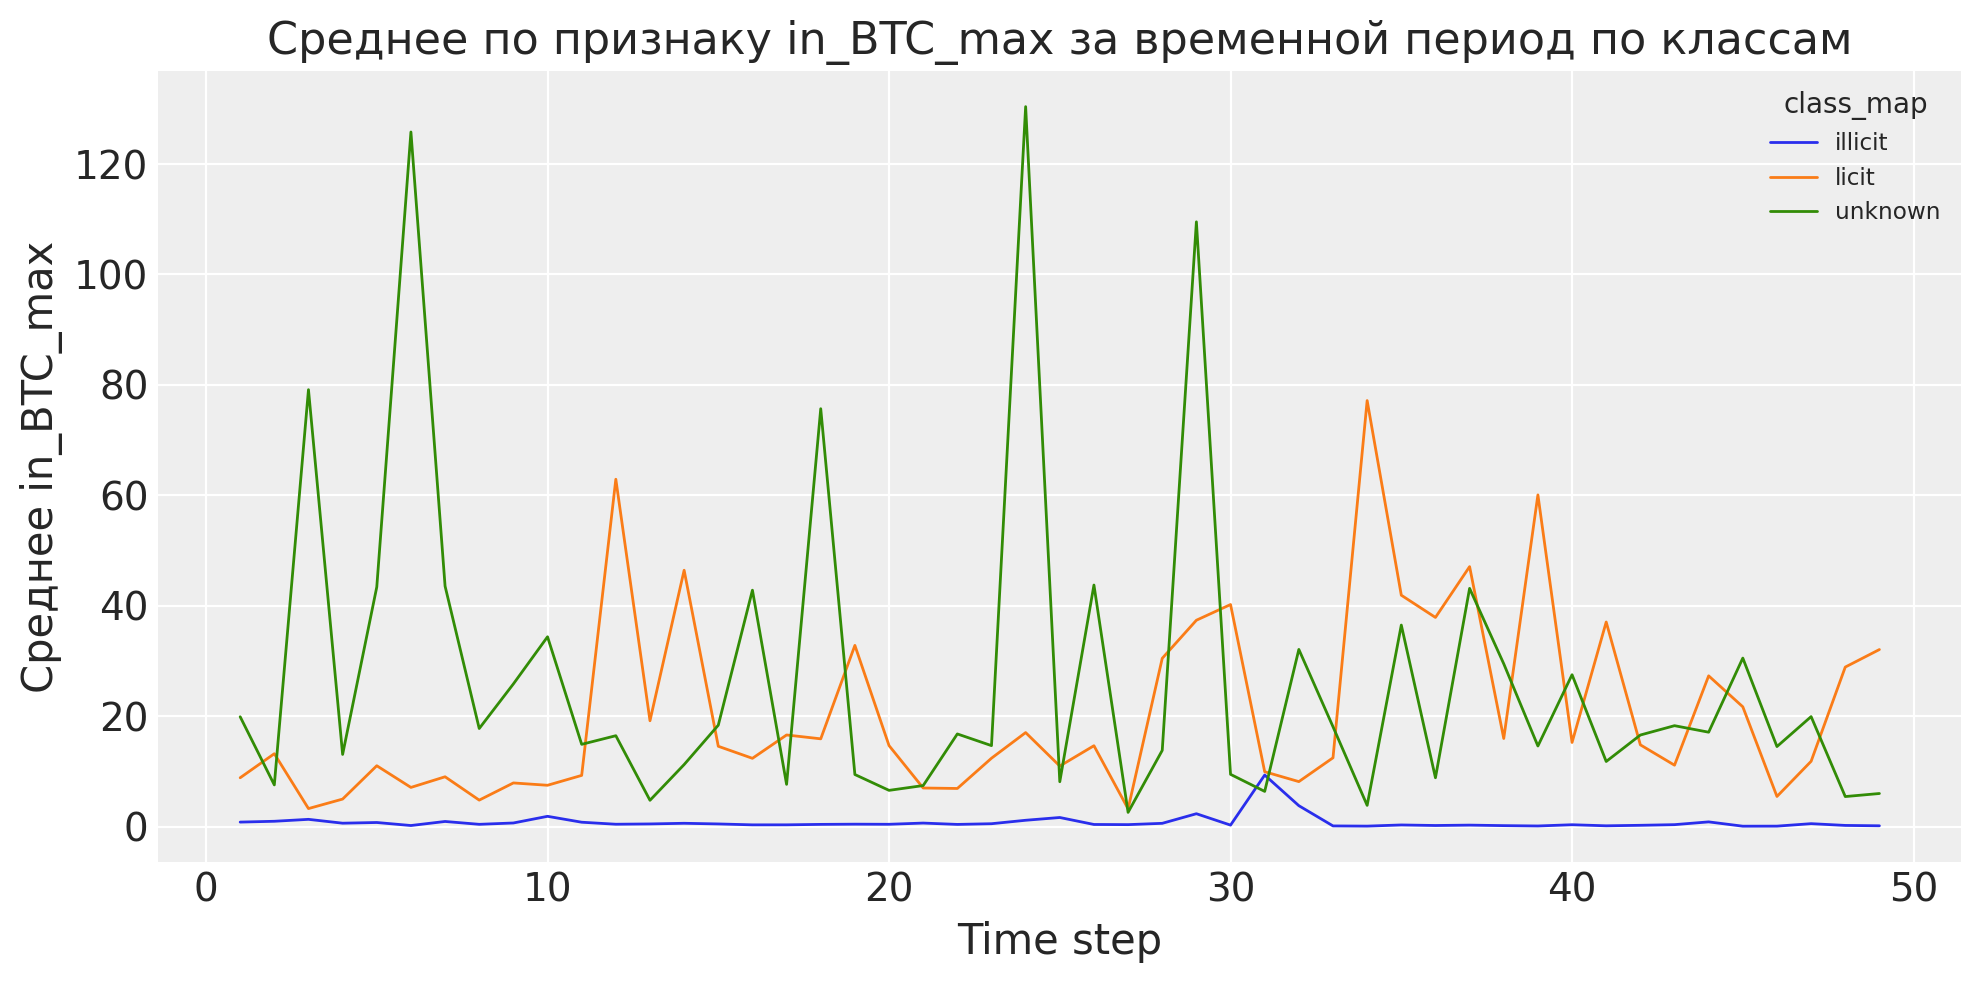

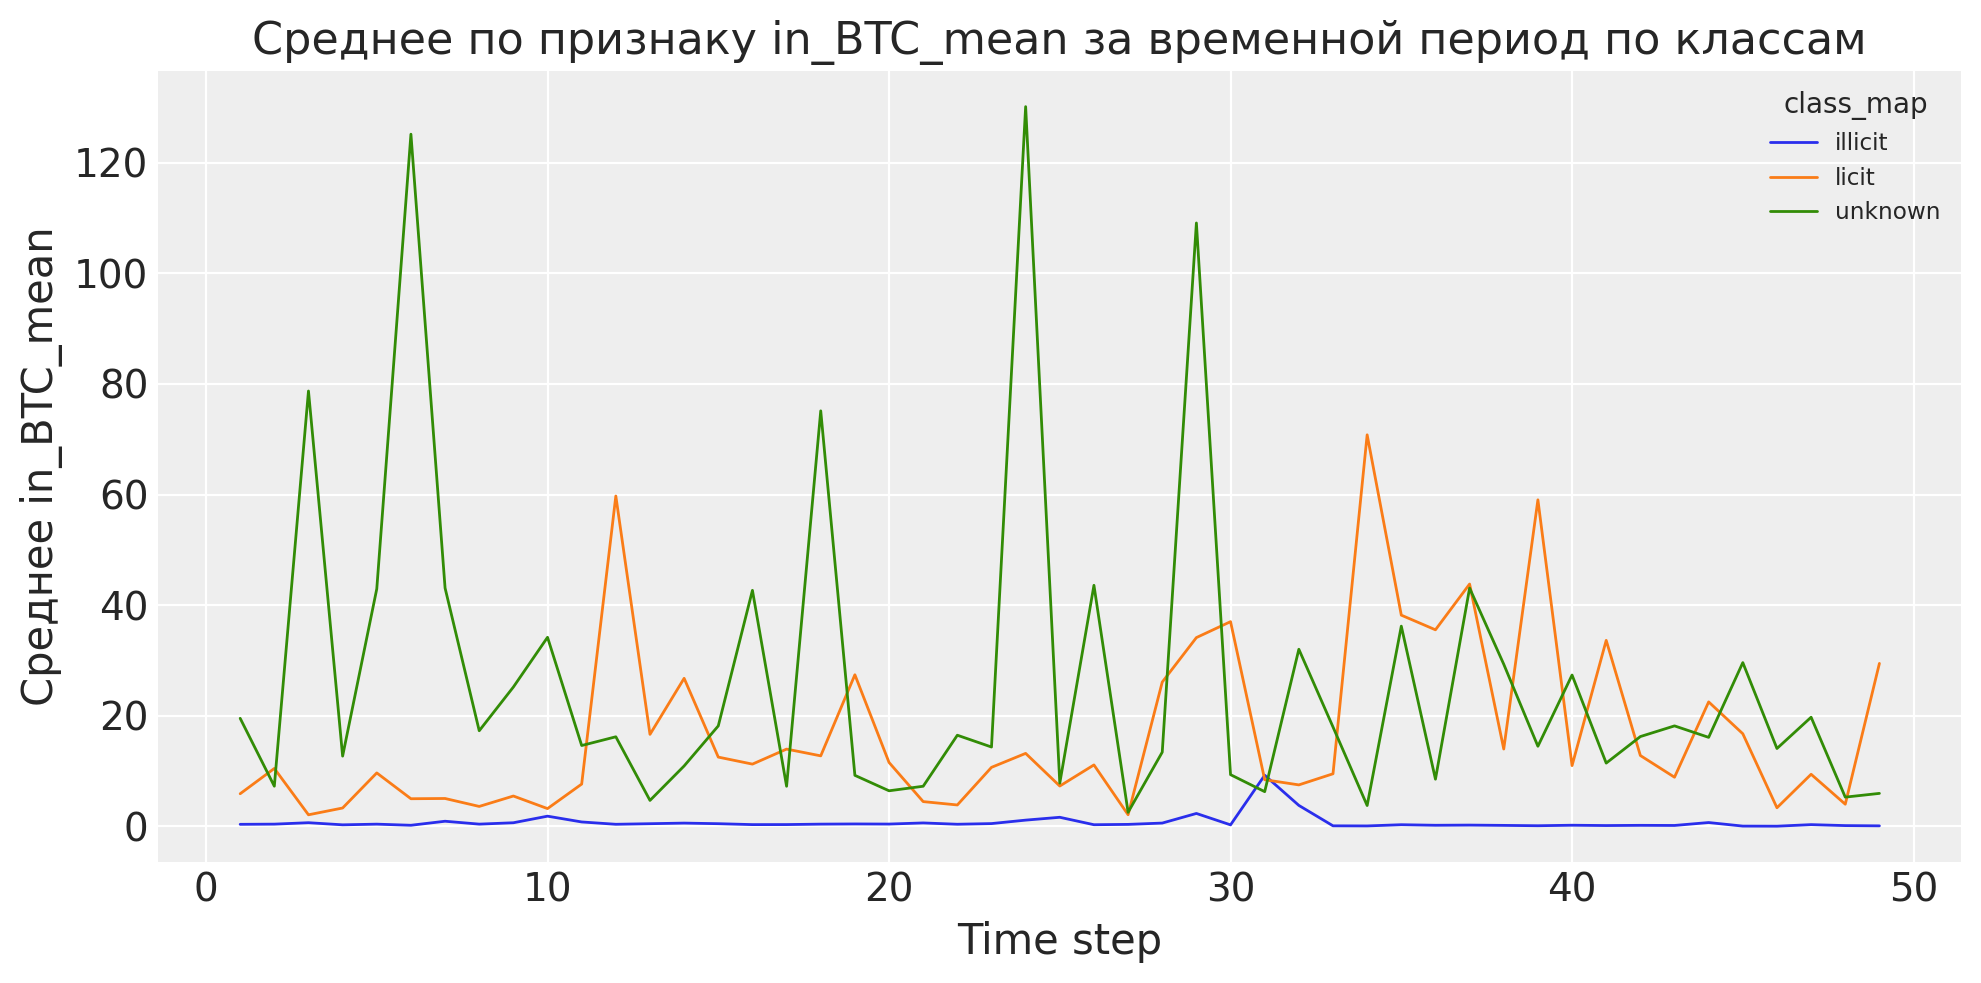

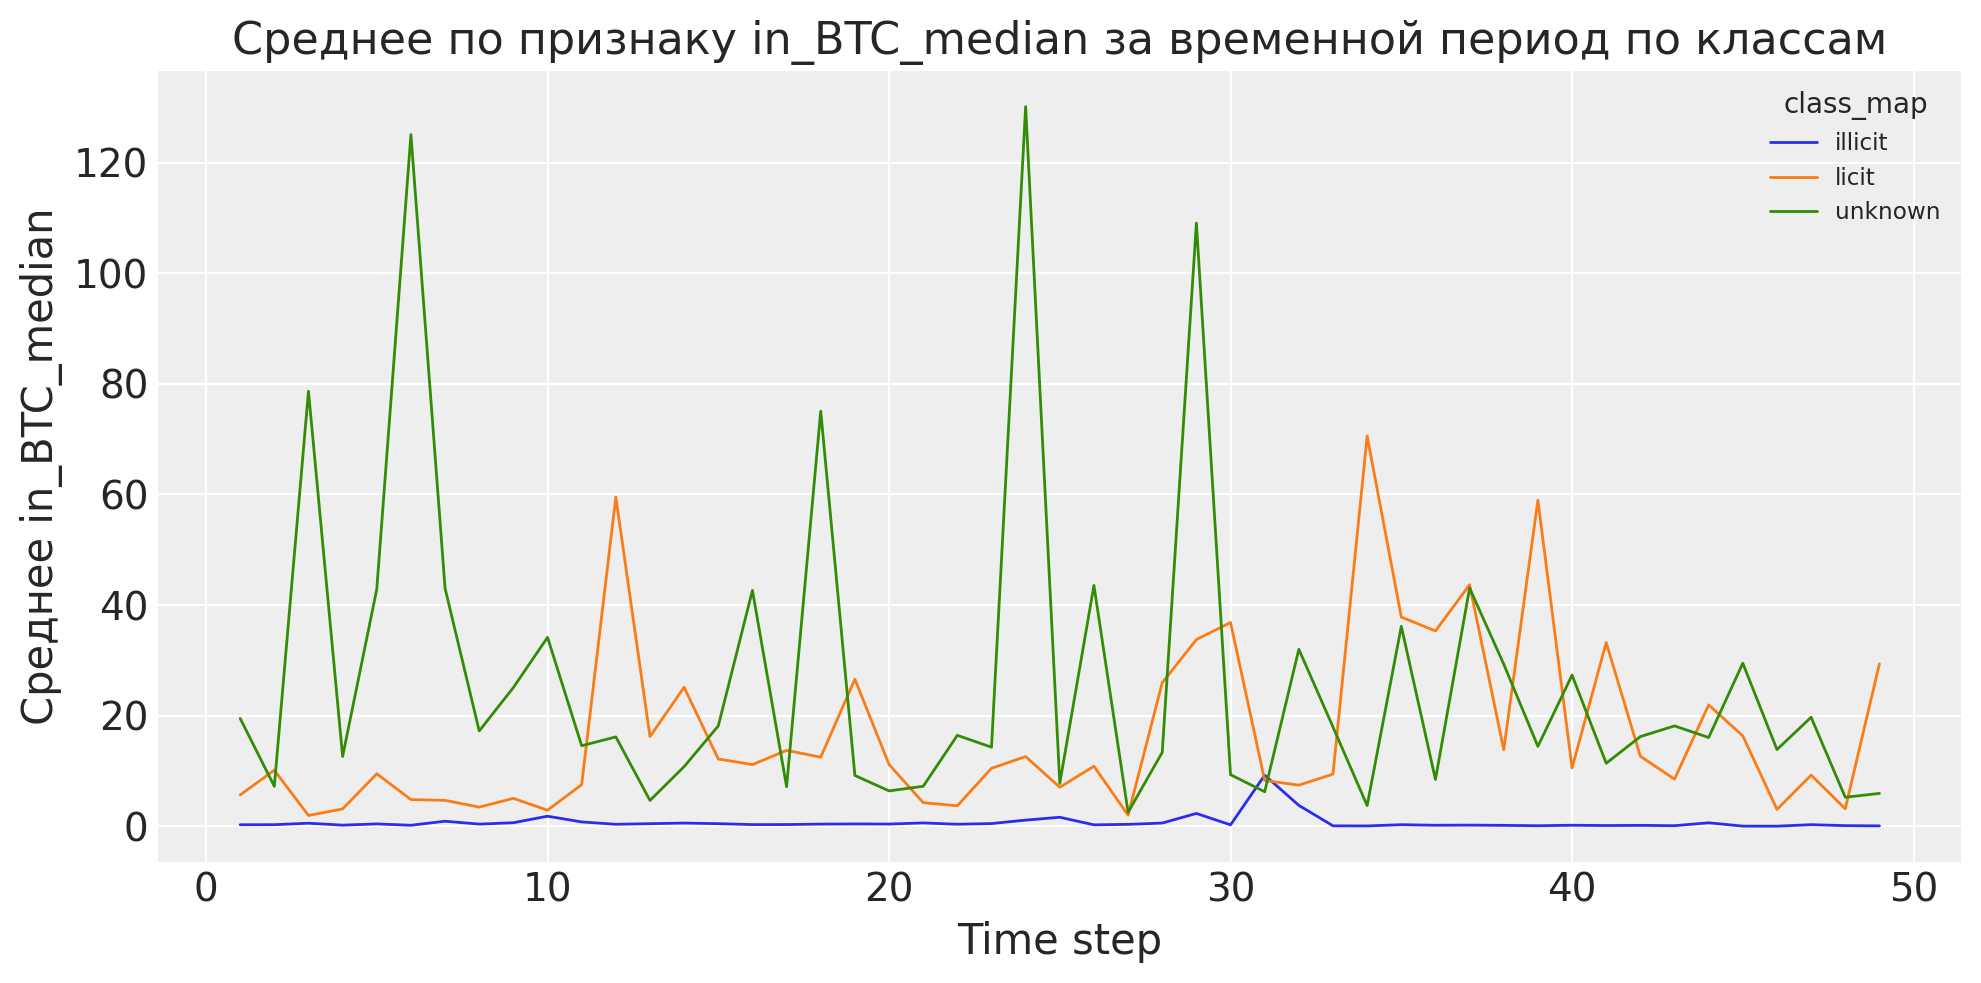

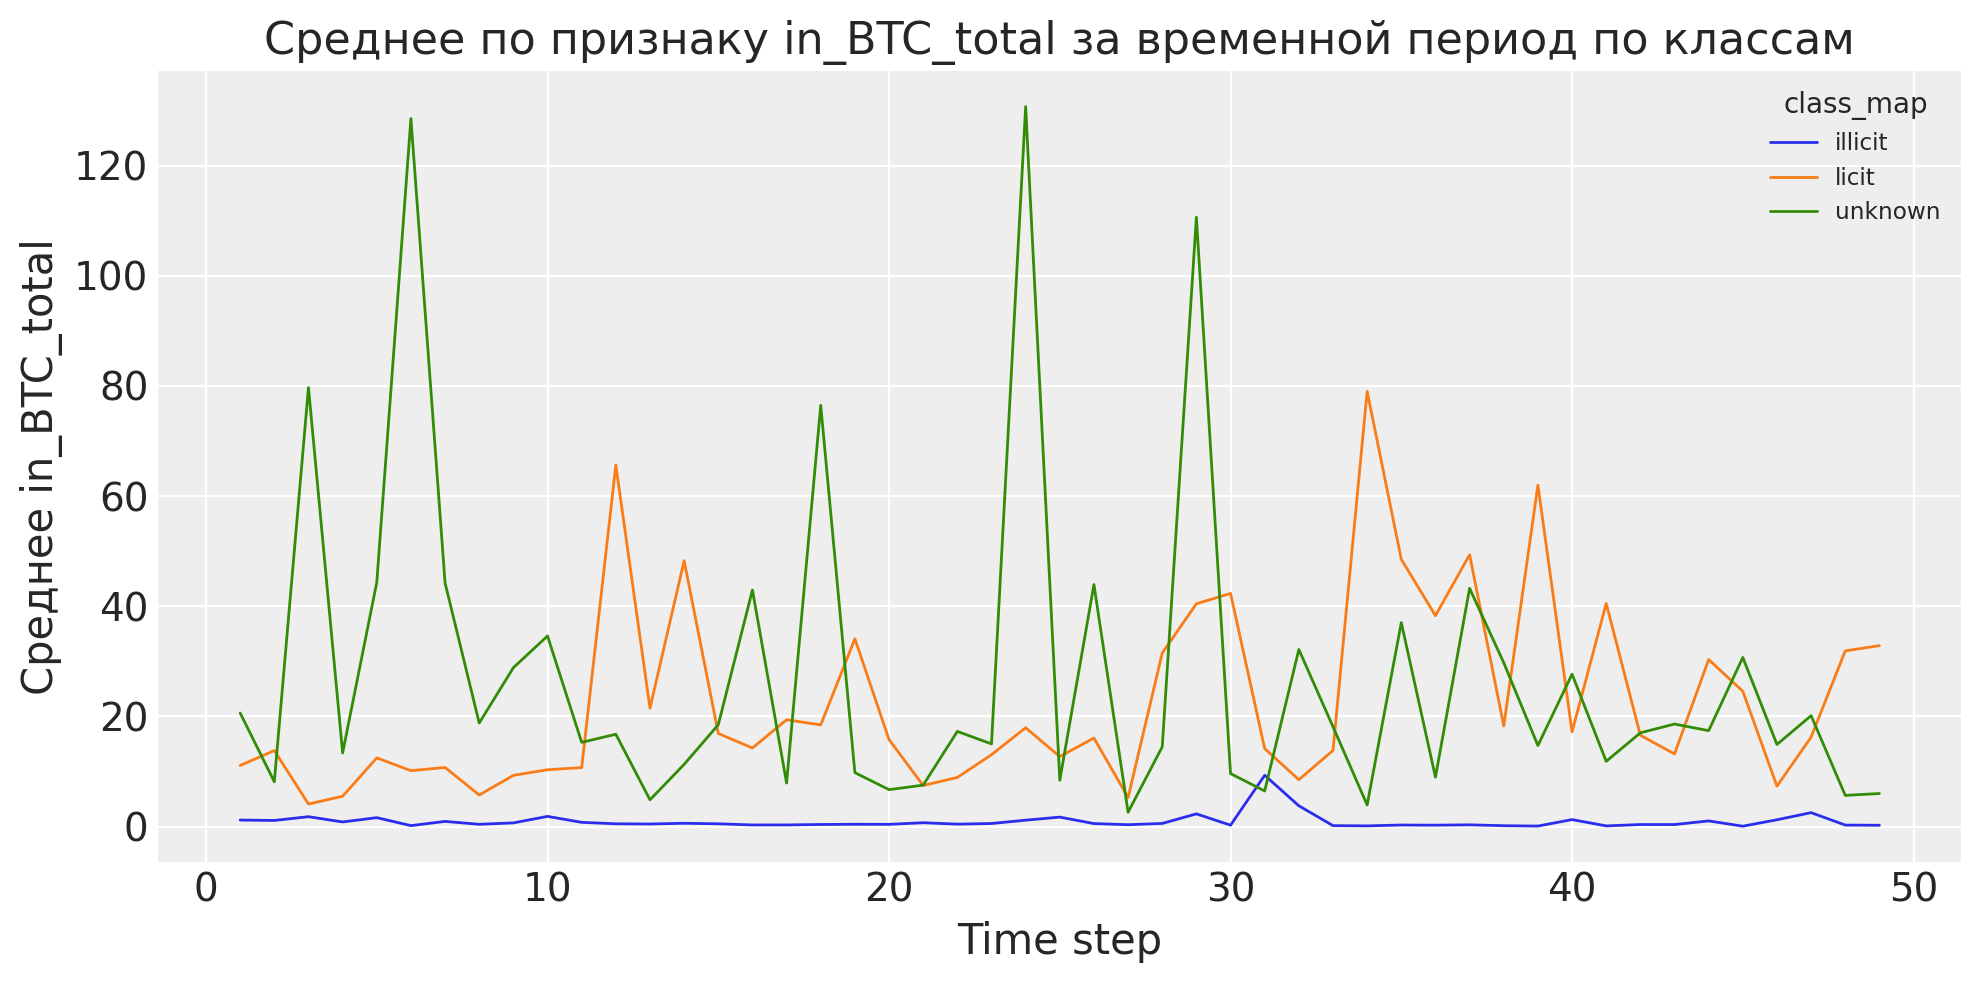

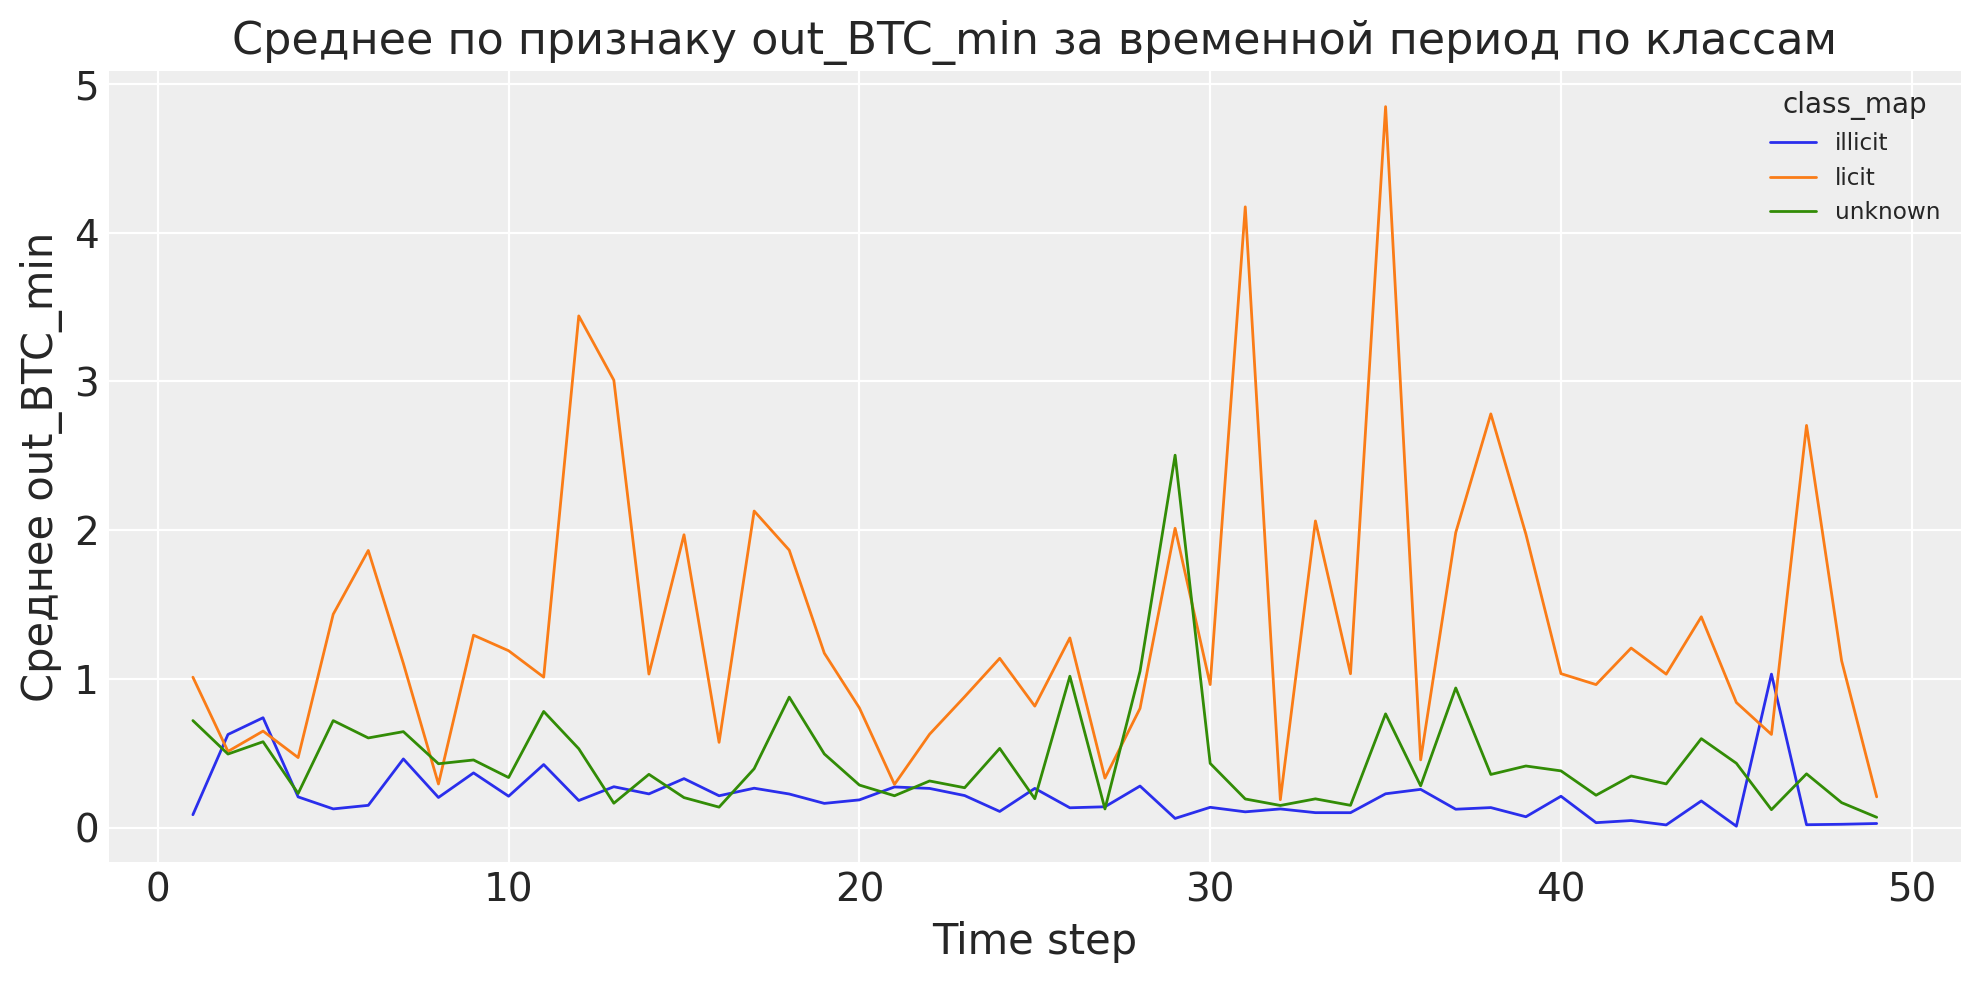

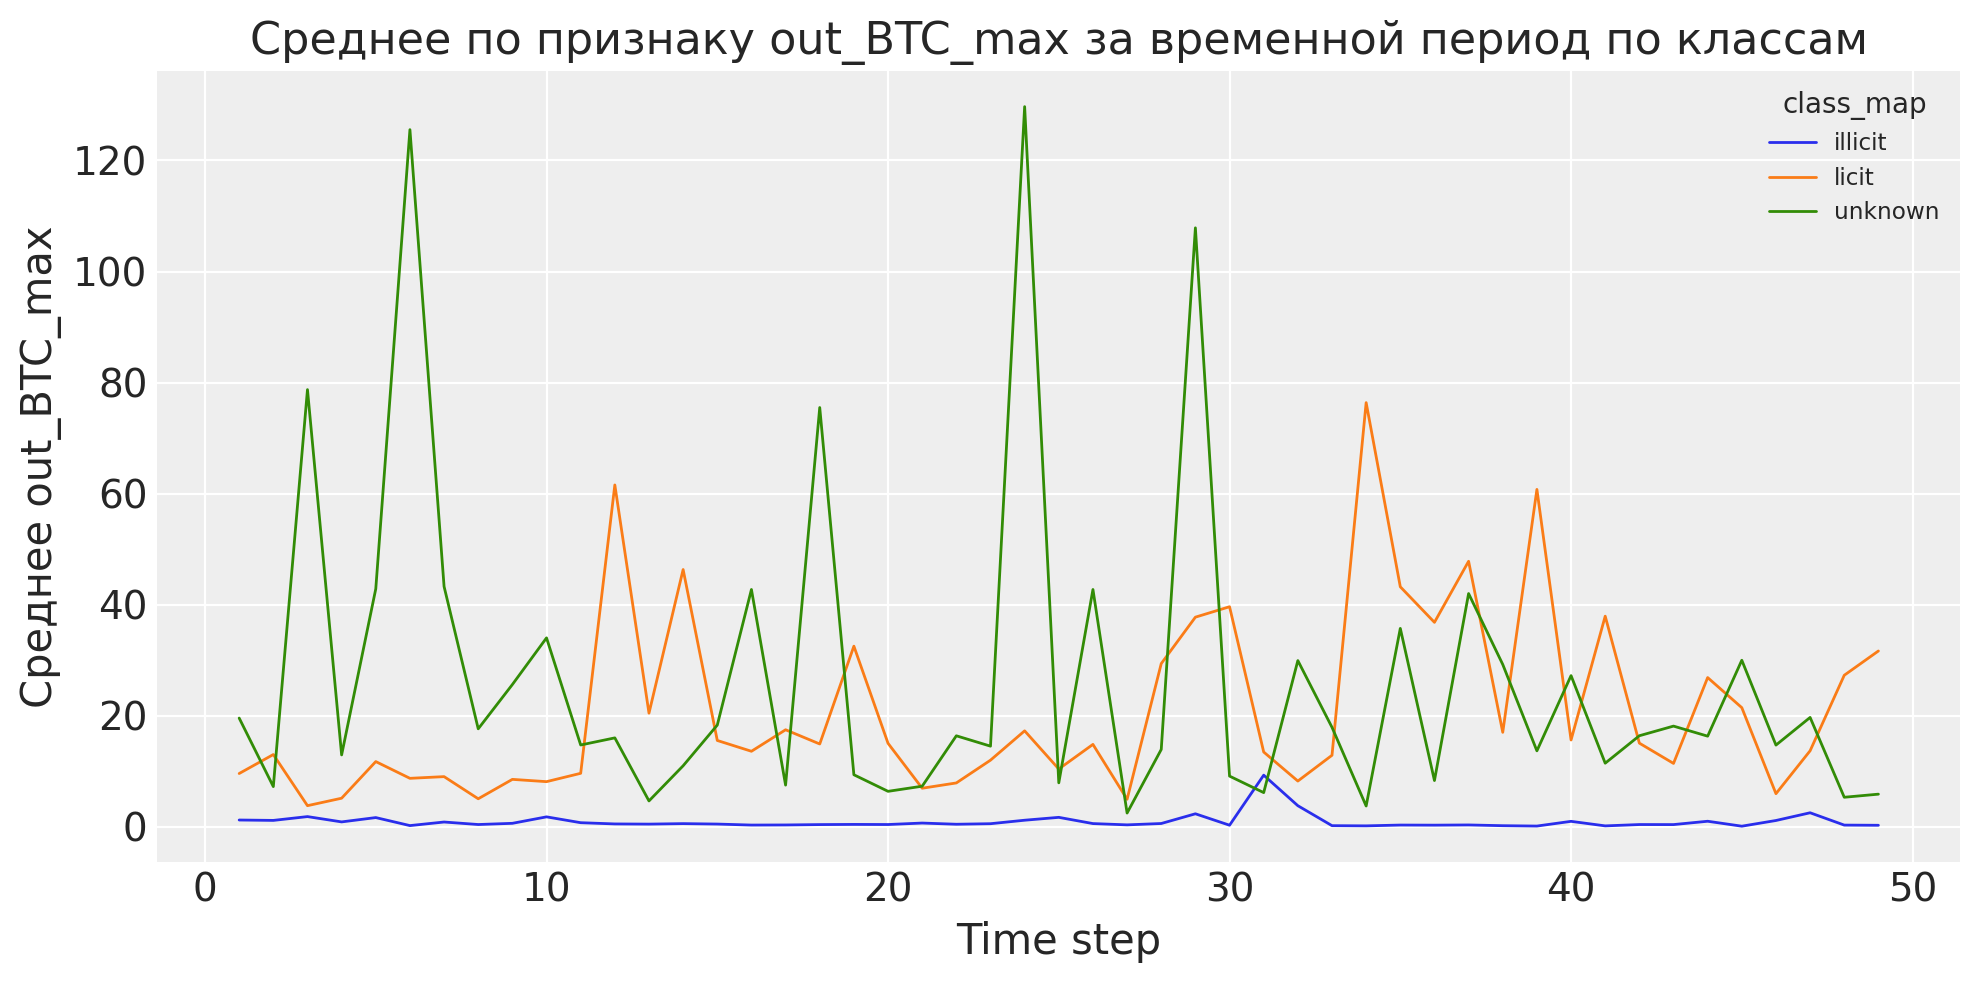

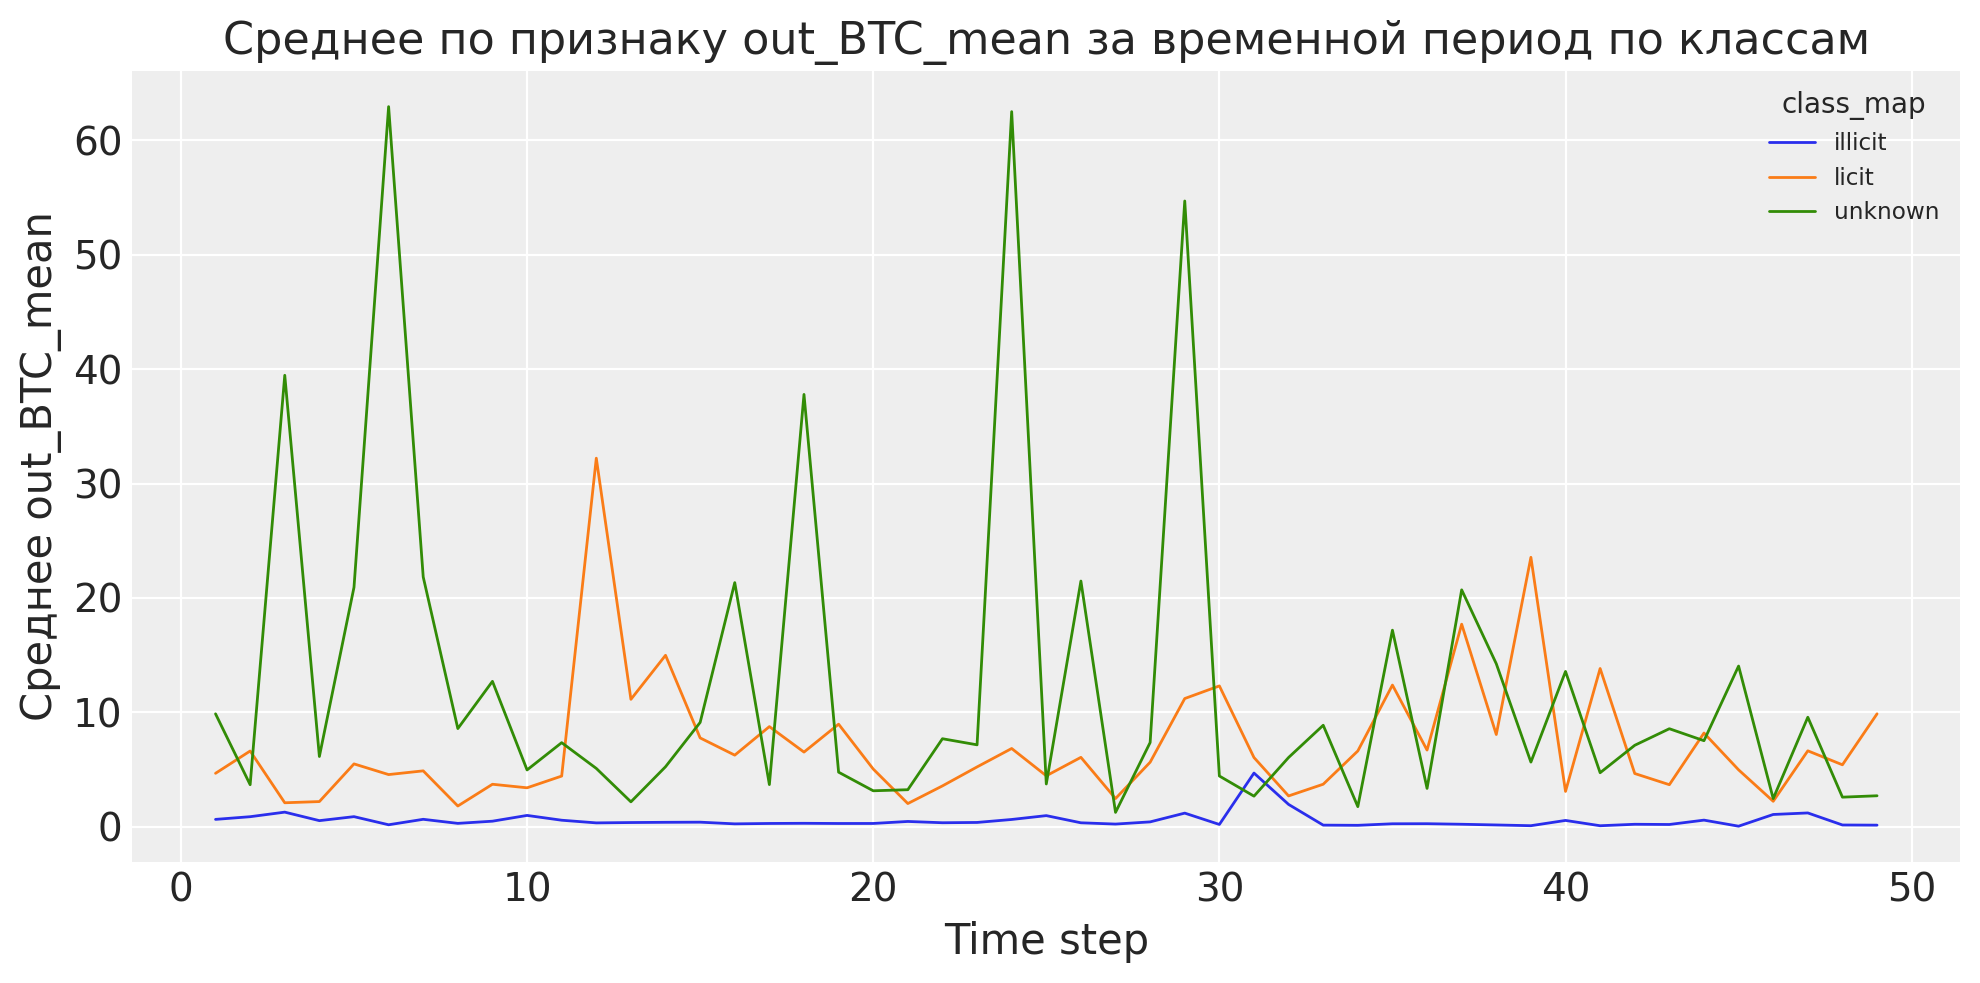

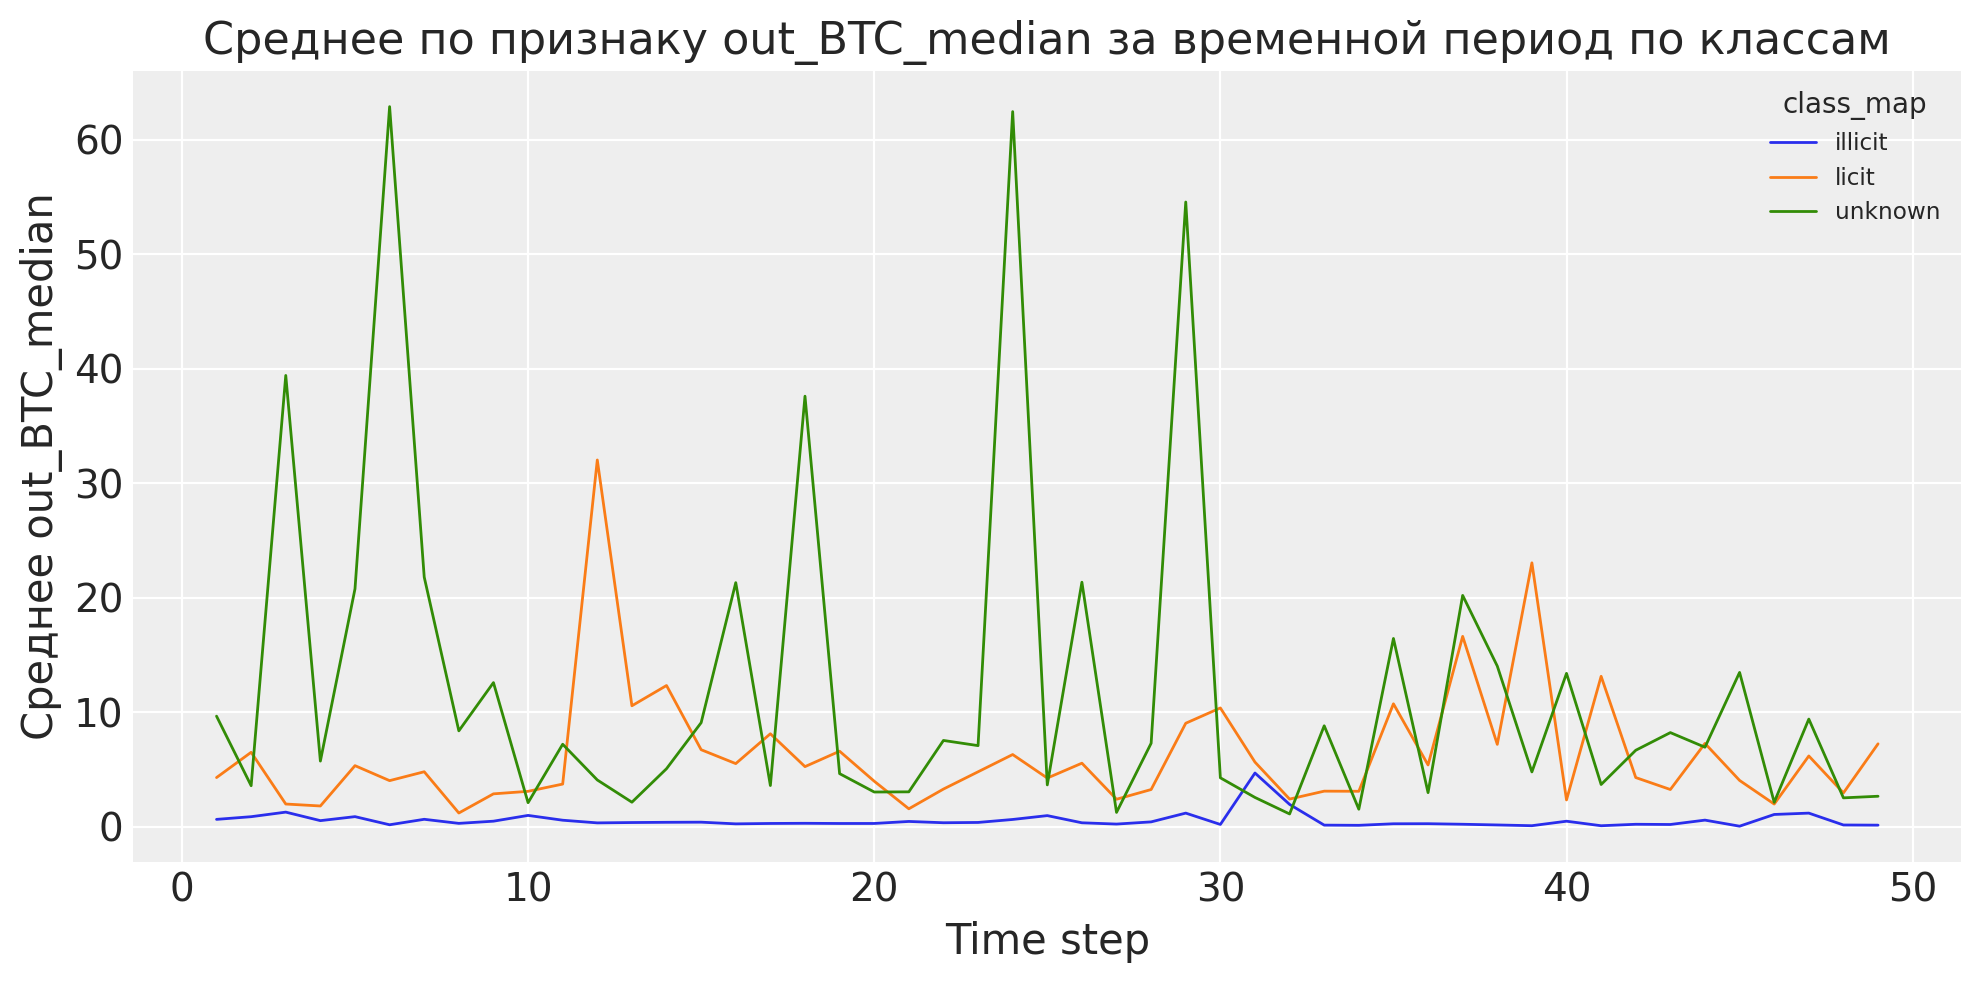

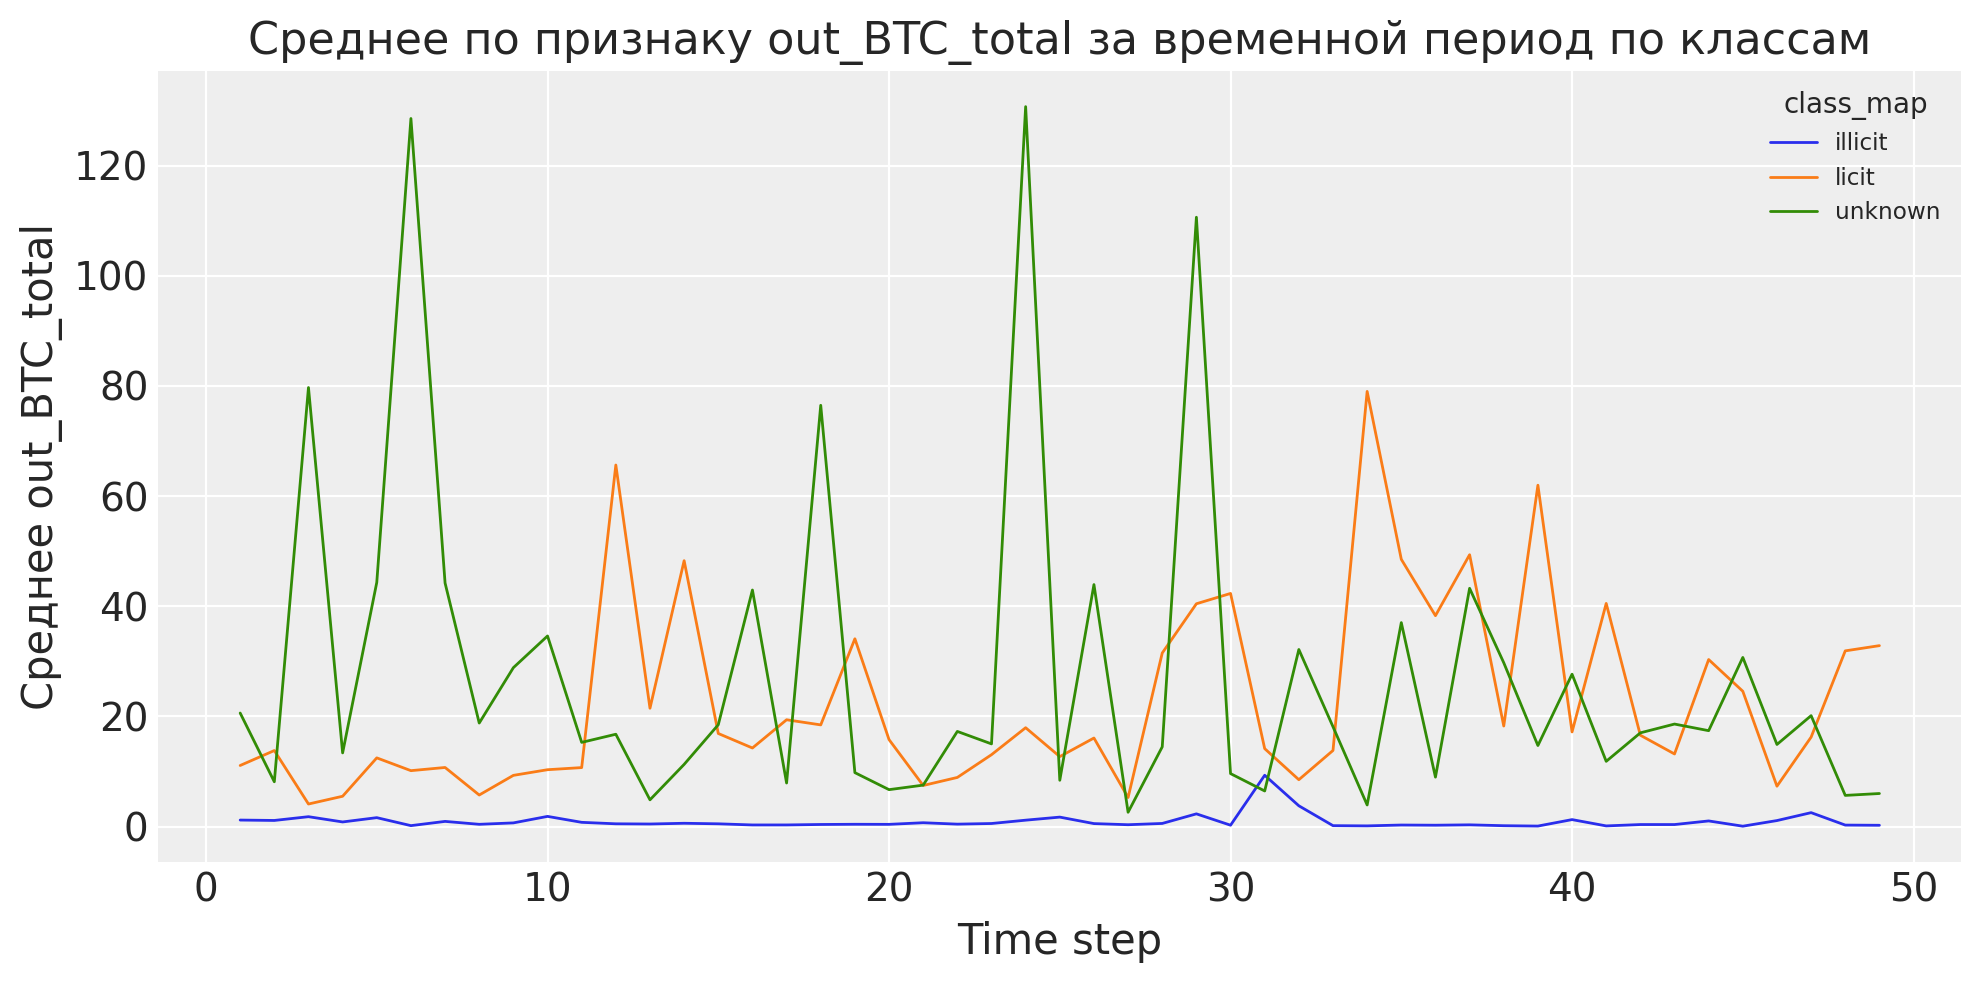

In [33]:
agg_cols = [
    col for col in df_transactions_filled_nf.columns
    if col not in ('txId', 'class_map', 'Time step', 'class')
]

grouped = (
    df_transactions_filled_nf
      .groupby(['Time step', 'class_map'])[agg_cols]
      .mean()
      .reset_index()
)

for col in agg_cols:
    pivot = grouped.pivot(index='Time step', columns='class_map', values=col)
    
    plt.figure(figsize=(10, 5))
    for cls in pivot.columns:
        plt.plot(pivot.index, pivot[cls], label=str(cls), linewidth=1)
    plt.title(f"Среднее по признаку {col} за временной период по классам")
    plt.xlabel("Time step")
    plt.ylabel(f"Среднее {col}")
    plt.legend(title='class_map', loc='best', fontsize='small')
    plt.tight_layout()
    plt.show()


Как можно заметить из графиков у мошеннических транзакций в среднем видна тенденция к тому, что как правило они проводятся на меньшую сумму, чем у остальных классов, а также отправляется на небольшое количество кошельков, а вот количество кошельков с которых может отправляться транзакция может резко подскочить 

### 3.2 Анализ кошельков. Табличное представление

Поскольку далее будут предсказываться транзакции как мошеннические или нет, то вытащим побольше фичей из данных о кошельках и посмотрим на их характеристики. 

Проверим меняли ли кошельки во времени свои классы и другие признаки:

In [34]:
static_cols = [
    col for col in df_wallets.columns
    if col not in ('address', 'Time step')
]

uniq_counts = df_wallets.groupby('address')[static_cols].nunique()

changed = uniq_counts[(uniq_counts > 1).any(axis=1)]

print(f"Адресов, у которых изменились не временное поле: {len(changed)}")

examples = changed.head(10)
for addr, row in examples.iterrows():
    diffs = row[row > 1].index.tolist()
    print(f"{addr}: менялись поля {diffs}")


Адресов, у которых изменились не временное поле: 0


Так как классы не меняются и все фичи тоже (кроме времени), то удалим дубликаты и перейдем к генерации фичей

In [35]:
df_wallets_features = df_wallets.drop_duplicates(subset=['address']).drop(columns={'Time step'})

In [36]:
df_wallets_features = df_wallets_features.rename(
    columns={'num_txs_as receiver': 'num_txs_as_receiver'}
)

# 1) Транзакции в среднем на блок жизни
df_wallets_features['txs_per_block'] = (
    df_wallets_features['total_txs'] /
    df_wallets_features['lifetime_in_blocks'].replace(0, np.nan)
)

# 2) Средний fee на одну транзакцию
df_wallets_features['fee_per_tx'] = (
    df_wallets_features['fees_total'] /
    df_wallets_features['total_txs'].replace(0, np.nan)
)

# 3) Доли отправленных и полученных BTC
df_wallets_features['pct_btc_sent']     = (
    df_wallets_features['btc_sent_total'] /
    df_wallets_features['btc_transacted_total'].replace(0, np.nan)
)
df_wallets_features['pct_btc_received'] = (
    df_wallets_features['btc_received_total'] /
    df_wallets_features['btc_transacted_total'].replace(0, np.nan)
)

# 4) Отношение числа отправок к числу приёмов
df_wallets_features['send_receive_ratio'] = (
    df_wallets_features['num_txs_as_sender'] /
    df_wallets_features['num_txs_as_receiver'].replace(0, np.nan)
)

# 5) Плотность появления во времени: доля встреченных таймстепов от жизни
df_wallets_features['time_presence_ratio'] = (
    df_wallets_features['num_timesteps_appeared_in'] /
    df_wallets_features['lifetime_in_blocks'].replace(0, np.nan)
)

# 6) Средний интервал блоков между транзакциями, нормированный на жизнь
df_wallets_features['norm_blocks_between'] = (
    df_wallets_features['blocks_btwn_txs_mean'] /
    df_wallets_features['lifetime_in_blocks'].replace(0, np.nan)
)

df_wallets_features = (
    df_wallets_features
      .replace([np.inf, -np.inf], np.nan)
      .fillna(0)
)


Заджойним фичи к направлениям транзакций

In [37]:
merged = (
    df_AddrTx_edgelist
    .merge(
        df_wallets_features,
        left_on='input_address',
        right_on='address',
        how='inner'
    )
    .drop(columns='address')  
)


In [38]:
to_agg = merged.drop(columns='input_address')
all_cols = to_agg.columns.tolist()
for c in ['txId', 'class', 'class_map']:
    all_cols.remove(c)
cols = all_cols  
agg_tx = (
    to_agg
      .groupby(['txId', 'class', 'class_map'])[cols]
      .mean()
      .reset_index()
).drop(columns={'class', 'class_map'}) 
agg_tx.head()


txId  num_txs_as_sender  num_txs_as_receiver  first_block_appeared_in  \
0  1076                1.0                  0.5                 485956.0   
1  2534                1.0                  0.0                 401280.0   
2  3181                6.0                  6.0                 391201.0   
3  3321                2.0                  2.0                 391202.0   
4  3889                1.0                  0.0                 485953.0   

   last_block_appeared_in  lifetime_in_blocks  total_txs  first_sent_block  \
0                485956.0                 0.0        1.5          485956.0   
1                401280.0                 0.0        1.0          401280.0   
2                485955.0             94754.0       12.0          391204.0   
3                397257.0              6055.0        4.0          391211.0   
4                485953.0                 0.0        1.0          485953.0   

   first_received_block  num_timesteps_appeared_in  btc_transacted_total  \
0              242978.0                        1.0              0.708311   
1                   0.0                        1.0              0.113651   
2              391201.0                        6.0           5480.600000   
3              391202.0                        2.0              2.041012   
4                   0.0                        1.0             13.753811   

   btc_transacted_min  btc_transacted_max  btc_transacted_mean  \
0            0.356291            0.356291             0.356291   
1            0.113651            0.113651             0.113651   
2          180.758137          885.427232           456.716722   
3            0.160404            0.818958             0.510253   
4           13.753811           13.753811            13.753811   

   btc_transacted_median  btc_sent_total  btc_sent_min  btc_sent_max  \
0               0.356291        0.356291      0.004271      0.356291   
1               0.113651        0.113651      0.113651      0.113651   
2             293.798960     2740.300000      0.000000    885.427232   
3               0.530825        0.527578      0.000000      0.367174   
4              13.753811       13.753811     13.753811     13.753811   

   btc_sent_mean  btc_sent_median  btc_received_total  btc_received_min  \
0       0.180281         0.180281            0.352020               0.0   
1       0.113651         0.113651            0.000000               0.0   
2     228.358361        90.379068         2740.300000               0.0   
3       0.131894         0.080202            1.513434               0.0   
4      13.753811        13.753811            0.000000               0.0   

   btc_received_max  btc_received_mean  btc_received_median  fees_total  \
0          0.352020           0.176010             0.176010    0.002425   
1          0.000000           0.000000             0.000000    0.000306   
2        885.427232         228.358361            90.379068    0.000000   
3          0.818958           0.378359             0.347238    0.001802   
4          0.000000           0.000000             0.000000    0.000420   

   fees_min  fees_max  fees_mean  fees_median  fees_as_share_total  \
0  0.001495  0.001860   0.001678     0.001678             0.001131   
1  0.000306  0.000306   0.000306     0.000306             0.000102   
2  0.000000  0.000000   0.000000     0.000000             0.000000   
3  0.000100  0.001502   0.000450     0.000100             0.000224   
4  0.000420  0.000420   0.000420     0.000420             0.000420   

   fees_as_share_min  fees_as_share_max  fees_as_share_mean  \
0           0.000212           0.000930            0.000571   
1           0.000102           0.000102            0.000102   
2           0.000000           0.000000            0.000000   
3           0.000004           0.000100            0.000056   
4           0.000420           0.000420            0.000420   

   fees_as_share_median  blocks_btwn_txs_total  blocks_btwn_txs_min  \
0              0.

> можно такие же фичи джойнить по output??

приджойним к транзакциям

In [39]:
features_df = df_transactions_filled_nf.merge(agg_tx, on=['txId'], how='inner').dropna()

### 3.3 Анализ транзакций. Графовое представление

в процессе

In [40]:

# B = nx.Graph()
# B.add_nodes_from(features['txId'], bipartite='tx')
# B.add_nodes_from(df_wallets_features['address'], bipartite='addr')
# B.add_edges_from(
#     df_AddrTx_edgelist[['input_address','txId']]
#       .itertuples(index=False, name=None)
# )
# B.add_edges_from(
#     df_TxAddr_edgelist[['txId','output_address']]
#       .itertuples(index=False, name=None)
# )

# tx_nodes = [n for n,d in B.nodes(data=True) if d['bipartite']=='tx']
# tx_degrees = np.fromiter((B.degree(tx) for tx in tx_nodes), dtype=int)
# median_deg = np.median(tx_degrees)
# selected_tx = [tx for tx in tx_nodes if B.degree(tx) > median_deg]

# wallet_nodes = [n for n,d in B.nodes(data=True) if d['bipartite']=='addr']
# H = B.subgraph(selected_tx + wallet_nodes).copy()

# wallet_graph = bipartite.weighted_projected_graph(H, wallet_nodes)

# deg_cent = nx.degree_centrality(wallet_graph)

# betw_cent = approx.betweenness_centrality(wallet_graph, k=100, normalized=True, seed=42)

# eig_cent = approx.eigenvector_centrality(wallet_graph, max_iter=20, tol=1e-3)

# print("Топ-5 кошельков по degree centrality:")
# print(sorted(deg_cent.items(), key=lambda x: x[1], reverse=True)[:5], "\n")

# print("Топ-5 кошельков по approx betweenness centrality:")
# print(sorted(betw_cent.items(), key=lambda x: x[1], reverse=True)[:5], "\n")

# print("Топ-5 кошельков по approx eigenvector centrality:")
# print(sorted(eig_cent.items(), key=lambda x: x[1], reverse=True)[:5], "\n")

# density = nx.density(wallet_graph)
# print(f"Density of wallet_graph: {density:.6f}")

# components = nx.connected_components(wallet_graph)
# largest = max(components, key=len)
# subg = wallet_graph.subgraph(largest)
# print(f"Size of largest connected component: {len(largest)} nodes")

# if nx.is_connected(subg):
#     asp = nx.average_shortest_path_length(subg)
#     print(f"Average shortest path length: {asp:.4f}")
# else:
#     print("Subgraph is not connected; ASP not computed.")

# plt.figure(figsize=(6,4))
# degrees = [d for _,d in wallet_graph.degree()]
# plt.hist(degrees, bins=30)
# plt.title('Degree distribution (wallet_graph)')
# plt.xlabel('Degree')
# plt.ylabel('Frequency')
# plt.tight_layout()
# plt.show()


### 4. Выбор 1-2 простых модели и 1 усложнённой (оптимизация гиперпараметров/AutoML/мультимодальность) 

Метрики: precision, recall и F1-score

Посчитаем метрики на следующих разрезах данных: 

- Изначальные данные df_transactions с предсказанием трех классов
- Предобработанные features с предсказанием трех классов
- Изначальные данные df_transactions с предсказанием illicit / licit
- Предобработанные features с предсказанием illicit / licit

Разобью периоды следующим образом:

Train: 1 - 31 

Test: 32 - 42

Val: 43 - 49

### 4.1 RandomForest. Оригинальные данные

In [94]:
original_data = df_transactions.drop(columns={'class_map', 'txId'}).dropna()

In [95]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

train = original_data[(original_data['Time step'] >= 1) & (original_data['Time step'] <= 21)]
test = original_data[(original_data['Time step'] >= 22) & (original_data['Time step'] <= 32)]
val = original_data[(original_data['Time step'] >= 33) & (original_data['Time step'] <= 49)]

features = [c for c in original_data.columns if c not in ['Time step', 'class']]

X_train, y_train = train[features], train['class']
X_test, y_test = test[features], test['class']
X_val, y_val = val[features], val['class']

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred_test = clf.predict(X_test)
y_pred_val = clf.predict(X_val)

print("=== Test set ===")
print(classification_report(y_test, y_pred_test, labels=[1,2,3], target_names=['Class 1', 'Class 2', 'Class 3']))
print("\n=== Validation set ===")
print(classification_report(y_val, y_pred_val, labels=[1,2,3], target_names=['Class 1', 'Class 2', 'Class 3']))


=== Test set ===
              precision    recall  f1-score   support

     Class 1       0.81      0.29      0.43      1531
     Class 2       0.88      0.80      0.84      7782
     Class 3       0.91      0.97      0.94     26861

    accuracy                           0.90     36174
   macro avg       0.87      0.69      0.73     36174
weighted avg       0.90      0.90      0.89     36174


=== Validation set ===
              precision    recall  f1-score   support

     Class 1       0.68      0.14      0.23      1143
     Class 2       0.79      0.67      0.72     16158
     Class 3       0.89      0.95      0.92     55223

    accuracy                           0.87     72524
   macro avg       0.79      0.59      0.63     72524
weighted avg       0.87      0.87      0.87     72524



### 4.2 CatBoost. Оригинальные данные

In [101]:
from catboost import CatBoostClassifier
clf = CatBoostClassifier(       
    random_seed=42,
    verbose=False   
)
clf.fit(X_train, y_train)

y_pred_test = clf.predict(X_test)
y_pred_val = clf.predict(X_val)

print("=== Test set ===")
print(classification_report(y_test, y_pred_test, labels=[1,2,3], target_names=['Class 1', 'Class 2', 'Class 3']))
print("\n=== Validation set ===")
print(classification_report(y_val, y_pred_val, labels=[1,2,3], target_names=['Class 1', 'Class 2', 'Class 3']))


=== Test set ===
              precision    recall  f1-score   support

     Class 1       0.74      0.32      0.45      1531
     Class 2       0.86      0.83      0.85      7782
     Class 3       0.92      0.96      0.94     26861

    accuracy                           0.90     36174
   macro avg       0.84      0.70      0.74     36174
weighted avg       0.90      0.90      0.90     36174


=== Validation set ===
              precision    recall  f1-score   support

     Class 1       0.66      0.08      0.14      1143
     Class 2       0.72      0.71      0.72     16158
     Class 3       0.90      0.92      0.91     55223

    accuracy                           0.86     72524
   macro avg       0.76      0.57      0.59     72524
weighted avg       0.86      0.86      0.86     72524



### 4.3 RandomForest. Предобработанные данные

In [46]:
fixed_data = features_df.drop(columns={'class_map', 'txId'})

In [57]:
train1 = fixed_data[(fixed_data['Time step'] >= 1) & (fixed_data['Time step'] <= 21)]
test1 = fixed_data[(fixed_data['Time step'] >= 22) & (fixed_data['Time step'] <= 32)]
val1 = fixed_data[(fixed_data['Time step'] >= 33) & (fixed_data['Time step'] <= 49)]

features1 = [c for c in fixed_data.columns if c not in ['Time step', 'class']]

X_train1, y_train1 = train1[features1], train1['class']
X_test1, y_test1 = test1[features1], test1['class']
X_val1, y_val1 = val1[features1], val1['class']

clf1 = RandomForestClassifier(random_state=42)
clf1.fit(X_train1, y_train1)

y_pred_test1 = clf1.predict(X_test1)
y_pred_val1 = clf1.predict(X_val1)

print("=== Test set ===")
print(classification_report(y_test1, y_pred_test1, labels=[1,2,3], target_names=['Class 1', 'Class 2', 'Class 3']))
print("\n=== Validation set ===")
print(classification_report(y_val1, y_pred_val1, labels=[1,2,3], target_names=['Class 1', 'Class 2', 'Class 3']))


=== Test set ===
              precision    recall  f1-score   support

     Class 1       0.75      0.20      0.32      1531
     Class 2       0.83      0.72      0.77      9652
     Class 3       0.87      0.94      0.90     26948

    accuracy                           0.86     38131
   macro avg       0.81      0.62      0.66     38131
weighted avg       0.85      0.86      0.85     38131


=== Validation set ===
              precision    recall  f1-score   support

     Class 1       0.30      0.01      0.02      1143
     Class 2       0.73      0.54      0.62     19065
     Class 3       0.84      0.93      0.88     55299

    accuracy                           0.82     75507
   macro avg       0.62      0.49      0.51     75507
weighted avg       0.80      0.82      0.80     75507



### 4.4 CatBoost. Предобработанные данные

In [ ]:
clf1 = CatBoostClassifier(       
    random_seed=42,
    verbose=False         
)
clf1.fit(X_train1, y_train1)

y_pred_test1 = clf1.predict(X_test1)
y_pred_val1 = clf1.predict(X_val1)

print("=== Test set ===")
print(classification_report(y_test1, y_pred_test1, labels=[1,2,3], target_names=['Class 1', 'Class 2', 'Class 3']))
print("\n=== Validation set ===")
print(classification_report(y_val1, y_pred_val1, labels=[1,2,3], target_names=['Class 1', 'Class 2', 'Class 3']))


=== Test set ===
              precision    recall  f1-score   support

     Class 1       0.62      0.35      0.45      1531
     Class 2       0.83      0.68      0.75      9652
     Class 3       0.86      0.94      0.90     26948

    accuracy                           0.85     38131
   macro avg       0.77      0.66      0.70     38131
weighted avg       0.85      0.85      0.84     38131


=== Validation set ===
              precision    recall  f1-score   support

     Class 1       0.18      0.02      0.04      1143
     Class 2       0.75      0.52      0.62     19065
     Class 3       0.84      0.94      0.88     55299

    accuracy                           0.82     75507
   macro avg       0.59      0.49      0.51     75507
weighted avg       0.80      0.82      0.80     75507



Заметно, что при многоклассовой классификации сильно проседает Class 1, особенно на валидационных данных.
При использовании фичей, которые были сгенерированы самостояьтельно заметна просадка по общей точности с 0.94 до 0.84 и в Macro-F1 с 0.56 до 0.51, что не является сильно критичным, поэтому далее будут использоваться данные с самостоятельной предобработкой. Попробую улучшить score удалив unknown транзакции

### 4.5 RandomForest. Предобработанные данные + удаление лишнего класса

In [76]:
fixed_data_two_class = fixed_data[fixed_data['class'] != 3].copy()

In [103]:
train2 = fixed_data_two_class[(fixed_data_two_class['Time step'] >= 1) & (fixed_data_two_class['Time step'] <= 21)]
test2 = fixed_data_two_class[(fixed_data_two_class['Time step'] >= 22) & (fixed_data_two_class['Time step'] <= 32)]
val2 = fixed_data_two_class[(fixed_data_two_class['Time step'] >= 33) & (fixed_data_two_class['Time step'] <= 49)]

features = [c for c in fixed_data_two_class.columns if c not in ['Time step', 'class']]

X_train2, y_train2 = train2[features], train2['class']
X_test2, y_test2 = test2[features], test2['class']
X_val2, y_val2 = val2[features], val2['class']

clf2 = RandomForestClassifier(random_state=42)
clf2.fit(X_train2, y_train2)

y_pred_test2 = clf2.predict(X_test2)
y_pred_val2 = clf2.predict(X_val2)

print("=== Test set ===")
print(classification_report(y_test2, y_pred_test2, labels=[1,2], target_names=['Class 1', 'Class 2']))
print("\n=== Validation set ===")
print(classification_report(y_val2, y_pred_val2, labels=[1,2], target_names=['Class 1', 'Class 2']))


=== Test set ===
              precision    recall  f1-score   support

     Class 1       0.85      0.57      0.68      1531
     Class 2       0.93      0.98      0.96      9652

    accuracy                           0.93     11183
   macro avg       0.89      0.78      0.82     11183
weighted avg       0.92      0.93      0.92     11183


=== Validation set ===
              precision    recall  f1-score   support

     Class 1       0.92      0.53      0.67      1143
     Class 2       0.97      1.00      0.98     19065

    accuracy                           0.97     20208
   macro avg       0.94      0.76      0.83     20208
weighted avg       0.97      0.97      0.97     20208



### 4.6 CatBoost. Предобработанные данные + удаление лишнего класса

In [113]:
clf2 = CatBoostClassifier(       
    random_seed=42,
    verbose=False,
    eval_metric='F1'        
)
clf2.fit(X_train2, y_train2, eval_set=(X_val2, y_val2))

y_pred_test2 = clf2.predict(X_test2)
y_pred_val2 = clf2.predict(X_val2)

print("=== Test set ===")
print(classification_report(y_test2, y_pred_test2, labels=[1,2], target_names=['Class 1', 'Class 2']))
print("\n=== Validation set ===")
print(classification_report(y_val2, y_pred_val2, labels=[1,2], target_names=['Class 1', 'Class 2']))


=== Test set ===
              precision    recall  f1-score   support

     Class 1       0.86      0.52      0.65      1531
     Class 2       0.93      0.99      0.96      9652

    accuracy                           0.92     11183
   macro avg       0.89      0.75      0.80     11183
weighted avg       0.92      0.92      0.91     11183


=== Validation set ===
              precision    recall  f1-score   support

     Class 1       0.87      0.62      0.72      1143
     Class 2       0.98      0.99      0.99     19065

    accuracy                           0.97     20208
   macro avg       0.92      0.81      0.85     20208
weighted avg       0.97      0.97      0.97     20208



Попробуем улучшить score за счет использования методик сэмплирования 

In [106]:
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN

def eval_model(clf, X_tr, y_tr, X_te, y_te, X_va, y_va, label):
    clf.fit(X_tr, y_tr, eval_set=(X_va, y_va))
    print(f"\n=== {label} ===")
    for name, X, y in [("Test set", X_te, y_te), ("Validation set", X_va, y_va)]:
        y_pred = clf.predict(X)
        print(f"\n{name}:")
        print(classification_report(
            y, y_pred, labels=[1,2],
            target_names=['Class 1','Class 2'],
            zero_division=0
        ))

clf_base = CatBoostClassifier(random_state=42, verbose=False, eval_metric='F1')
eval_model(clf_base, X_train2, y_train2, X_test2, y_test2, X_val2, y_val2, "Baseline CatBoost")

samplers = {
    "SMOTE": SMOTE(random_state=42),
    "BorderlineSMOTE": BorderlineSMOTE(random_state=42),     
    "ADASYN": ADASYN(random_state=42),
}

for name, sampler in samplers.items():
    X_res, y_res = sampler.fit_resample(X_train2, y_train2)
    clf = CatBoostClassifier(random_state=42, verbose=False, eval_metric='F1')
    eval_model(clf, X_res, y_res, X_test2, y_test2, X_val2, y_val2, f"CatBoost + {name}")

clf_weighted = CatBoostClassifier(
    auto_class_weights='Balanced',  
    random_state=42,
    verbose=False, 
    eval_metric='F1' 
)
eval_model(clf_weighted, X_train2, y_train2, X_test2, y_test2, X_val2, y_val2, "CatBoost + ClassWeight")


=== Baseline CatBoost ===

Test set:
              precision    recall  f1-score   support

     Class 1       0.86      0.52      0.65      1531
     Class 2       0.93      0.99      0.96      9652

    accuracy                           0.92     11183
   macro avg       0.89      0.75      0.80     11183
weighted avg       0.92      0.92      0.91     11183


Validation set:
              precision    recall  f1-score   support

     Class 1       0.87      0.62      0.72      1143
     Class 2       0.98      0.99      0.99     19065

    accuracy                           0.97     20208
   macro avg       0.92      0.81      0.85     20208
weighted avg       0.97      0.97      0.97     20208


=== CatBoost + SMOTE ===

Test set:
              precision    recall  f1-score   support

     Class 1       0.69      0.60      0.64      1531
     Class 2       0.94      0.96      0.95      9652

    accuracy                           0.91     11183
   macro avg       0.81      0.78   

Лучше всего себя показал подход с классическим catboost

### 4.5 Подбор параметров через Optuna

In [130]:
import optuna
from catboost import Pool
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

pruner = optuna.pruners.MedianPruner(n_warmup_steps=5)

def objective(trial):
    params = {
        'random_seed': 42,
        'verbose': False,
        'iterations': trial.suggest_int('iterations', 1000, 1500),  
        'learning_rate': trial.suggest_loguniform('learning_rate', 5e-2, 0.3),
        'depth': trial.suggest_int('depth', 4, 6),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 2, 5.0),
        'auto_class_weights': 'Balanced',
        'eval_metric': 'F1',
        'task_type': 'GPU'
    }
    model = CatBoostClassifier(**params)
    model.fit(X_train2, y_train2, eval_set=(X_val2, y_val2), early_stopping_rounds=50)
    preds = model.predict(X_test2)
    return f1_score(y_test2, preds, average='macro')

study = optuna.create_study(direction='maximize',pruner=pruner, sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=20, timeout=300)

print("Лучшее макро-F1:", study.best_value)

import optuna.visualization as vis

# fig1 = vis.plot_param_importances(study)
# fig1.show()

# fig2 = vis.plot_optimization_history(study)
# fig2.show()


[I 2025-06-03 23:44:57,992] A new study created in memory with name: no-name-f4873490-9233-4e6c-a81a-e89c2409f5bf
[I 2025-06-03 23:45:00,109] Trial 0 finished with value: 0.7293724892144104 and parameters: {'iterations': 1187, 'learning_rate': 0.2746436300285509, 'depth': 6, 'l2_leaf_reg': 3.4614667007087028}. Best is trial 0 with value: 0.7293724892144104.
[I 2025-06-03 23:45:01,903] Trial 1 finished with value: 0.7349490914130159 and parameters: {'iterations': 1078, 'learning_rate': 0.06612372870684138, 'depth': 4, 'l2_leaf_reg': 4.422991844958873}. Best is trial 1 with value: 0.7349490914130159.
[I 2025-06-03 23:45:03,324] Trial 2 finished with value: 0.7352663333605965 and parameters: {'iterations': 1301, 'learning_rate': 0.17781056670396786, 'depth': 4, 'l2_leaf_reg': 4.8640264805905815}. Best is trial 2 with value: 0.7352663333605965.
[I 2025-06-03 23:45:06,352] Trial 3 finished with value: 0.7244816170212869 and parameters: {'iterations': 1417, 'learning_rate': 0.073147914538390

Лучшее макро-F1: 0.7597459019682707


In [131]:
best_params = {
    'random_seed': 42,
    'verbose': False,
    'iterations': 10000,
    'learning_rate': 0.07024499773979187,
    'depth': 6,
    'l2_leaf_reg': 3,
    'eval_metric': 'F1' 
}

In [132]:
clf_opt = CatBoostClassifier(**best_params)
clf_opt.fit(X_train2, y_train2, eval_set=(X_val2, y_val2))

y_pred_test_opt = clf_opt.predict(X_test2)
y_pred_val_opt = clf_opt.predict(X_val2)

print("=== Test set (Optimized CatBoost) ===")
print(classification_report(y_test2, y_pred_test_opt, labels=[1,2], target_names=['Class 1', 'Class 2']))

print("\n=== Validation set (Optimized CatBoost) ===")
print(classification_report(y_val2, y_pred_val_opt, labels=[1,2], target_names=['Class 1', 'Class 2']))

=== Test set (Optimized CatBoost) ===
              precision    recall  f1-score   support

     Class 1       0.86      0.52      0.65      1531
     Class 2       0.93      0.99      0.96      9652

    accuracy                           0.92     11183
   macro avg       0.89      0.75      0.80     11183
weighted avg       0.92      0.92      0.91     11183


=== Validation set (Optimized CatBoost) ===
              precision    recall  f1-score   support

     Class 1       0.87      0.62      0.72      1143
     Class 2       0.98      0.99      0.99     19065

    accuracy                           0.97     20208
   macro avg       0.92      0.81      0.85     20208
weighted avg       0.97      0.97      0.97     20208



Получили примерно схожие результаты, что и до этого. Далее необходимо увеличить количество итераций optuna для улучшения качества работы модели и переход к графовым нейронным сетям

In [151]:
import shap

shap.initjs()

explainer    = shap.TreeExplainer(clf_opt, feature_perturbation="interventional")
shap_values  = explainer(X_test2)             

shap.plots.force(shap_values[0, ...])

Судя по shap значениям, базовая вероятность того, что модель отнесет при прочих равных к классу честных транзакций 94%, но благодаря фичам таким как размер комиссий и размеру транзакций, транзакция определяется как мошенническая